# Figures S13-S17: Runoff projection data


- runoff projections run in `05_run_runoff_projections.ipynb`, here I just load the data: 

In [1]:
# figure path
fig_path = '../figures'
# data path -> data created from 00_data_creating scripts
data_path = '../01_data'

In [2]:
calib_type_short = [r'$C_{gwstd}}$', r'$C_{gw}$',  r'$C_{gstd}$',   r'$C_{g:p_{f}cte}$',  r'$C_{g:p_{f}(w.prcp)}$']
calib_type_short = [r'$C_1$', r'$C_2$',r'$C_3$',r'$C_4$',r'$C_5$']

In [3]:
gcms = ['ukesm1-0-ll','gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0' ]
baseline_climate = 'W5E5'

In [4]:
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
plt.rc('font', size=20)
import warnings
warnings.filterwarnings("once", category=DeprecationWarning)  # noqa: E402
import scipy
# scipy.stats.linregress([0,1], [0,5])
# imports from OGGM
import oggm
from oggm import utils, workflow, tasks, cfg, entity_task
import numpy as np
import pandas as pd

import MBsandbox
from MBsandbox.mbmod_daily_oneflowline import (TIModel_Sfc_Type, process_w5e5_data)
from MBsandbox.wip.projections_bayescalibration import process_isimip_data, process_isimip_data_no_corr
from MBsandbox.help_func import (minimize_winter_mb_brentq_geod_via_pf, minimize_bias_geodetic,
                                 calibrate_to_geodetic_bias_winter_mb)
from MBsandbox.mbmod_daily_oneflowline import compile_fixed_geometry_mass_balance_TIModel
import time
import logging

log = logging.getLogger(__name__)

base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/'
            'L1-L2_files/elev_bands')
climate_type = 'W5E5'

# get the geodetic calibration data
pd_geodetic_all = utils.get_geodetic_mb_dataframe()
# pd_geodetic_all = pd.read_hdf(path_geodetic, index_col='rgiid')
pd_geodetic = pd_geodetic_all.loc[pd_geodetic_all.period == '2000-01-01_2020-01-01']


#pd_wgms_ref_glac_analysis = pd.read_csv('/home/lilianschuster/Schreibtisch/PhD/wgms_data_analysis/wgms_data_analysis.csv', index_col=[0])
#rgis_w_mb_profiles = pd_wgms_ref_glac_analysis[pd_wgms_ref_glac_analysis.MB_profile.dropna()].index


_, pathi = utils.get_wgms_files()
pd_mb_overview = pd.read_csv(pathi[:-len('/mbdata')] + '/mb_overview_seasonal_mb_time_periods_20220301.csv',
                             index_col='Unnamed: 0')
pd_wgms_data_stats = pd.read_csv(pathi[:-len('/mbdata')] + '/wgms_data_stats_20220301.csv', index_col='Unnamed: 0')

# should have at least 5 annual MB estimates in the time period 1980-2019
# (otherwise can also not have MB profiles or winter MB!)
pd_wgms_data_stats = pd_wgms_data_stats.loc[pd_wgms_data_stats.len_annual_balance>=5]

pd_params_stats_working_for_all = pd.read_csv(f'{data_path}/0_pd_params_stats_working_for_all.csv')

ref_candidates = pd_params_stats_working_for_all.rgi_id.unique()


#from MBsandbox.flowline_TIModel import run_with_hydro_daily
calib_types = ['calib_geod_opt_winter_mb_approx_std', 'calib_geod_opt_winter_mb_temp_b_0', 'calib_geod_opt_std_temp_b_0',
               'calib_only_geod_temp_b_0_pf_cte_via_std', 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb']

In [5]:
hue_order = ['monthly, constant', 'monthly, variable', 'pseudo_daily, constant', 'pseudo_daily, variable', 'daily, constant', 'daily, variable']
col_pal = sns.color_palette(['green','lightgreen','blue','lightblue','red', 'orange'])
ds_merged_gcms = xr.open_dataset(f'{data_path}/4_runoff_volume_proj_common_running_refs_w5e5_isimip3b.nc')
runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
ds_merged_gcms = ds_merged_gcms.sel(mb_type = ['mb_monthly', 'mb_pseudo_daily_fake', 'mb_real_daily'])

/home/users/lschuster/.local/lib/python3.10/site-packages/xarray/backends/plugins.py:105: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  entrypoints = entry_points().get("xarray.backends", ())


In [6]:
ds_merged_gcms

<xarray.Dataset>
Dimensions:               (time: 101, rgi_id: 85, gcm: 5, melt_f_change: 3,
                           grad_type: 2, mb_type: 3, ssp: 2, calib_type: 5)
Coordinates:
  * time                  (time) int64 2000 2001 2002 2003 ... 2097 2098 2099
  * rgi_id                (rgi_id) object 'RGI60-01.09162' ... 'RGI60-06.00238'
  * gcm                   (gcm) object 'ukesm1-0-ll_r1i1p1f2' ... 'mri-esm2-0...
  * melt_f_change         (melt_f_change) object 'False' 'neg_exp' 'linear'
  * calib_type            (calib_type) object 'calib_geod_opt_winter_mb_appro...
  * ssp                   (ssp) object 'ssp126' 'ssp585'
  * mb_type               (mb_type) object 'mb_monthly' ... 'mb_real_daily'
  * grad_type             (grad_type) object 'cte' 'var_an_cycle'
Data variables:
    volume                (grad_type, mb_type, ssp, calib_type, melt_f_change, gcm, time, rgi_id) float64 ...
    melt_off_glacier      (grad_type, mb_type, ssp, calib_type, melt_f_change, gcm, time, rgi_id) float64 ...
    melt_on_glacier       (grad_type, mb_type, ssp, calib_type, melt_f_change, gcm, time, rgi_id) float64 ...
    liq_prcp_off_glacier  (grad_type, mb_type, ssp, calib_type, melt_f_change, gcm, time, rgi_id) float64 ...
    liq_prcp_on_glacier   (grad_type, mb_type, ssp, calib_type, melt_f_change, gcm, time, rgi_id) float64 ...
Attributes:
    description:        OGGM model output
    oggm_version:       1.5.4.dev52+ga3123b5
    calendar:           365-day no leap
    creation_date:      2023-01-02 09:57:05
    used climate data:  W5E5 until 2019 + ISIMIP3b (2020-2099)
    created by:         Schuster et al. (2023) with OGGM using the OGGM massb...

In [8]:
warnings.filterwarnings('ignore')


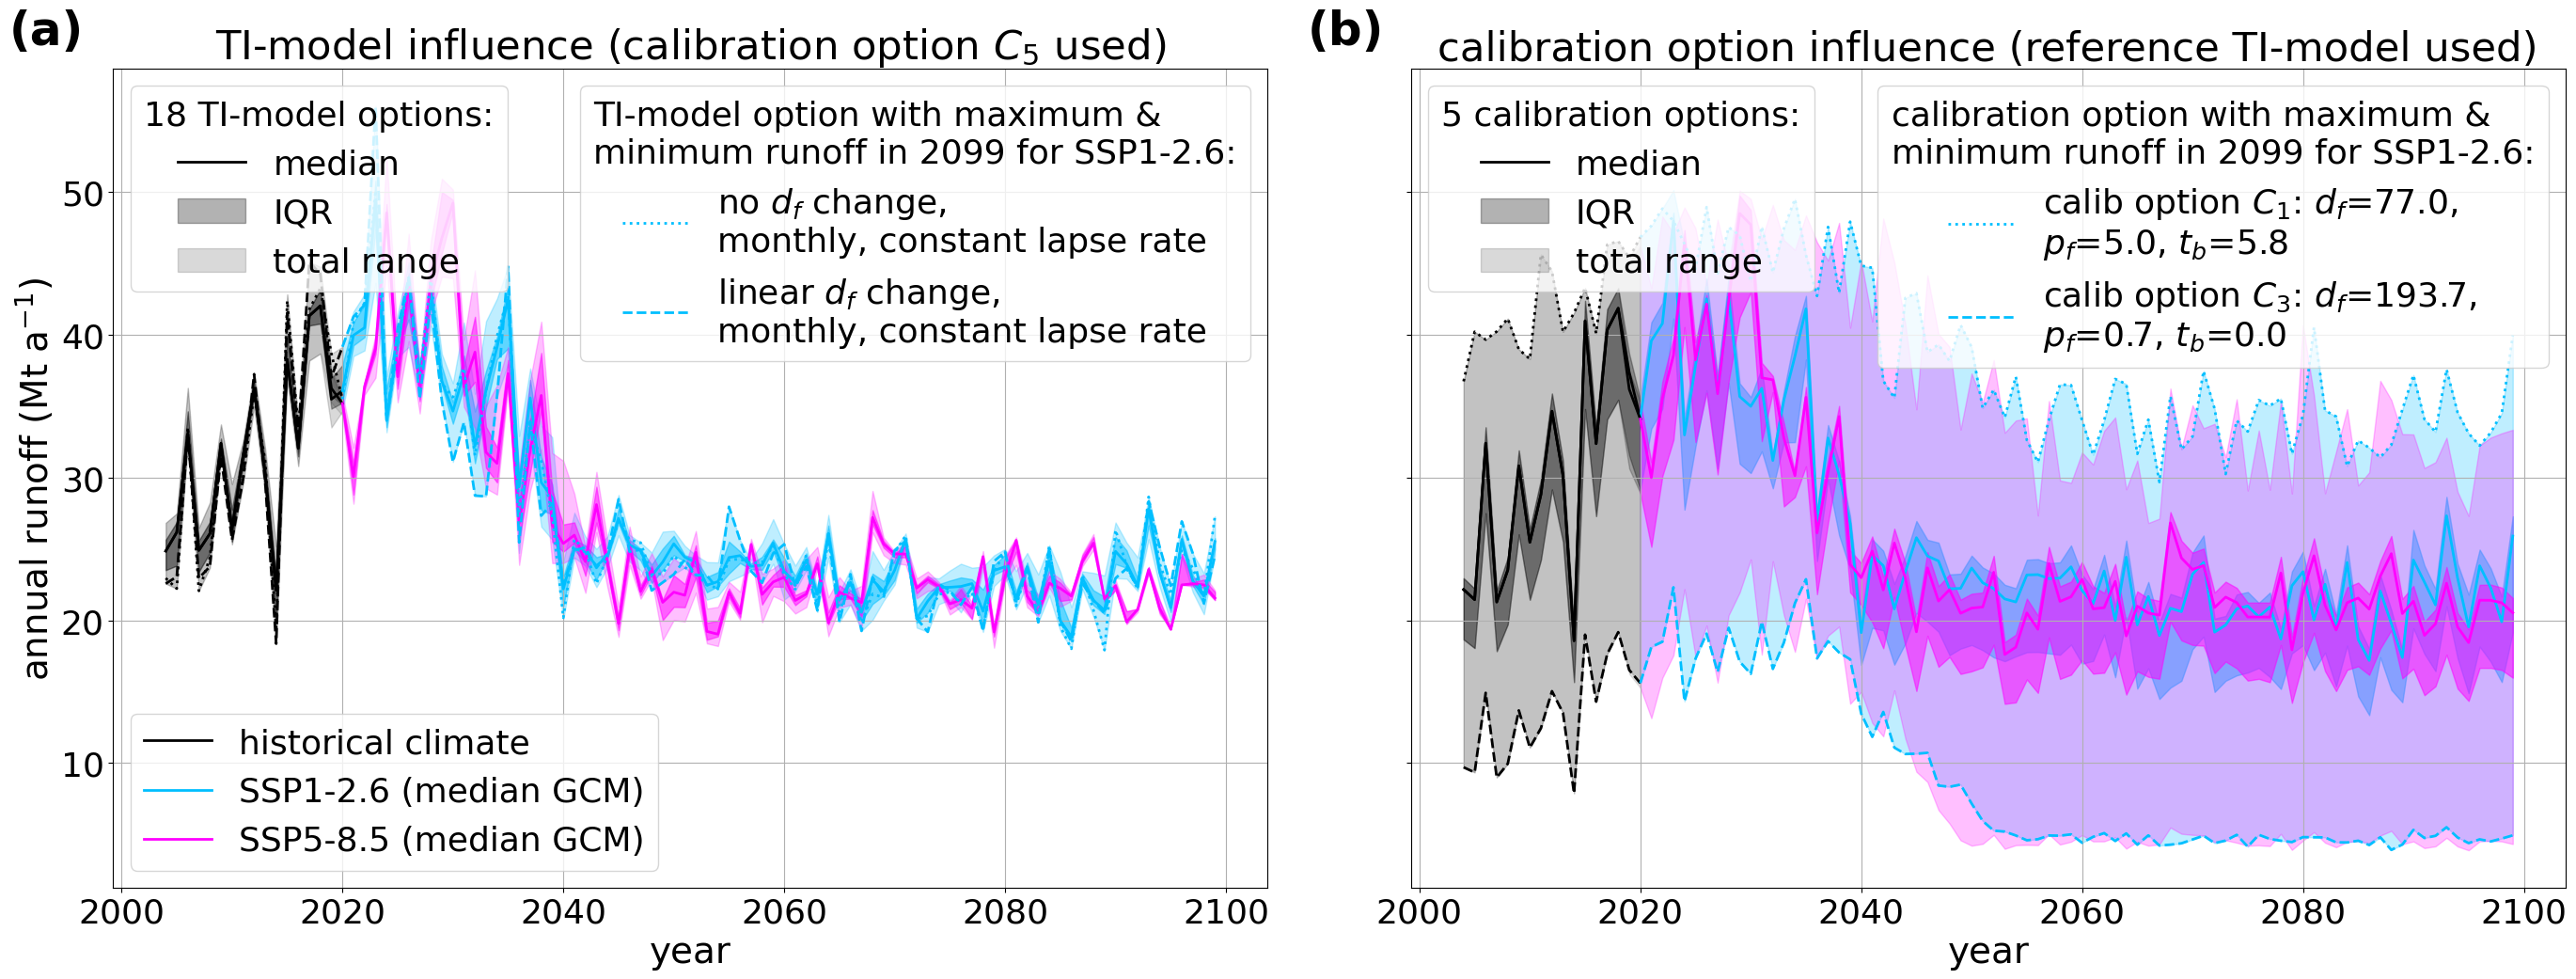

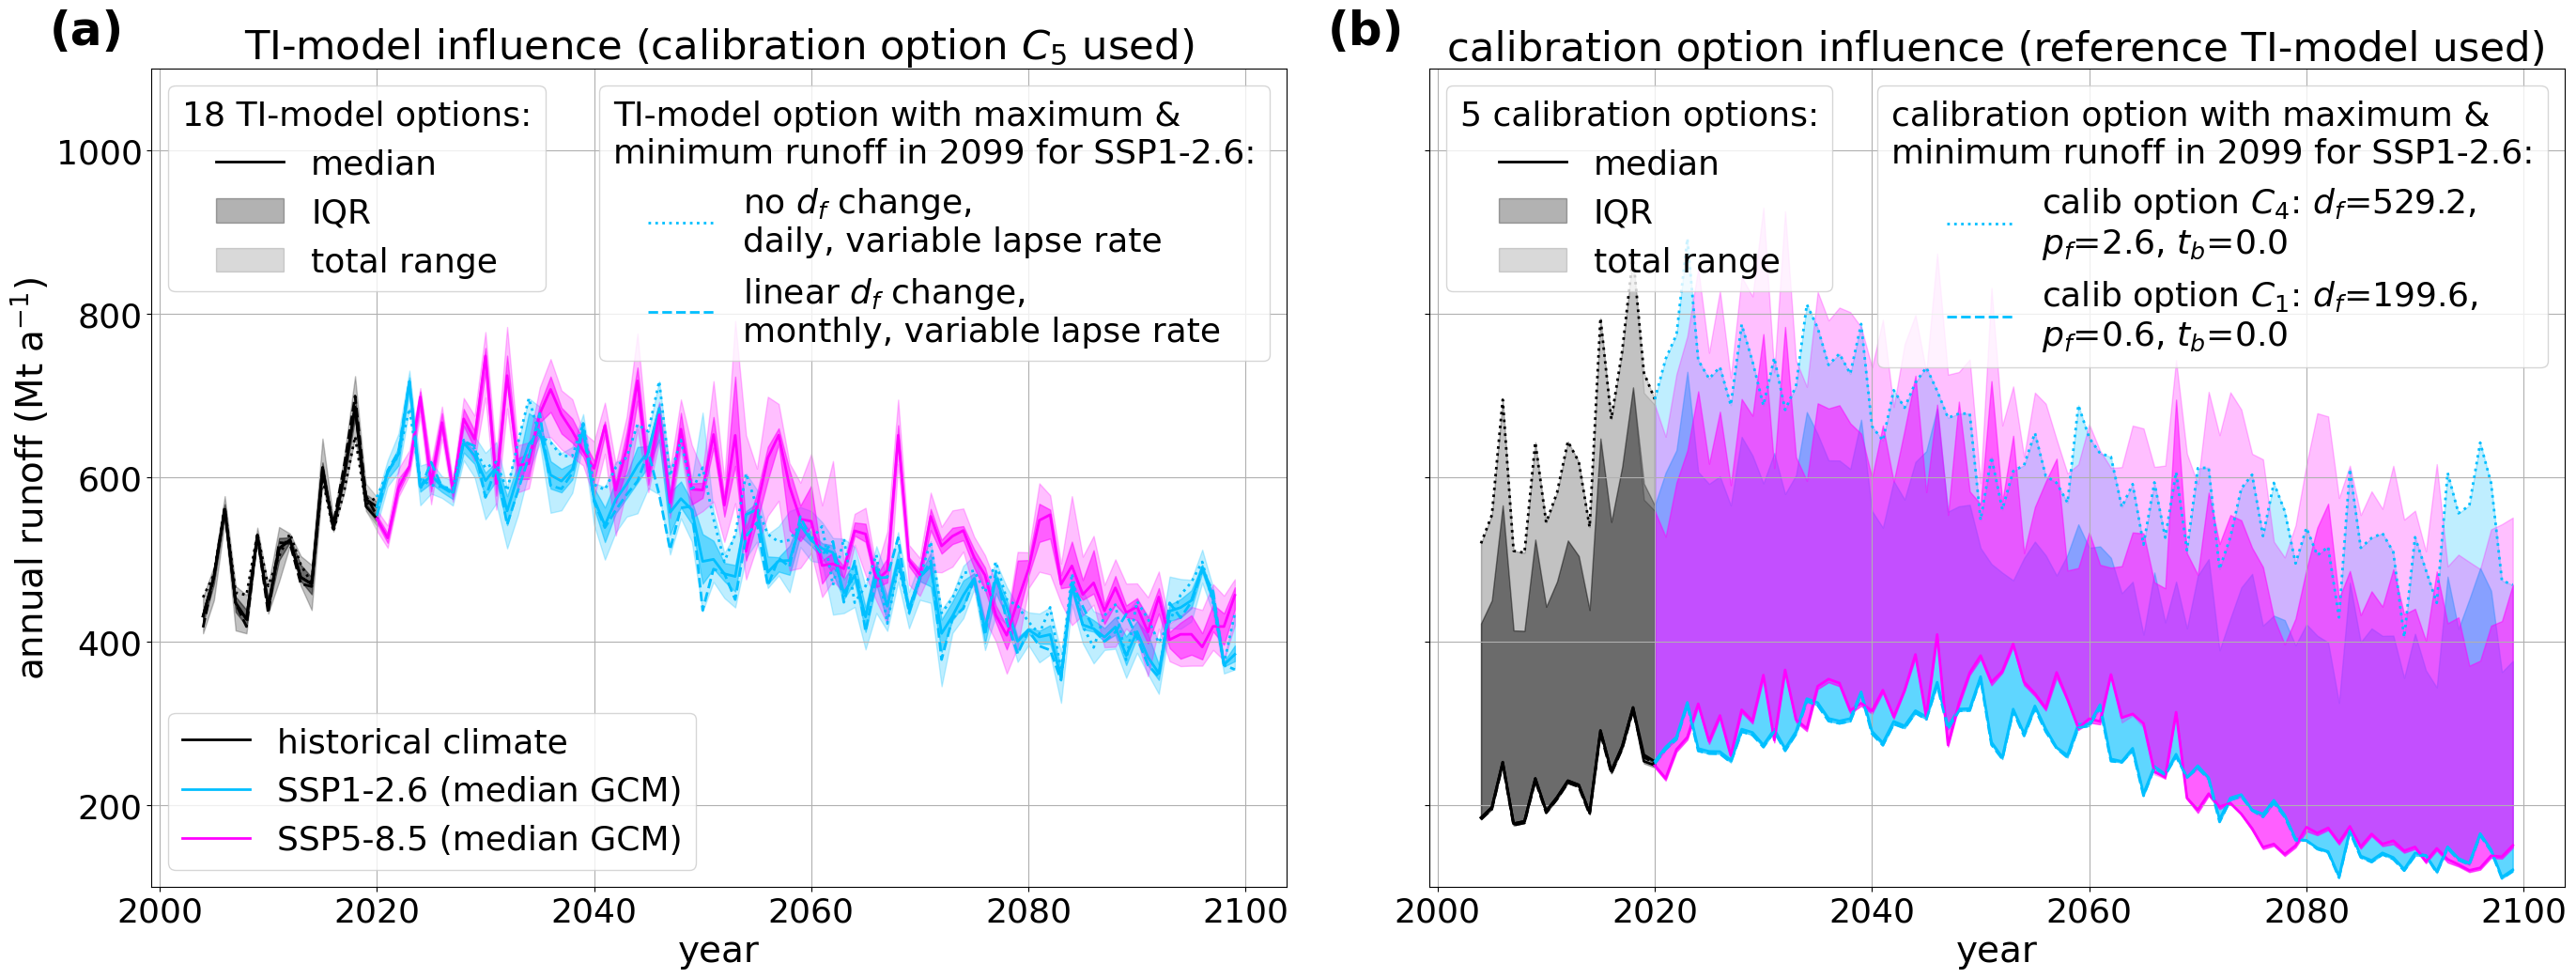

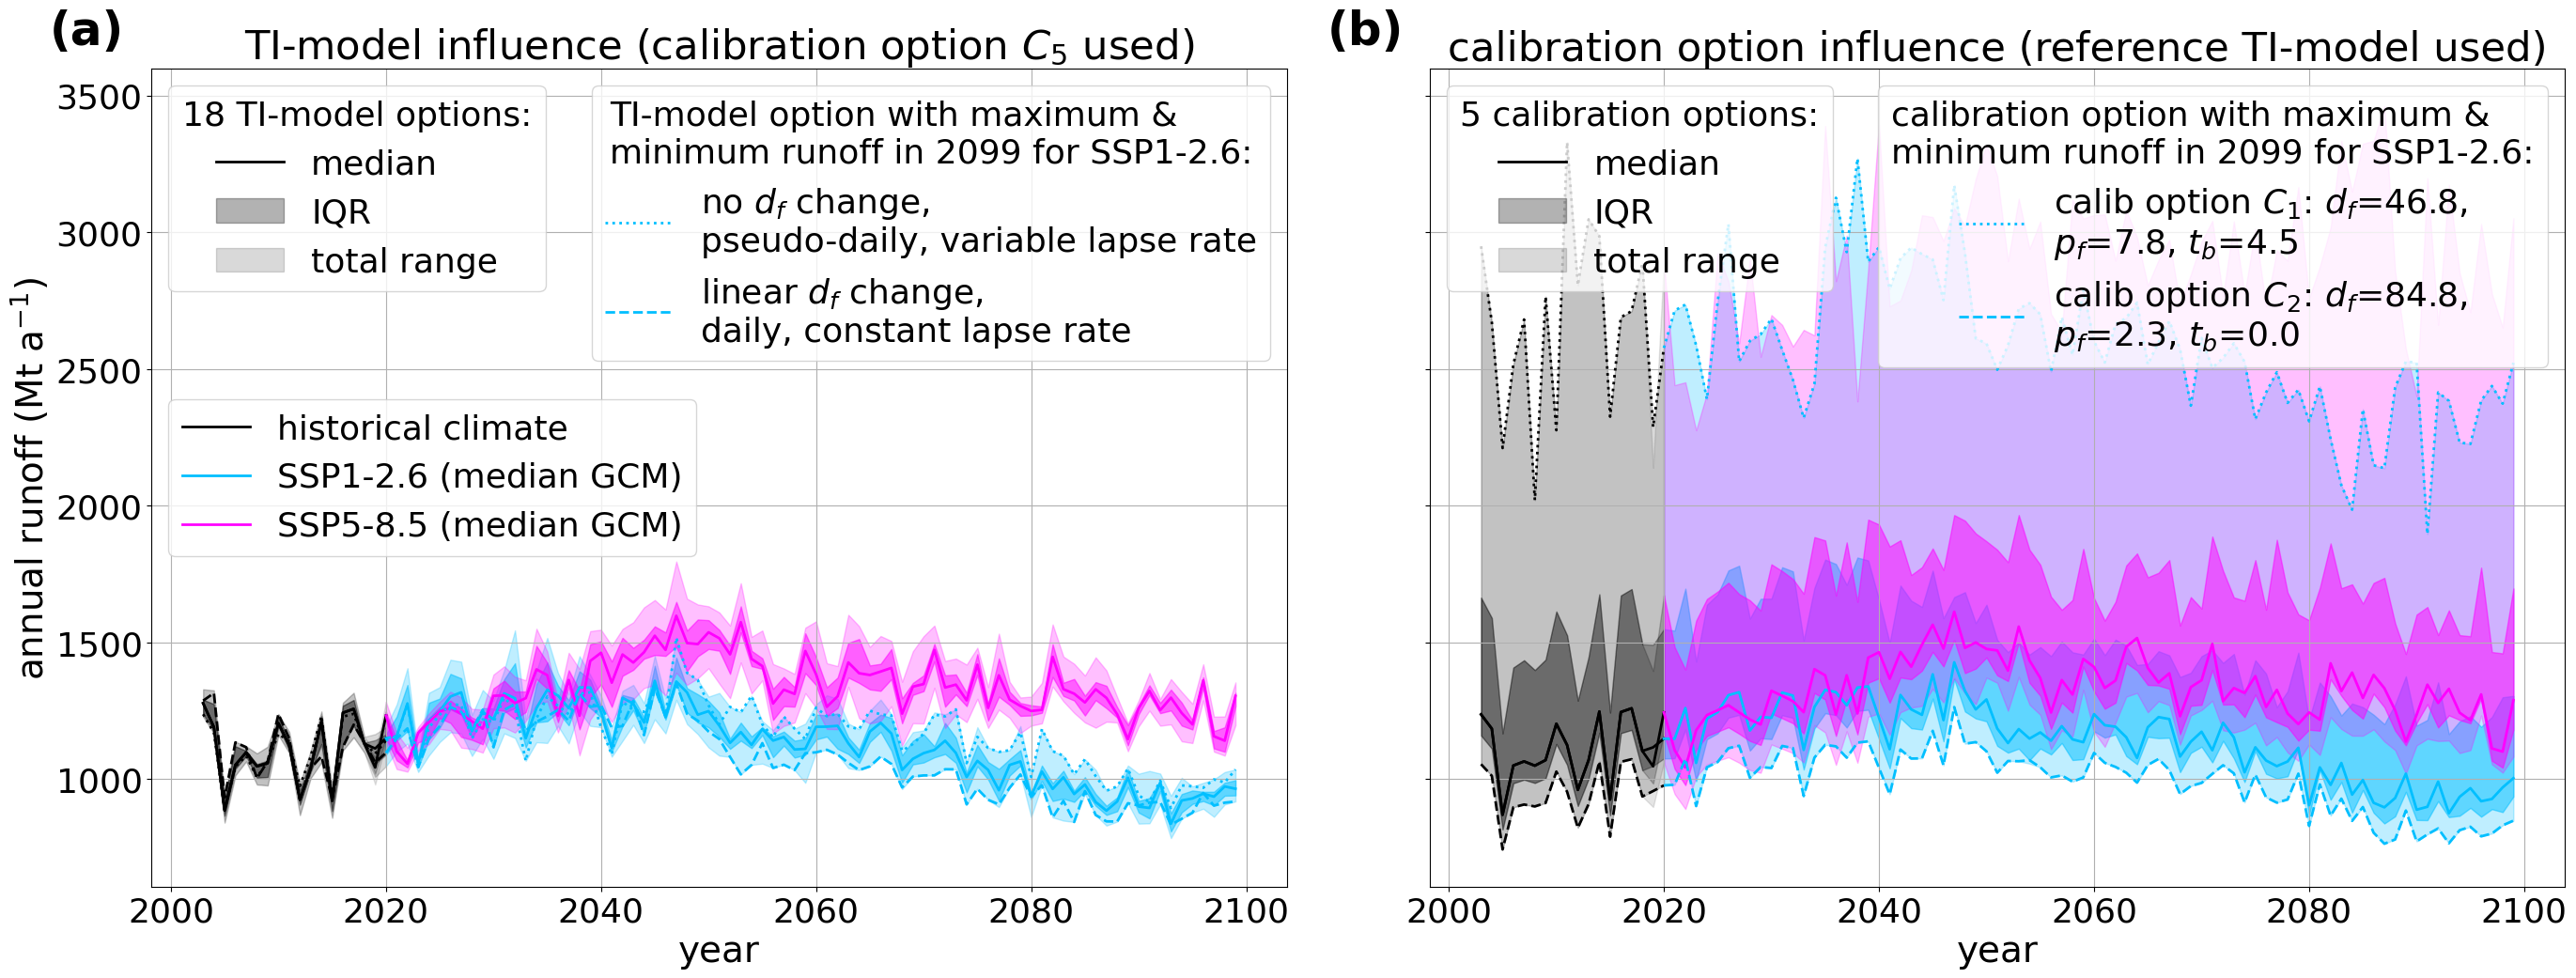

In [9]:
num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)', 5:'(f)', 6:'(g)',
            7:'(h)', 8:'(i)', 9:'(j)', 10:'(k)', 11:'(l)', 12:'(m)'} 

pd_params_stats = pd.read_csv(f'{data_path}/0_pd_params_stats_not_working_for_all.csv', index_col =0)

import sys
ensemble = 'median_gcm'
plt.rc('font', size=20)
plot_option = 'calib_influence'
plot_option = 'mb_model_influence'

num_text_x = -0.09
num_text_y = 1.03
ensemble = 'median_gcm'
plt.rc('font', size=26)
manuscript=True

for rgi in ['RGI60-11.00897','RGI60-11.01450', 'RGI60-06.00234']:
    fig, axss = plt.subplots(1,2, figsize=(28,11), sharey=True)
    if not manuscript:
        plt.suptitle(rgi)
    for j,plot_option in enumerate(['mb_model_influence', 'calib_influence']):
        axs = [axss[j]]
        if plot_option == 'calib_influence':
            if manuscript:
                axs[0].text(num_text_x,num_text_y, num_dict[j],weight='bold',
                    fontsize=36, transform=axs[0].transAxes)
                axs[0].set_title('calibration option influence (reference TI-model used)') #':\nno melt_f change, monthly, constant lapse rate)')
            else:
                axs[0].set_title('calibration option influence (reference MB model of OGGM applied:\nno melt_f change, monthly, constant lapse rate)')
            # for the moment just select one MB options for simplification
            ds_merged = ds_merged_gcms.sel(rgi_id=rgi).median(dim='gcm')
            ds_merged = ds_merged.sel(mb_type='mb_monthly', grad_type = 'cte', melt_f_change='False')
        elif plot_option == 'mb_model_influence':
            if manuscript:
                axs[0].text(num_text_x,num_text_y, num_dict[j],weight='bold',
                    fontsize=36, transform=axs[0].transAxes)
                #axs[0].set_title('TI-model influence (calibration option (E) used)\n') #':\ngeodetic matched, prcp. fac dependent on winter precitation)')
                axs[0].set_title(r'TI-model influence (calibration option $C_5$ used)') #':\ngeodetic matched, prcp. fac dependent on winter precitation)')
            else:
                axs[0].set_title('TI-model influence (option (E) for calibration used:\ngeodetic matched, prcp. fac dependent on winter prcp.)')

            # instead just take the MEDIAN!!!
            ds_merged = ds_merged_gcms.sel(rgi_id=rgi).median(dim='gcm')
            ds_merged = ds_merged.sel(calib_type = 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb')
            
        ds_merged_runoff = (ds_merged[runoff_vars[0]] + ds_merged[runoff_vars[1]] + 
                            ds_merged[runoff_vars[2]] + ds_merged[runoff_vars[3]])/1e9  # from m3 to Mt
        df_merged_vol_yr = ds_merged_runoff.sel(time=slice(2003,2099)).to_dataframe(name='runoff').reset_index()
            
            
        df_merged_vol_yr['mb_grad_type'] = df_merged_vol_yr['mb_type'] + '_' + df_merged_vol_yr['grad_type']
        df_merged_vol_yr['sfc_type'] = df_merged_vol_yr['melt_f_change']
        df_merged_vol_yr.loc[df_merged_vol_yr.melt_f_change!='False', 'sfc_type'] +='\nmonthly'
        fs = []
        for f in df_merged_vol_yr['mb_grad_type']:
            fs.append(f[3:])
        df_merged_vol_yr['mb_grad_type'] = fs
        df_vol_sum_yr = df_merged_vol_yr.groupby(['calib_type', 'mb_grad_type', 'sfc_type', 'ssp', 'time']).sum().copy().reset_index()
        
        
        # df_merged_vol_yr_median = df_merged_vol_yr.groupby(['mb_grad_type', 'ssp', 'calib_type', 'time']).median().reset_index()
        pd_params_stats_sel = pd_params_stats.loc[(pd_params_stats.mb_grad_type == 'mb_monthly_cte') & (pd_params_stats.sfc_type =='False')].loc[rgi]
        df_merged_vol_yr_median_a= df_merged_vol_yr.loc[df_merged_vol_yr.rgi_id==rgi].groupby(['mb_grad_type', 'ssp', 'calib_type',
                                                                                               'time', 'sfc_type']).median().reset_index()

        d_hef = df_merged_vol_yr.loc[(df_merged_vol_yr.rgi_id==rgi) & (df_merged_vol_yr.time == 2099)].groupby(['mb_grad_type', 'ssp',
                                                                                                                'calib_type', 'time',
                                                                                                                'melt_f_change']).median()[['runoff']]
        d_hef = d_hef.query("ssp=='ssp126'").sort_values(by='runoff')
        mb_grad_type_min, _, calib_min,_, sfc_type_min = d_hef.iloc[0].name
        mb_grad_type_max, _, calib_max,_, sfc_type_max = d_hef.iloc[-1].name
        
        
        for ssp in ds_merged.ssp.values:
            for period in ['hist', 'future']:
                if period == 'hist':
                    df_merged_vol_yr_median = df_merged_vol_yr_median_a.where(df_merged_vol_yr_median_a.time<=2020).dropna()
                    color_ssp_d = {'ssp126':'black', 'ssp585':'black'}
                    a = -0.1
                    if ssp == 'ssp585':
                        a = -0.15

                elif period == 'future':
                    a=0
                    df_merged_vol_yr_median = df_merged_vol_yr_median_a.where(df_merged_vol_yr_median_a.time>=2020).dropna()
                    #color_ssp_d = {'ssp126':'blue', 'ssp585':'red'}
                    color_ssp_d = {'ssp126':sns.color_palette(['deepskyblue'])[0], 'ssp585':'magenta'}

                d_merged_stats = df_merged_vol_yr_median.loc[df_merged_vol_yr_median.ssp==ssp].groupby('time').median().reset_index()
                d_q975 = df_merged_vol_yr_median.loc[df_merged_vol_yr_median.ssp==ssp].groupby('time').max().reset_index()['runoff']
                d_q025 = df_merged_vol_yr_median.loc[df_merged_vol_yr_median.ssp==ssp].groupby('time').min().reset_index()['runoff']

                d_q75 = df_merged_vol_yr_median.loc[df_merged_vol_yr_median.ssp==ssp].groupby('time').quantile([0.75]).reset_index()['runoff']
                d_q25 = df_merged_vol_yr_median.loc[df_merged_vol_yr_median.ssp==ssp].groupby('time').quantile([0.25]).reset_index()['runoff']
                d_merged_stats['median runoff'] = d_merged_stats['runoff'].values
                d_merged_stats['interquartile range of runoff'] = d_q75-d_q25
                axs[0].plot(d_merged_stats.time, d_merged_stats['median runoff'], label=f'median',
                            color=color_ssp_d[ssp], linewidth=2)

                axs[0].fill_between(d_merged_stats.time, d_q75, d_q25, alpha = 0.5+2*a, label=f'IQR',
                                    color=color_ssp_d[ssp])    
                axs[0].fill_between(d_merged_stats.time, d_q975, d_q025, alpha = 0.25+a, label=f'total range', color=color_ssp_d[ssp])    

        handles, labels = axs[0].get_legend_handles_labels()
        if plot_option == 'calib_influence':
            order = [0,1,2]
            leg1=axs[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                               #bbox_to_anchor =(0.41,0.725), 
                               loc = 'upper left', title='5 calibration options:')
            order = [0,3,9]
            leg2=axs[0].legend([handles[idx] for idx in order],['historical climate', 
                                                                f'SSP1-2.6 (median GCM)',
                                                                f'SSP5-8.5 (median GCM)'],
                               #bbox_to_anchor =(1,0.725),
                               loc = 'lower left')
        elif plot_option == 'mb_model_influence':
            order = [0,1,2]
            leg1=axs[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], #bbox_to_anchor =(0.41,0.725),
                               loc = 'upper left',
                               title='18 TI-model options:')
            order = [0,3,9]
            if rgi == 'RGI60-06.00234':
                loc = 'center left'
            else:
                loc = 'lower left'
            leg2=axs[0].legend([handles[idx] for idx in order],['historical climate', 
                                                               f'SSP1-2.6 (median GCM)',
                                                                f'SSP5-8.5 (median GCM)'],
                               #bbox_to_anchor =(1,0.725),
                               loc = loc)

        d_hef_timeline_a = df_merged_vol_yr.loc[df_merged_vol_yr.rgi_id==rgi].groupby(['mb_grad_type', 'ssp', 'calib_type',
                                                                                       'time', 'melt_f_change']).median().to_xarray()
        for period in ['hist', 'future']:
            if period == 'hist':
                d_hef_timeline = d_hef_timeline_a.where(d_hef_timeline_a.time<=2020).dropna(dim='time')
                color_sel = 'black'
            elif period == 'future':
                d_hef_timeline = d_hef_timeline_a.where(d_hef_timeline_a.time>=2020).dropna(dim='time')
                color_sel = sns.color_palette(['deepskyblue'])[0] 
            d_hef_timeline_max = d_hef_timeline.sel(ssp='ssp126').sel(calib_type=calib_max).sel(mb_grad_type = mb_grad_type_max).sel(melt_f_change=sfc_type_max) #(dim='mb_grad_type') #, 'calib_type', 'sfc_type'])
            if sfc_type_max == 'False':
                sfc_type_max_poster = f'no $d_f$ change, '
            elif sfc_type_max == 'linear':
                sfc_type_max_poster = f'linear $d_f$ change, '
            elif sfc_type_max == 'neg_exp':
                sfc_type_max_poster = f'neg. exp $d_f$ change, '
            else:
                sys.exit('need more options sfc_type_max_poster?? check code')
            if mb_grad_type_max == 'mb_monthly_cte' or mb_grad_type_max == 'monthly_cte':
                mb_grad_type_max_poster = '\nmonthly, constant lapse rate'
            elif mb_grad_type_max == 'real_daily_var_an_cycle':
                mb_grad_type_max_poster = '\ndaily, variable lapse rate'
            elif mb_grad_type_max == 'monthly_var_an_cycle':
                mb_grad_type_max_poster = '\nmonthly, variable lapse rate'
            elif mb_grad_type_max == 'pseudo_daily_fake_cte':
                mb_grad_type_max_poster = '\npseudo-daily, constant lapse rate'
            elif mb_grad_type_max == 'pseudo_daily_fake_var_an_cycle':
                mb_grad_type_max_poster = '\npseudo-daily, variable lapse rate'
            elif mb_grad_type_max == 'real_daily_cte':
                mb_grad_type_max_poster = '\ndaily, constant lapse rate'
            else:
                sys.exit('need more options mb_grad_type_max_poster')
            if calib_max == 'calib_geod_opt_winter_mb_approx_std':
                calib_max_poster = '(A) geodetic, winter MB & ~ interannual variability matched'
                if manuscript:
                    calib_max_poster = r'calib option $C_1$'
            elif calib_max == 'calib_geod_opt_winter_mb_temp_b_0':
                calib_max_poster = '(B) geodetic & winter MB matched'
                if manuscript:
                    calib_max_poster = r'calib option $C_2$' #'calib option (B)'
            elif calib_max == 'calib_geod_opt_std_temp_b_0':
                calib_max_poster = '(C) geodetic & interannaul variability matched'
                if manuscript:
                    calib_max_poster = r'calib option $C_3$'   ##'calib option (C)'
            elif calib_max == 'calib_only_geod_temp_b_0_pf_cte_via_std':
                calib_max_poster = f'(D) geodetic matched, $p_f$ from median of option $C_3$'
                if manuscript:
                    calib_max_poster = r'calib option $C_4$'   #'calib option (D)'
            elif calib_max == 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb':
                calib_max_poster = f'(E) geodetic matched, $p_f$ dependent on winter prcp.'
                if manuscript:
                    calib_max_poster = r'calib option $C_5$'    #'calib option (E)'
            if plot_option == 'calib_influence':
                pd_params_stats_sel_calib = pd_params_stats_sel.loc[pd_params_stats_sel.calib_type == calib_max]
                melt_f = pd_params_stats_sel_calib['melt_f'].values[0]
                prcp_fac = pd_params_stats_sel_calib['pf_opt'].values[0]
                temp_b = pd_params_stats_sel_calib['temp_bias'].values[0]
                label_max = (f'{calib_max_poster}: '+
                             r'$d_f$'+f'={melt_f:.1f},\n'+
                             r'$p_f$'+f'={prcp_fac:.1f}, '+r'$t_b$'+f'={temp_b:.1f}')
            elif plot_option == 'mb_model_influence':
                label_max = f'{sfc_type_max_poster}{mb_grad_type_max_poster}'
            axs[0].plot(d_hef_timeline_max.time, d_hef_timeline_max['runoff'],
                        color = color_sel, ls = ':', alpha = 1, lw=2,label=label_max)
            d_hef_timeline_min = d_hef_timeline.sel(ssp='ssp126').sel(calib_type=calib_min).sel(mb_grad_type = mb_grad_type_min).sel(melt_f_change=sfc_type_min) #(dim='mb_grad_type') #, 'calib_type', 'sfc_type'])
            if sfc_type_min == 'False':
                sfc_type_min_poster = f'no $d_f$ change, '
            elif sfc_type_min == 'linear':
                sfc_type_min_poster = f'linear $d_f$ change, '
            elif sfc_type_min == 'neg_exp':
                sfc_type_min_poster = f'neg. exp $d_f$ change, '
            else:
                sys.exit('need more options sfc_type_min_poster')
            if mb_grad_type_min == 'mb_monthly_cte' or mb_grad_type_min == 'monthly_cte':
                mb_grad_type_min_poster = '\nmonthly, constant lapse rate'
            elif mb_grad_type_min == 'real_daily_var_an_cycle':
                mb_grad_type_min_poster = '\ndaily, variable lapse rate'
            elif mb_grad_type_min == 'monthly_var_an_cycle':
                mb_grad_type_min_poster = '\nmonthly, variable lapse rate'
            elif mb_grad_type_min == 'real_daily_cte':
                mb_grad_type_min_poster = '\ndaily, constant lapse rate'
            elif mb_grad_type_min == 'pseudo_daily_fake_cte':
                mb_grad_type_min_poster = '\npseudo-daily, constant lapse rate'
            elif mb_grad_type_min == 'pseudo_daily_fake_var_an_cycle':
                mb_grad_type_min_poster = '\npseudo-daily, variable lapse rate'
            else:
                sys.exit('need more options mb_grad_type_min_poster')

            if calib_min == 'calib_geod_opt_winter_mb_approx_std':
                calib_min_poster = '(A) geodetic, winter MB & ~ interannual variability matched'
                if manuscript:
                    calib_min_poster = r'calib option $C_1$'   #'calib option (A)'
            elif calib_min == 'calib_geod_opt_winter_mb_temp_b_0':
                calib_min_poster = '(B) geodetic & winter MB matched'
                if manuscript:
                    calib_min_poster = r'calib option $C_2$'   #'calib option (B)'
            elif calib_min == 'calib_geod_opt_std_temp_b_0':
                calib_min_poster = '(C) geodetic & interannaul variability matched'
                if manuscript:
                    calib_min_poster = r'calib option $C_3$'   #'calib option (C)'
            elif calib_min == 'calib_only_geod_temp_b_0_pf_cte_via_std':
                calib_min_poster = '(D) geodetic matched, prcp. fac from median of option (C)'
                if manuscript:
                    calib_min_poster = r'calib option $C_4$'   #'calib option (D)'
            elif calib_min == 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb':
                calib_min_poster = '(E) geodetic matched, prcp. fac dependent on winter prcp.'
                if manuscript:
                    calib_min_poster = r'calib option $C_5$'   #'calib option (E)'
            if plot_option == 'calib_influence':
                pd_params_stats_sel_calib = pd_params_stats_sel.loc[pd_params_stats_sel.calib_type == calib_min]
                melt_f = pd_params_stats_sel_calib['melt_f'].values[0]
                prcp_fac = pd_params_stats_sel_calib['pf_opt'].values[0]
                temp_b = pd_params_stats_sel_calib['temp_bias'].values[0]
                label_min = (f'{calib_min_poster}: '+
                             r'$d_f$'+f'={melt_f:.1f},\n'+
                             r'$p_f$'+f'={prcp_fac:.1f}, '+r'$t_b$'+f'={temp_b:.1f}')
            elif plot_option == 'mb_model_influence':
                label_min = f'{sfc_type_min_poster}{mb_grad_type_min_poster}'
            axs[0].plot(d_hef_timeline_min.time, d_hef_timeline_min['runoff'],
                        color = color_sel, ls = '--', alpha = 1, lw=2,label=label_min)
            
            

        handles, labels = axs[0].get_legend_handles_labels()
        if plot_option == 'calib_influence':
            legend_title = 'calibration option with maximum &\nminimum runoff in 2099 for SSP1-2.6:'
        elif plot_option == 'mb_model_influence':
            legend_title = 'TI-model option with maximum &\nminimum runoff in 2099 for SSP1-2.6:'

        leg3 = axs[0].legend(handles[-2:], labels[-2:],
                                 loc = 'upper right',  #bbox_to_anchor =(1,0.725),
                             title = legend_title)

        axs[0].add_artist(leg1)
        if plot_option != 'calib_influence':
            axs[0].add_artist(leg2)

        axs[0].grid()
        #axs[1].grid()
        if plot_option != 'calib_influence':
            axs[0].set_ylabel(r'annual runoff (Mt a$^{-1}$)', fontsize=28)
        else:
            axs[0].set_ylabel(r'annual runoff (Mt a$^{-1}$)', fontsize=28, alpha=0)
            
        axs[0].set_xlabel('year', fontsize=28)

        plt.tight_layout()
        if rgi == 'RGI60-11.01450':
            plt.ylim([100,1100])

        if rgi == 'RGI60-11.01450':
            plt.savefig(f'{fig_path}/figures_supplements/fig_S13_runoff_ti_model_calib_option_influence_{rgi}.pdf')
        elif rgi == 'RGI60-11.00897':
            plt.savefig(f'{fig_path}/figures_supplements/fig_S15_runoff_ti_model_calib_option_influence_{rgi}.pdf')
        else:
            pass
            

## Fig. S17: for all glaciers:


In [11]:
import sys
ensemble = 'median_gcm'
plt.rc('font', size=20)
plot_option = 'calib_influence'
#plot_option = 'mb_model_influence'
col_pal_ssp = sns.color_palette(['deepskyblue', 'red'])
plot_option = 'calib_influence'
ds_merged = ds_merged_gcms.median(dim='gcm')

ds_m = ds_merged.sel(time=slice(2020,2099,79)).copy() #.to_dataframe().reset_index() 
len_rgis_run = len(ds_m.rgi_id)
pd_len_rgis = pd.DataFrame(columns=['ssp', 'time', 'still_exist', 'all'])
j = 0
working_dict = {}
for time in [2020, 2099]:
    for ssp in ['ssp126', 'ssp585']:
        # any: it is sufficient that there is for one MB model type or calib type a 0 value -> then it is dropped
        working_dict[f'{time}_{ssp}'] = ds_m.sel(ssp=ssp).sel(time=time).where(ds_m.sel(ssp=ssp).sel(time=time).volume>0.001).dropna(dim='rgi_id', how='any').rgi_id.values
        len_rgis_run_t = len(ds_m.sel(ssp=ssp).sel(time=time).where(ds_m.sel(ssp=ssp).sel(time=time).volume>0.001).dropna(dim='rgi_id', how='any').rgi_id)
        pd_len_rgis.loc[j] = np.array([ssp, time, len_rgis_run_t, len_rgis_run])
        j += 1
pd_len_rgis['still_exist'] = pd_len_rgis['still_exist'].astype(int)

#axs[0].set_title('calibration option influence (default MB model of OGGM applied:\nno melt_f change, monthly, constant lapse rate)')
# for the moment just select one MB options for simplification
#ds_merged = ds_merged.sel(mb_type='mb_monthly', grad_type = 'cte', melt_f_change='False')
#axs[0].set_title('MB model influence (option (e) for calibration used:\ngeodetic matched, prcp. fac dependent on winter prcp.)')
# instead just take the MEDIAN!!!
calib_type_to_compare = calib_types[0]
print(calib_types[0])
# .sel(rgi_id=rgis_not_melting)
ds_merged_runoff = (ds_merged[runoff_vars[0]] + ds_merged[runoff_vars[1]] + 
                            ds_merged[runoff_vars[2]] + ds_merged[runoff_vars[3]])/1e9  # from m3 to Mt
ds_merged_runoff = ds_merged_runoff.sel(time=slice(2003,2099))


ref_runoff_option = ds_merged_runoff.sel(calib_type=calib_type_to_compare)
ds_merged_vs_ref_each_calib_option = ds_merged_runoff/ref_runoff_option 
ds_merged_vs_ref_each_calib_option = ds_merged_vs_ref_each_calib_option.where(ds_merged_vs_ref_each_calib_option < np.inf,
                                                                              drop=True) #, ds_merged_vs_ref_each_option.values)
ds_merged_vs_ref_each_calib_option = ds_merged_vs_ref_each_calib_option.where(ds_merged_vs_ref_each_calib_option >0,
                                                                              drop=True) #, ds_merged_vs_ref_each_option.values)

### also estimate just the melt_on_glacier part
ds_merged_runoff_melt_on_glacier = ds_merged.sel(time=slice(2003,2099)).melt_on_glacier/1e9

ref_runoff_option_melt_on_glacier = ds_merged_runoff_melt_on_glacier.sel(calib_type=calib_type_to_compare)
ds_merged_vs_ref_each_calib_option_melt_on_glacier = ds_merged_runoff_melt_on_glacier/ref_runoff_option_melt_on_glacier 
ds_merged_vs_ref_each_calib_option_melt_on_glacier = ds_merged_vs_ref_each_calib_option_melt_on_glacier.where(ds_merged_vs_ref_each_calib_option_melt_on_glacier < np.inf,
                                                                              drop=True) #, ds_merged_vs_ref_each_option.values)
ds_merged_vs_ref_each_calib_option_melt_on_glacier = ds_merged_vs_ref_each_calib_option_melt_on_glacier.where(ds_merged_vs_ref_each_calib_option >0,
                                                                              drop=True) #, ds_merged_vs_ref_each_option.values)

# find out those glaciers that did not run for all options
pd_glac_working_hydro = ds_merged_vs_ref_each_calib_option.sel(time=slice(2020,2039)).to_dataframe(name='runoff').reset_index()
not_working_2020_2039 = pd_glac_working_hydro.loc[np.where(pd_glac_working_hydro.isna())[0]].rgi_id.unique()
pd_glac_working_hydro = ds_merged_vs_ref_each_calib_option.sel(time=slice(2080,2099)).to_dataframe(name='runoff').reset_index()
not_working_2080_2099 = pd_glac_working_hydro.loc[np.where(pd_glac_working_hydro.isna())[0]].rgi_id.unique()
assert np.all(not_working_2080_2099 == not_working_2020_2039)
rgi_working_calib = list(ds_merged_vs_ref_each_calib_option.rgi_id.values)
for r in not_working_2080_2099:
    rgi_working_calib.remove(r)
print(len(rgi_working_calib))

calib_geod_opt_winter_mb_approx_std
85


In [12]:
ds_a = ds_merged_runoff.sel(time=slice(2030,2049)).mean(dim='time')
ds_a.coords['time'] = '2030-2049'
ds_b = ds_merged_runoff.sel(time=slice(2080,2099)).mean(dim='time')
ds_b.coords['time'] = '2080-2099'


### also estimate just the melt_on_glacier part
ds_a_melt_on_glacier = ds_merged_runoff_melt_on_glacier.sel(time=slice(2030,2049)).mean(dim='time')
ds_a_melt_on_glacier.coords['time'] = '2030-2049'
ds_b_melt_on_glacier = ds_merged_runoff_melt_on_glacier.sel(time=slice(2080,2099)).mean(dim='time')
ds_b_melt_on_glacier.coords['time'] = '2080-2099'

ds_m = ds_merged.sel(time=slice(2030,2099,69)).copy() #.to_dataframe().reset_index() 
len_rgis_run = len(ds_m.rgi_id)
pd_len_rgis = pd.DataFrame(columns=['ssp', 'time', 'still_exist', 'all'])
j = 0
working_dict = {}
for time in [2030, 2099]:
    for ssp in ['ssp126', 'ssp585']:
        # any: it is sufficient that there is for one MB model type or calib type a 0 value -> then it is dropped
        working_dict[f'{time}_{ssp}'] = list(ds_m.sel(ssp=ssp).sel(time=time).where(ds_m.sel(ssp=ssp).sel(time=time).volume>0.0001).dropna(dim='rgi_id', how='any').rgi_id.values)
        len_rgis_run_t = len(ds_m.sel(ssp=ssp).sel(time=time).where(ds_m.sel(ssp=ssp).sel(time=time).volume>0.001).dropna(dim='rgi_id', how='any').rgi_id)
        pd_len_rgis.loc[j] = np.array([ssp, time, len_rgis_run_t, len_rgis_run])
        j += 1
pd_len_rgis['still_exist'] = pd_len_rgis['still_exist'].astype(int)

# these are those glacies for ssp126 and time=2100 for volume projections --> there are two other glaciers that gained mass just
# in the year 2100, let's add them aswell for better comparability 
testi = ['RGI60-08.01779', 'RGI60-13.08624', 'RGI60-18.01130',
       'RGI60-01.04591', 'RGI60-06.00236', 'RGI60-13.18096',
       'RGI60-08.00188', 'RGI60-01.01390', 'RGI60-17.02128',
       'RGI60-08.02650', 'RGI60-06.00234', 'RGI60-08.02017',
       'RGI60-11.00897', 'RGI60-08.02384', 'RGI60-08.00987',
       'RGI60-08.00449', 'RGI60-02.17369', 'RGI60-08.01126',
       'RGI60-08.03416', 'RGI60-01.09162', 'RGI60-08.01258',
       'RGI60-08.01657', 'RGI60-05.00446', 'RGI60-11.02773',
       'RGI60-10.01737', 'RGI60-08.01217', 'RGI60-08.01598',
       'RGI60-08.00312', 'RGI60-08.02666', 'RGI60-11.02679',
       'RGI60-13.05504', 'RGI60-06.00238', 'RGI60-11.02704',
       'RGI60-12.01132', 'RGI60-01.00570', 'RGI60-08.00287',
       'RGI60-08.01286', 'RGI60-05.20030', 'RGI60-02.02631',
       'RGI60-11.01450', 'RGI60-02.17612', 'RGI60-13.06361',
       'RGI60-10.01708', 'RGI60-10.01732', 'RGI60-12.00161']

for t in testi:
    if t not in working_dict[f'2099_ssp126']:
        print(t)
        working_dict[f'{time}_{ssp}'].append(t)
        
pd_len_rgis

RGI60-08.02384
RGI60-08.01258


ssp  time  still_exist all
0  ssp126  2030           77  85
1  ssp585  2030           77  85
2  ssp126  2099           43  85
3  ssp585  2099           15  85

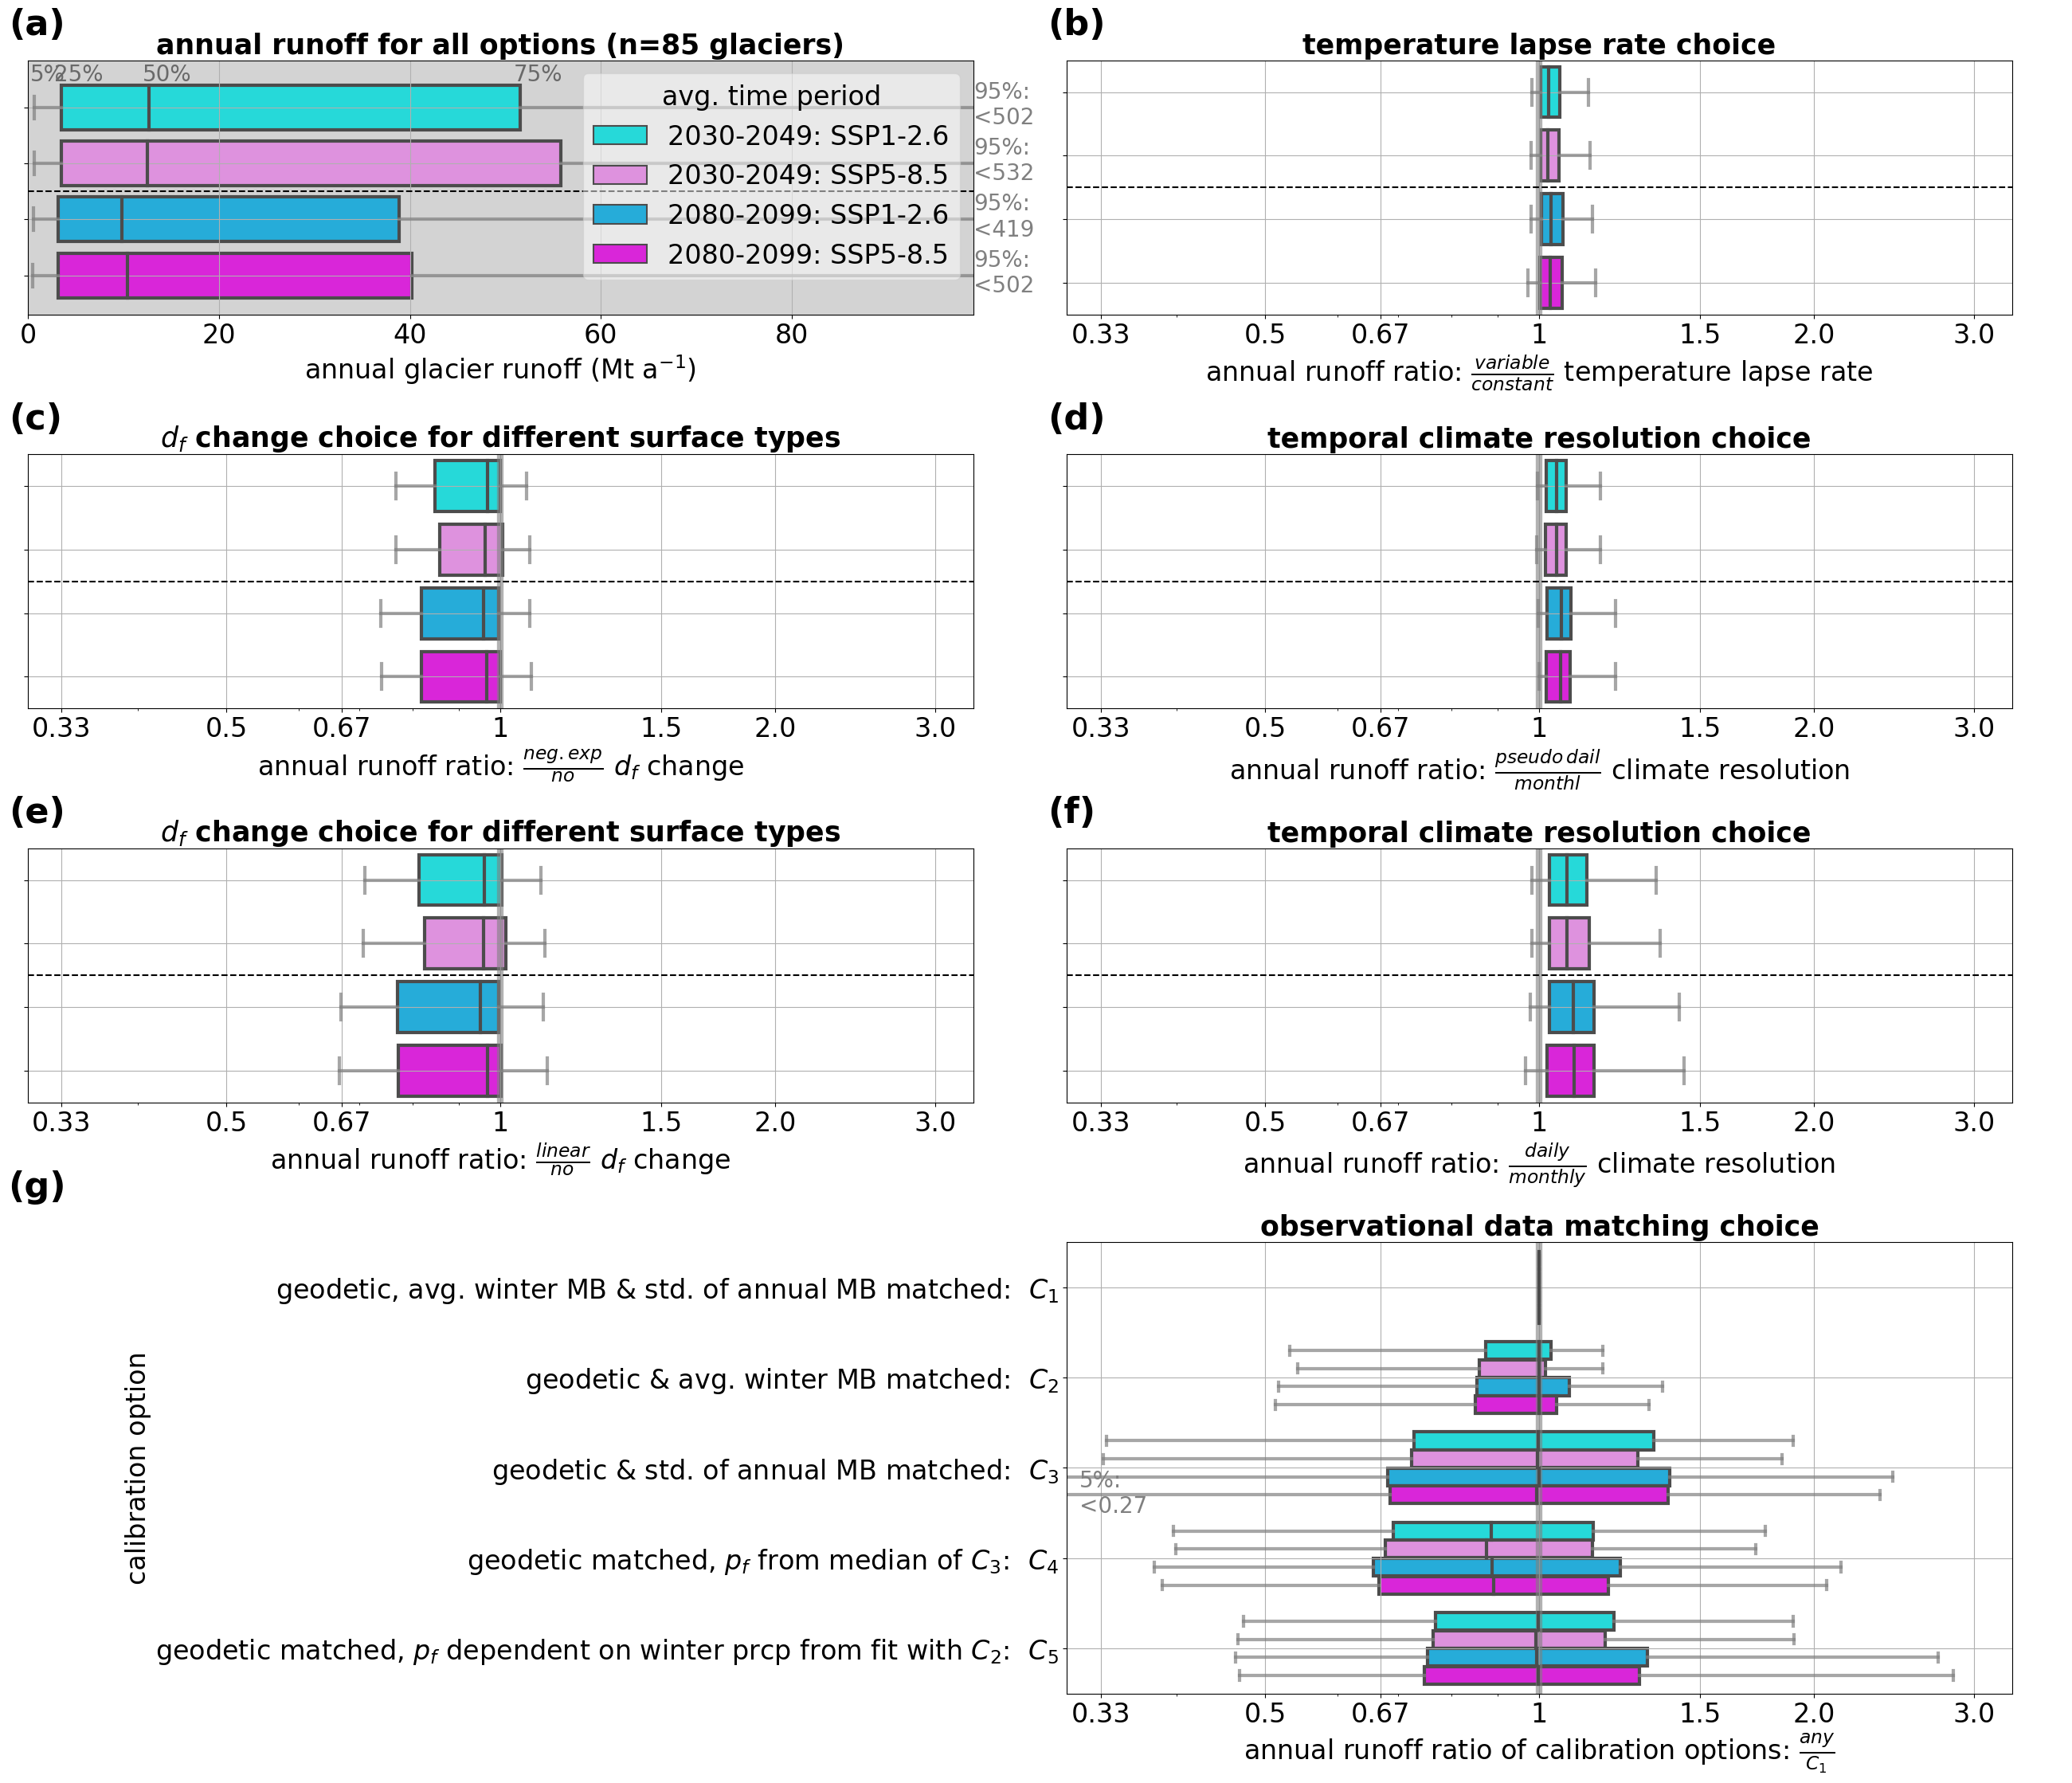

In [13]:
# overall MB and calib option influence
# 
plt.rc('font', size=24)

num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)', 5: '(f)', 6: '(g)'}

# logarithmic scale because of ratios ...
xlim0 = 0.303
xlim1 = 3.3
fs_num_dict = 32
num_text_x = -0.02
num_text_y = 1.1

violin = False
all_same_glaciers = True ## True
only_still_existing_glaciers_in_2100 = False
#for all_same_glaciers in [True]: ## False
ds_merged_runoff_avg = xr.concat([ds_a,ds_b], dim = 'time').copy()
ds_merged_runoff_avg = ds_merged_runoff_avg.sel(rgi_id = rgi_working_calib)
if all_same_glaciers:
    pd_all = ds_merged_runoff_avg.to_dataframe(name='runoff').reset_index() #.groupby(['ssp', 'calib_type', 'time']).quantile([0.25,0.5,0.75]).round(2)).reset_index()
    ds_m = ds_merged_runoff_avg.copy()


col_pal_both_ssp = sns.color_palette(['cyan','violet','deepskyblue','magenta'])
hue_order = ['2030-2049: ssp126', '2030-2049: ssp585', '2080-2099: ssp126', '2080-2099: ssp585']
#pd_all['time'] = pd_all.time.astype(int).astype(str)

c = 2
r = 9

plt.subplots(figsize=(26,22), squeeze=False)


ax0 = plt.subplot2grid((r, c), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((r, c), (0, 1), rowspan=2)


ax1 = plt.subplot2grid((r, c), (2, 0), rowspan=2)
ax1b = plt.subplot2grid((r, c), (4, 0), rowspan=2)

ax3 = plt.subplot2grid((r, c), (2, 1), rowspan=2)
ax3b = plt.subplot2grid((r, c), (4, 1), rowspan=2)

ax4 = plt.subplot2grid((r, c), (6, 1), rowspan=3)

for option_v in ['grad_type', 'mb_type_pseudo_daily','mb_type_daily','melt_f_change_neg_exp', 'melt_f_change_linear']:
    if option_v == 'melt_f_change_linear':
        tips = ['linear']
        default = 'False'
        option = 'melt_f_change'
    elif option_v == 'grad_type':
        tips = ['var_an_cycle']
        default = 'cte'
        option = option_v
    elif option_v == 'mb_type_daily':
        tips = ['mb_real_daily']
        default = 'mb_monthly'
        option = 'mb_type'
    elif option_v == 'melt_f_change_neg_exp':
        tips = ['neg_exp']
        default = 'False'
        option = 'melt_f_change'
    elif option_v == 'mb_type_pseudo_daily':
        tips = ['mb_pseudo_daily_fake']   #['mb_pseudo_daily']
        default = 'mb_monthly'
        option = 'mb_type'
    for j, tip in enumerate(tips):
        if 'melt_f_change' in option_v:
            t = r'$d_f$ change choice for different surface types'
            if option_v == 'melt_f_change_linear':
                ax = ax1b
            else:
                ax = ax1
            ref_v_opt = ds_merged_runoff_avg.sel(melt_f_change = default)
        elif option_v == 'grad_type':
            t = 'temperature lapse rate choice'
            #ax = axs[1][0]
            ax = ax2
            ref_v_opt = ds_merged_runoff_avg.sel(grad_type = default)
        elif 'mb_type' in option_v:
            t =  'temporal climate resolution choice'
            if option_v == 'mb_type_daily':
                ax = ax3b
            else:
                ax = ax3
            ref_v_opt = ds_merged_runoff_avg.sel(mb_type = default)

        #if all_same_glaciers:
        #    ref_v_opt = ref_v_opt.sel(rgi_id = working_dict[f'2100_{ssp}']).sel(ssp=ssp)

        ds_m_vs_ref = ds_m/ref_v_opt 
        ds_m_vs_ref = ds_m_vs_ref.where(ds_m_vs_ref < np.inf, drop=True) 

        ds = ds_m_vs_ref.to_dataframe(name='runoff').reset_index()
        #ds.loc[ds.ssp=='ssp126','SSP_l']='SSP1-2.6'
        #äds.loc[ds.ssp=='ssp585','SSP_l']='SSP5-8.5'
        ds['time_ssp'] = ds['time'] + ': ' + ds['ssp']
        #ds = ds_m_vs_ref.to_dataframe().reset_index()
        # ds['time'] = ds.time.astype(str)
        ds = ds.loc[ds.runoff.dropna().index]
        ds = ds.loc[ds[option] == tip]
        if violin:
            sns.violinplot(x='runoff', hue='ssp',data=ds,
                            fliersize=0, whis=0, y = 'time_ssp', hue_order = hue_order,
                            linewidth=3,
                            palette=col_pal_both_ssp,
                            saturation=0.7, cut = True, ax = ax)
        else:
            f = sns.boxplot(x='runoff', hue='time_ssp',
                            y='time_ssp', dodge = False, #hue='ssp',
                            data=ds,
                            fliersize=0, whis = [5,95], 
                            #y = 'time', #hue_order = ['2040', '2100'],
                            linewidth=3,
                            palette=col_pal_both_ssp,
                            hue_order = hue_order,
                            saturation=0.7,# aspect=1.6, #order = ['var_an_cycle'],
                            capprops={'color':'grey', 'alpha':0.7},
                            whiskerprops={'color':'grey', 'alpha':0.7},
                            #legend_out=False
                            ax = ax) #, legend=False) #, grid=True)
        ax.axvline(1.0, color='grey', linewidth=6, alpha=0.6)

        handles, labels = ax.get_legend_handles_labels()
        # xlim1 = 2.1
        ax.legend_.remove()
        #ax.get_legend()
        p = 0.2
        if 'melt_f_change' in option_v and tip == 'linear':
            ax.set_xlabel(r'annual runoff ratio: $\frac{linear}{no}$ $d_f$ change', fontsize=24)
            q95 = ds.groupby(['ssp', 'time']).runoff.quantile(0.95).loc[(ssp, '2080-2099')].round(1)
            if q95 >= xlim1:
                ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.1f}', color = 'grey', fontsize=15)
            # any value to get the same format as ssp585 (were there are outliers ...)
            ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<5.1', color = 'grey', fontsize=15, alpha = 0)


            q05 = ds.groupby(['ssp', 'time']).runoff.quantile(0.05).loc[(ssp, '2080-2099')]
            if q05 <= xlim0:
                ax.text(xlim0+0.01,1.05+p,r'5%:'+f'\n<{q05:.2f}', color = 'grey', fontsize=15)
        if 'melt_f_change' in option_v and tip == 'neg_exp':
            ax.set_xlabel(r'annual runoff ratio: $\frac{neg. exp}{no}$ $d_f$ change', fontsize=24)
            q95 = ds.groupby(['ssp', 'time']).runoff.quantile(0.95).loc[(ssp, '2080-2099')].round(1)
            if q95 >= xlim1:
                ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.1f}', color = 'grey', fontsize=15)
        elif option_v == 'grad_type':
            ax.set_xlabel(r'annual runoff ratio: $\frac{variable}{constant}$ temperature lapse rate', fontsize=24)
            q95 = ds.groupby(['ssp', 'time']).runoff.quantile(0.95).loc[(ssp, '2080-2099')].round(1)
            if q95 >= xlim1:
                ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.1f}', color = 'grey', fontsize=15)

            q05 = ds.groupby(['ssp', 'time']).runoff.quantile(0.05).loc[(ssp, '2080-2099')]
            if q05 <= xlim0:
                ax.text(xlim0+0.01,1.05+p,r'5%:'+f'\n<{q05:.2f}', color = 'grey', fontsize=15)
        elif 'mb_type' in option_v and tip == 'mb_pseudo_daily_fake':
            ### strangely I can't add the "y" in the label, other wise the tight_layout will fail
            # I will just add the manually later ...
            ax.set_xlabel(r'annual runoff ratio: $\frac{pseudo\,dail}{monthl}$ climate resolution', fontsize=24)
            #ax.set_xlabel(r'runoff ratio: $\frac{pseudo-daily}{monthly}$ climate resolution', fontsize=24)
            q95 = ds.groupby(['ssp', 'time']).runoff.quantile(0.95).loc[(ssp, '2080-2099')].round(1)
            if q95 >= xlim1:
                ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.2f}', color = 'grey', fontsize=15)
        elif 'mb_type' in option_v and tip == 'mb_real_daily':
            ax.set_xlabel(r'annual runoff ratio: $\frac{daily}{monthly}$ climate resolution', fontsize=24)
            q95 = ds.groupby(['ssp', 'time']).runoff.quantile(0.95).loc[(ssp, '2080-2099')].round(1)
            if q95 >= xlim1:
                ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.1f}', color = 'grey', fontsize=15)

            q05 = ds.groupby(['ssp', 'time']).runoff.quantile(0.05).loc[(ssp, '2080-2099')].round(1)
            if q05 <= xlim0:
                ax.text(xlim0+0.01,1.05+p,r'5%:'+f'\n<{q05:.2f}', color = 'grey', fontsize=15)
        if j == 0:
            ax.set_title(t, fontsize=25, weight='bold') 

        ax.set_xscale("log")
        from matplotlib.ticker import ScalarFormatter, NullFormatter
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.xaxis.set_minor_formatter(NullFormatter())
        ax.set_xlim([xlim0,xlim1])
        ax.set_xticklabels([])
        ax.set_ylabel('')
        # ERROR
        #  ax.set_xticklabels([0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0], labels=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0])
        ax.set_xticks(ticks=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0],
                      labels=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0])
        ax.grid() #axis='y')
        ax.axhline(1.5,color='black', ls = '--')
        ax.set_yticklabels([])
        #plt.tight_layout()


#ax = axs[0][0]
ax = ax0
ax.set_facecolor('lightgray')
pd_all.loc[pd_all.ssp=='ssp126','SSP_l']='SSP1-2.6'
pd_all.loc[pd_all.ssp=='ssp585','SSP_l']='SSP5-8.5'
pd_all['time_ssp'] = pd_all['time'] + ': ' + pd_all['SSP_l']
hue_order_b = ['2030-2049: SSP1-2.6', '2030-2049: SSP5-8.5', '2080-2099: SSP1-2.6', '2080-2099: SSP5-8.5']

sns.boxplot(data=pd_all,
            x='runoff', hue='time_ssp', y='time_ssp', dodge = False,
            hue_order=hue_order_b,
            fliersize=0, whis = [5,95], #y = 'time', #hue_order = ['2040', '2100'],
            linewidth=3,
            palette=col_pal_both_ssp,
            saturation=0.7,# aspect=1.6, #order = ['var_an_cycle'],
            capprops={'color':'grey', 'alpha':0.7},
            whiskerprops={'color':'grey', 'alpha':0.7},
            #legend_out=False
            ax = ax)
qs = pd_all.groupby(['time_ssp']).runoff.quantile([0.05,0.25,0.5,0.75,0.95]).loc['2030-2049: SSP1-2.6'].values
#ax.text(qs[0]-14,-0.42,f'percentiles:', color = 'dimgrey', fontsize=15)

# xlimit of ax0
if only_still_existing_glaciers_in_2100 and ssp == 'ssp126':
    ax0_xlim1 = 200
elif only_still_existing_glaciers_in_2100 and ssp != 'ssp126':
    ax0_xlim1 = 650
else:
    ax0_xlim1 = 99

for p,q in enumerate(qs):
    perci = [5,25,50,75,95][p]
    if perci == 5:
        ax.text(q-0.5,-0.47,f'{perci}%', color = 'dimgrey', fontsize=20)
    else:
        if q >= ax0_xlim1:
            ax.text(ax0_xlim1+0.01,0.3,f'{perci}%:'+f'\n<{q:.0f}', color = 'grey', fontsize=20)
        else:
            ax.text(q-0.7,-0.47,f'{perci}%', color = 'dimgrey', fontsize=20)

qs_30_49 = pd_all.groupby(['time_ssp']).runoff.quantile(0.95).loc['2030-2049: SSP5-8.5'] #.values
if qs_30_49> ax0_xlim1:
    ax.text(ax0_xlim1+0.01,1.3,f'95%:'+f'\n<{qs_30_49:.0f}', color = 'grey', fontsize=20)
            
            
qs_80_99 = pd_all.groupby(['time_ssp']).runoff.quantile(0.95).loc['2080-2099: SSP1-2.6'] #.values
if qs_80_99 > ax0_xlim1:
    ax.text(ax0_xlim1+0.01,2.3,f'95%:'+f'\n<{qs_80_99:.0f}', color = 'grey', fontsize=20)

qs_80_99 = pd_all.groupby(['time_ssp']).runoff.quantile(0.95).loc['2080-2099: SSP5-8.5'] #.values
if qs_80_99 > ax0_xlim1:
    ax.text(ax0_xlim1+0.01,3.3,f'95%:'+f'\n<{qs_80_99:.0f}', color = 'grey', fontsize=20)


#ax.set_xlabel('glacier runoff (Mt)', fontsize=24)
ax.set_xlabel(f'annual glacier runoff '+r'(Mt a$^{-1}$)', fontsize=24)
#ax.text(qs[0]-14,-0.42,f'percentiles:', color = 'dimgrey', fontsize=15)


ax.set_ylabel('')

#ax.grid(axis='y', lw=2)
ax.axhline(1.5,color='black', ls = '--')
#ax.set_xlim([-2,101])
ax.set_ylim([3.7,-0.84])
ax.set_xlim([0,ax0_xlim1])



p = 0
if only_still_existing_glaciers_in_2100:
    n = len(working_dict[f'2099_{ssp}'])
    ax.set_title(f'annual runoff for all options (for {n} existing glaciers in 2100)', fontsize=25,weight='bold')
else:
    ax.set_title(f'annual runoff for all options (n={len(ds.rgi_id.unique())} glaciers)', fontsize=25,weight='bold')
ax.legend(loc='upper right', title='avg. time period', framealpha = 0.5) #     ax.legend(bbox_to_anchor=(0.4,0.2))
ax.set_yticklabels([])


calib_types_nice = [r'geodetic, avg. winter MB & std. of annual MB matched:$\,\,\,\,C_1$',
                    r'geodetic & avg. winter MB matched:$\,\,\,\,C_2$',
                    r'geodetic & std. of annual MB matched:$\,\,\,\,C_3$',
                    r'geodetic matched, $p_f$ from median of $C_3$:$\,\,\,\,C_4$',
                    r'geodetic matched, $p_f$ dependent on winter prcp from fit with $C_2$:$\,\,\,\,C_5$']



ref_v_opt = ds_m.sel(calib_type=calib_types[0])
ds_m_vs_ref = ds_m/ref_v_opt 
ds_m_vs_ref = ds_m_vs_ref.where(ds_m_vs_ref < np.inf, drop=True) 

ds= ds_m_vs_ref.to_dataframe(name='runoff').reset_index() # sel(rgi_id =w_rgis) #.sel(ssp=ssp)
ds['time_ssp'] = ds['time'] + ': ' + ds['ssp']

#ds['time'] = ds['time'].astype('int')
ax.grid()
plt.tight_layout()

ax = ax4
#ax = axs[2][1]
f = sns.boxplot(y='calib_type', x='runoff', hue='time_ssp', data=ds, palette=col_pal_both_ssp, #kind='box',
                hue_order=hue_order,
                fliersize=0, whis=[5,95],
                #col = 'time',
                linewidth=3, 
                #aspect=1.6, #order = calib_types,
                #legend_out=False,
                saturation=0.7, ax=ax,
               capprops={'color':'grey', 'alpha':0.7},
            whiskerprops={'color':'grey', 'alpha':0.7}) #, grid=True)


#if yr == 2040:
#    a.set_xlim([0.0,0.1])
#elif yr==2100:
#ax.set_xlim([0.2,1.8])
#ax.legend(loc='upper right', framealpha = 0.5)
ax.grid()
#if ax != axs[0]:
#    ax.set_ylabel('')
#    ax.legend_.remove()
#ax.set_title(f'{ssp}: n={len(w_rgis)} glaciers')
ax.set_xlabel(r'annual runoff ratio of calibration options: $\frac{any}{C_1}$')
ax.axvline(1.0, color='grey', linewidth=6, alpha=0.6)

#xlim1 = 2.8
#ax.set_xlim([0.15, xlim1]) # 0.01
ax.set_xscale("log")
from matplotlib.ticker import ScalarFormatter, NullFormatter
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_minor_formatter(NullFormatter())
ax.set_xlim([xlim0,xlim1])
ax.set_xticklabels([])
ax.set_xticks([0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0], labels=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0])
ax.legend_.remove()

ax.set_yticklabels(calib_types_nice)
ax.set_ylabel('calibration option')
ax.set_title('observational data matching choice', fontsize=25,weight='bold') 

for jj, cc in enumerate(calib_types):
    q05 = ds.loc[ds.calib_type==cc].groupby(['ssp', 'time']).runoff.quantile(0.05).loc[(ssp, '2080-2099')]
    if q05 <= xlim0:
        ax.text(xlim0+0.01,jj+0.5,r'5%:'+f'\n<{q05:.2f}', color = 'grey', fontsize=20)
    q95 = ds.loc[ds.calib_type==cc].groupby(['ssp', 'time']).runoff.quantile(0.95).loc[(ssp, '2080-2099')].round(1)
    if q95 >= xlim1:
        ax.text(xlim1+0.01,jj+0.5,r'95%:'+f'\n<{q95:.1f}', color = 'grey', fontsize=20)
        # make sure that ssp126 and ssp585 have the same format, need to plot it with alpha = 0
        # just any value
ax.text(xlim1+0.01,jj+0.5,r'95%:'+f'\n<20.1', color = 'grey', fontsize=15, alpha = 0)

# has to come after tight_layout ...
ax0.text(num_text_x,num_text_y,'(a)',weight='bold',
            fontsize=fs_num_dict, transform=ax0.transAxes)
ax2.text(num_text_x,num_text_y,'(b)',weight='bold',
            fontsize=fs_num_dict, transform=ax2.transAxes)

ax1.text(num_text_x,num_text_y,'(c)',weight='bold',
            fontsize=fs_num_dict, transform=ax1.transAxes)
ax1b.text(num_text_x,num_text_y,'(e)',weight='bold',
            fontsize=fs_num_dict, transform=ax1b.transAxes)

ax3.text(num_text_x,num_text_y,'(d)',weight='bold',
            fontsize=fs_num_dict, transform=ax3.transAxes)
ax3b.text(num_text_x,num_text_y,'(f)',weight='bold',
            fontsize=fs_num_dict, transform=ax3b.transAxes)

ax4.text(num_text_x-1.1,num_text_y,'(g)',weight='bold',
            fontsize=fs_num_dict, transform=ax4.transAxes)    

plt.savefig(f'{fig_path}/figures_supplements/fig_S17_rel_runoff_to_ref_timodel_calib_option_{ensemble}_common_running_both_ssps_w_pseudo_daily_fake.pdf',
                bbox_inches='tight')


## Fig. S14, S16: only "melt_on_glacier"

In [16]:
runoff_var = 'melt_on_glacier'

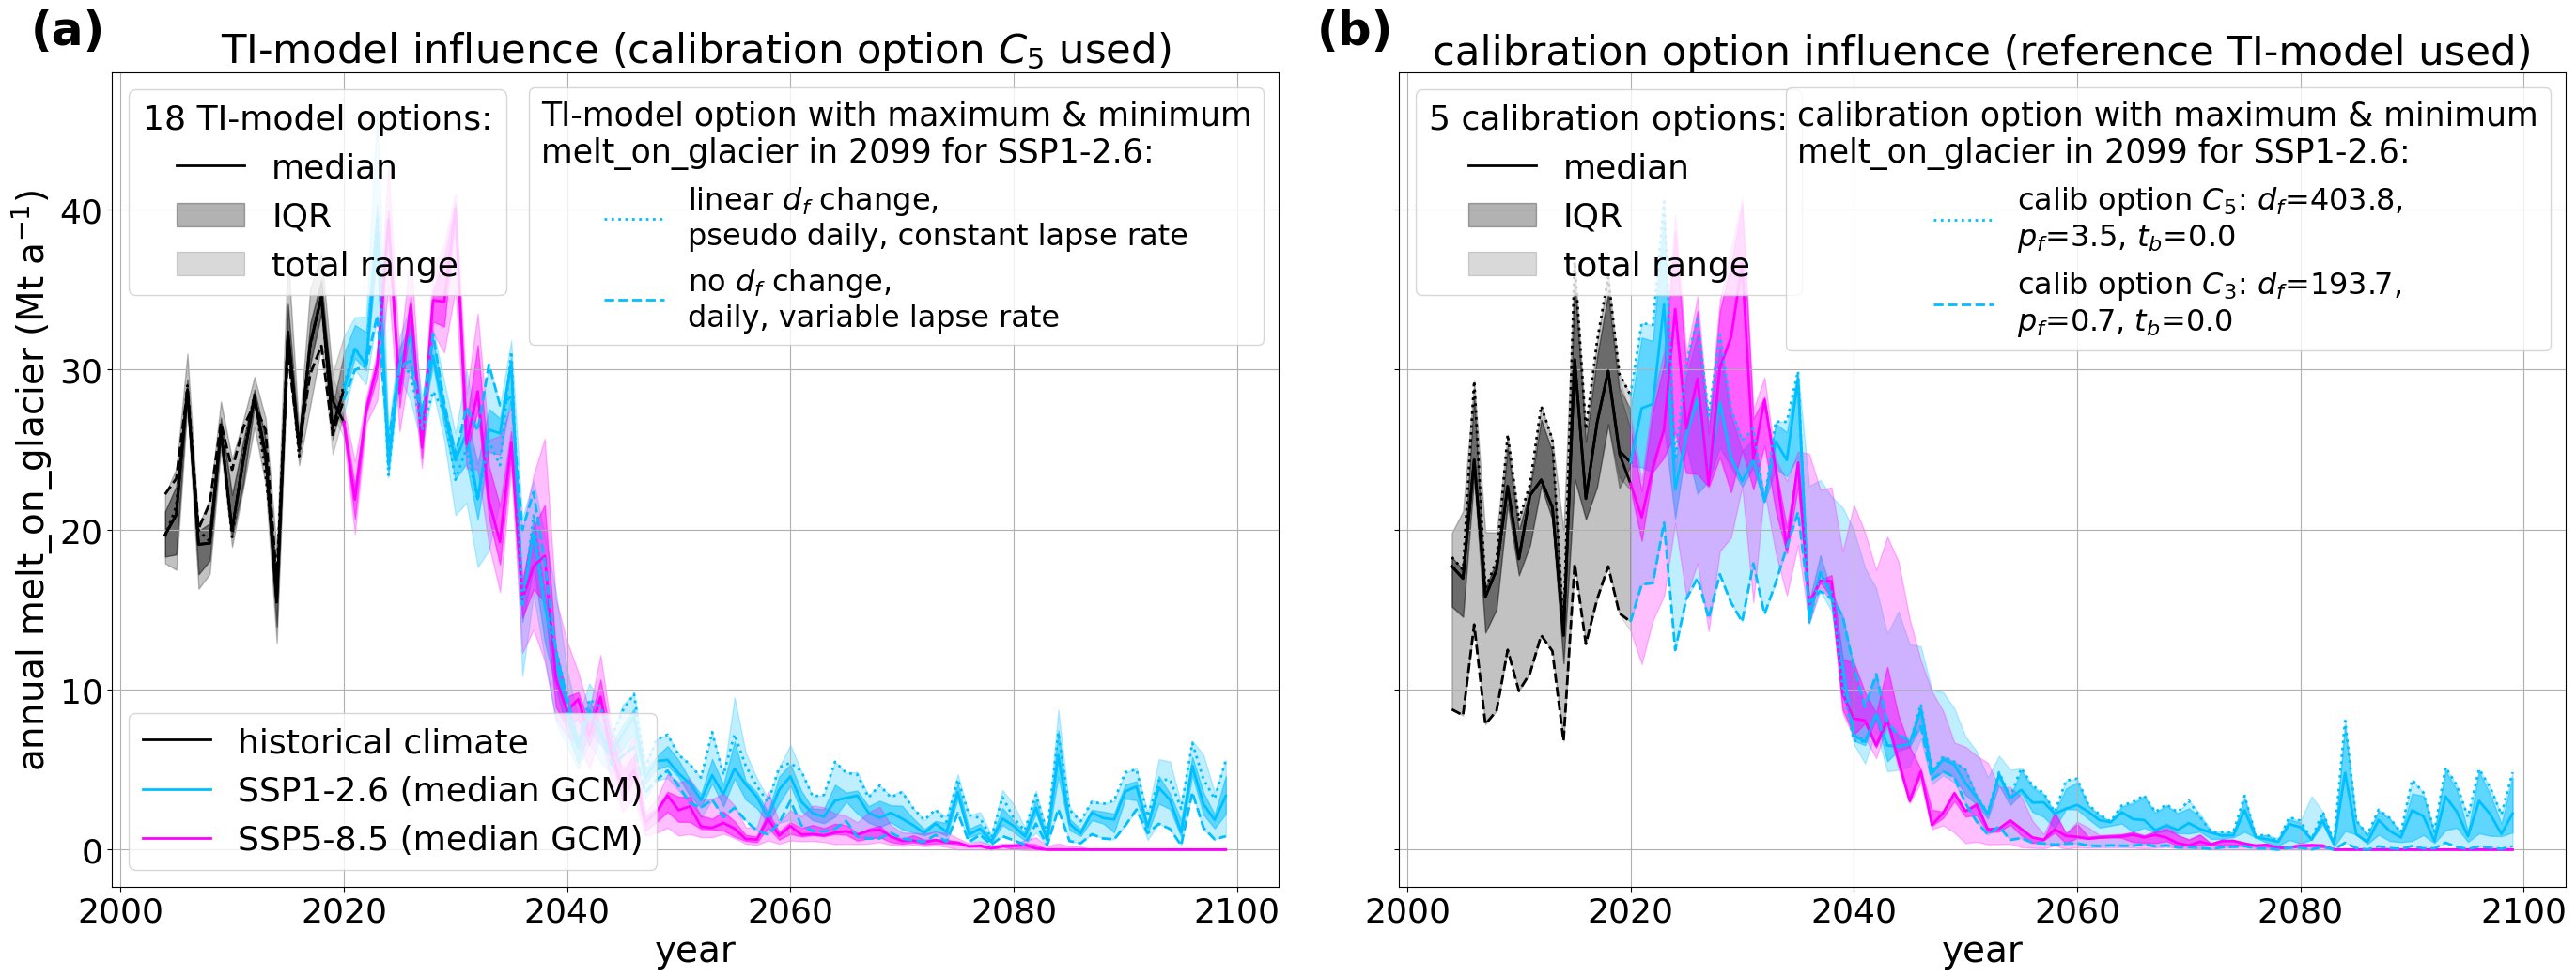

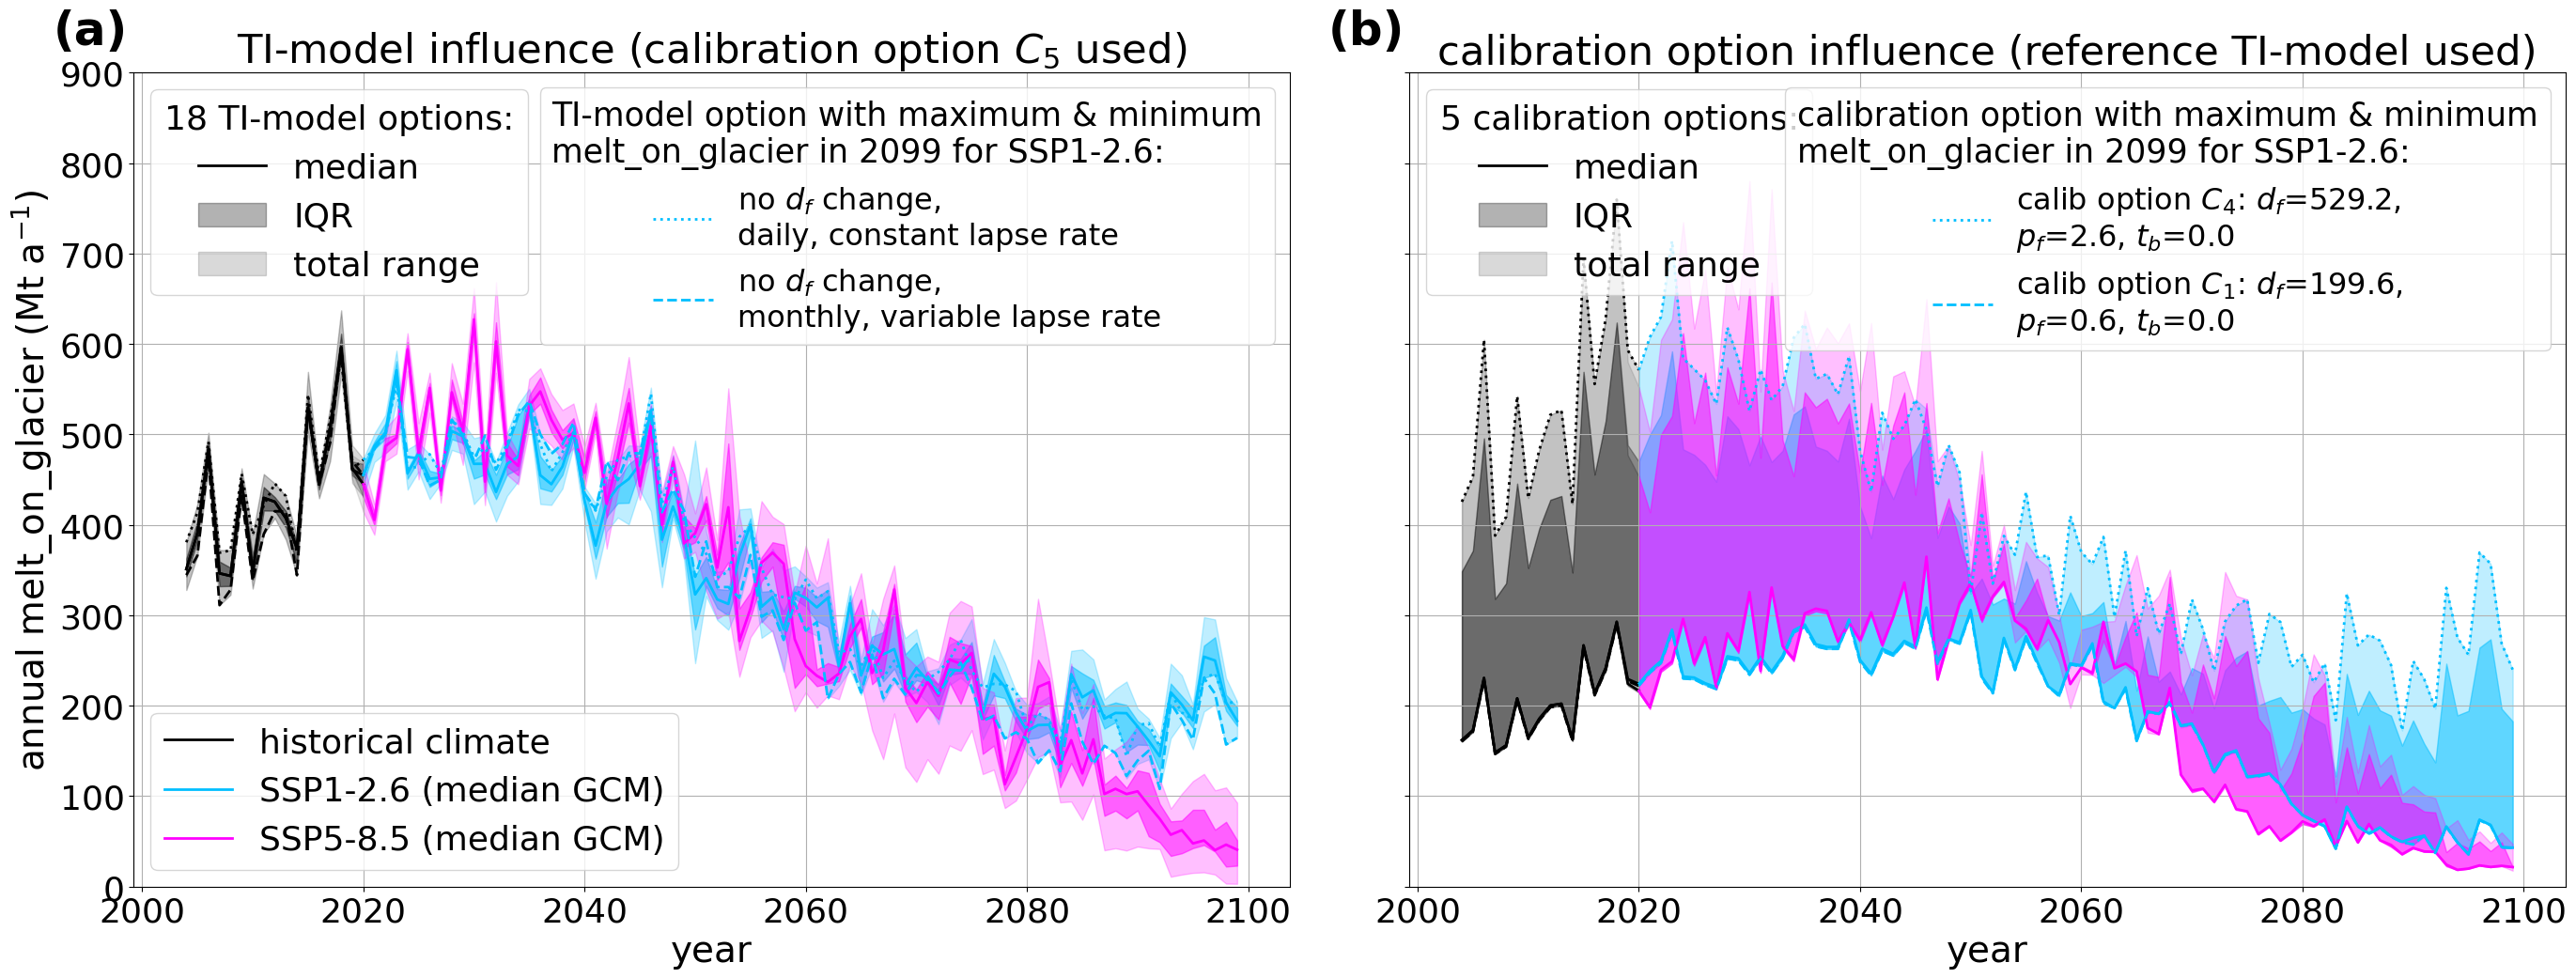

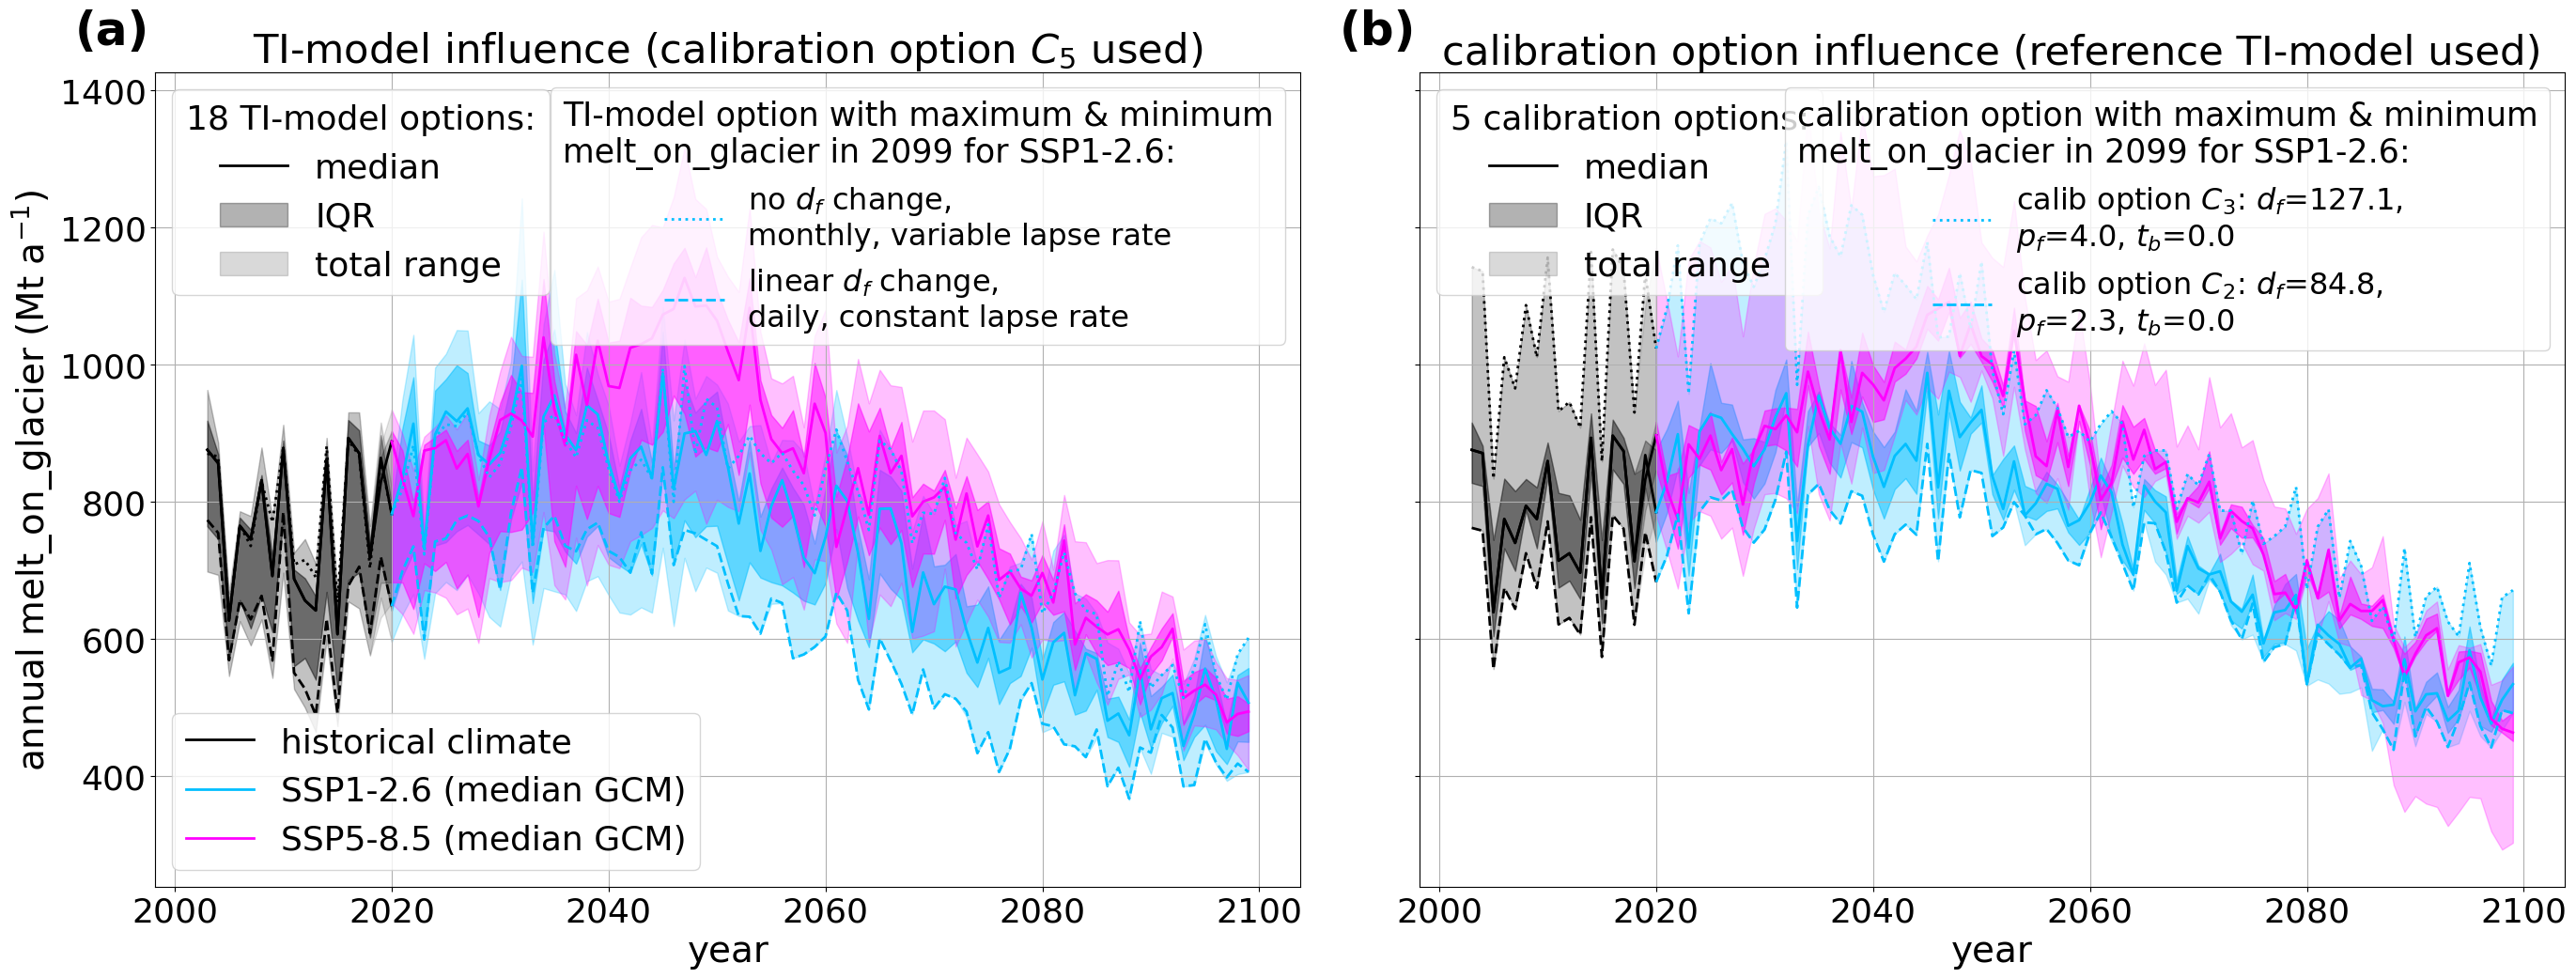

In [18]:

num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)', 5:'(f)', 6:'(g)',
            7:'(h)', 8:'(i)', 9:'(j)', 10:'(k)', 11:'(l)', 12:'(m)'} 

pd_params_stats = pd.read_csv(f'{data_path}/0_pd_params_stats_not_working_for_all.csv', index_col =0)

import sys
ensemble = 'median_gcm'
plt.rc('font', size=20)
plot_option = 'calib_influence'
plot_option = 'mb_model_influence'

num_text_x = -0.07
num_text_y = 1.035
ensemble = 'median_gcm'
plt.rc('font', size=26)
manuscript=True

for rgi in ['RGI60-11.00897','RGI60-11.01450', 'RGI60-06.00234']:
    fig, axss = plt.subplots(1,2, figsize=(28,11), sharey=True)
    if not manuscript:
        plt.suptitle(rgi)
    for j,plot_option in enumerate(['mb_model_influence', 'calib_influence']):
        axs = [axss[j]]
        if plot_option == 'calib_influence':
            if manuscript:
                axs[0].text(num_text_x,num_text_y, num_dict[j],weight='bold',
                    fontsize=36, transform=axs[0].transAxes)
                #axs[0].set_title('calibration option influence (reference TI-model used:\nno melt_f change, monthly, constant lapse rate)')
                axs[0].set_title('calibration option influence (reference TI-model used)') #':\nno melt_f change, monthly, constant lapse rate)')
            else:
                axs[0].set_title('calibration option influence (reference MB model of OGGM applied:\nno '+r'$d_f$ change, monthly, constant lapse rate)')
            # for the moment just select one MB options for simplification
            ds_merged = ds_merged_gcms.sel(rgi_id=rgi).median(dim='gcm')
            ds_merged = ds_merged.sel(mb_type='mb_monthly', grad_type = 'cte', melt_f_change='False')
        elif plot_option == 'mb_model_influence':
            if manuscript:
                axs[0].text(num_text_x,num_text_y, num_dict[j],weight='bold',
                    fontsize=36, transform=axs[0].transAxes)
                #axs[0].set_title('TI-model influence (calibration option (E) used)\n') #':\ngeodetic matched, prcp. fac dependent on winter precitation)')
                axs[0].set_title(r'TI-model influence (calibration option $C_5$ used)') #':\ngeodetic matched, prcp. fac dependent on winter precitation)')
            else:
                axs[0].set_title('TI-model influence (option (E) for calibration used:\ngeodetic matched, prcp. fac dependent on winter prcp.)')

            # instead just take the MEDIAN!!!
            ds_merged = ds_merged_gcms.sel(rgi_id=rgi).median(dim='gcm')
            ds_merged = ds_merged.sel(calib_type = 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb')
            
        #ds_merged_runoff = (ds_merged[runoff_vars[0]] + ds_merged[runoff_vars[1]] + 
        #                    ds_merged[runoff_vars[2]] + ds_merged[runoff_vars[3]])/1e9  # from m3 to Mt
        ds_merged_runoff_var = ds_merged[runoff_var]/1e9
        df_merged_vol_yr = ds_merged_runoff_var.sel(time=slice(2003,2099)).to_dataframe(name=runoff_var).reset_index()
            
            
        df_merged_vol_yr['mb_grad_type'] = df_merged_vol_yr['mb_type'] + '_' + df_merged_vol_yr['grad_type']
        df_merged_vol_yr['sfc_type'] = df_merged_vol_yr['melt_f_change']
        df_merged_vol_yr.loc[df_merged_vol_yr.melt_f_change!='False', 'sfc_type'] +='\nmonthly'
        fs = []
        for f in df_merged_vol_yr['mb_grad_type']:
            fs.append(f[3:])
        df_merged_vol_yr['mb_grad_type'] = fs
        df_vol_sum_yr = df_merged_vol_yr.groupby(['calib_type', 'mb_grad_type', 'sfc_type', 'ssp', 'time']).sum().copy().reset_index()
        
        
        # df_merged_vol_yr_median = df_merged_vol_yr.groupby(['mb_grad_type', 'ssp', 'calib_type', 'time']).median().reset_index()
        pd_params_stats_sel = pd_params_stats.loc[(pd_params_stats.mb_grad_type == 'mb_monthly_cte') & (pd_params_stats.sfc_type =='False')].loc[rgi]
        df_merged_vol_yr_median_a= df_merged_vol_yr.loc[df_merged_vol_yr.rgi_id==rgi].groupby(['mb_grad_type', 'ssp', 'calib_type',
                                                                                               'time', 'sfc_type']).median().reset_index()

        d_hef = df_merged_vol_yr.loc[(df_merged_vol_yr.rgi_id==rgi) & (df_merged_vol_yr.time == 2099)].groupby(['mb_grad_type', 'ssp',
                                                                                                                'calib_type', 'time',
                                                                                                                'melt_f_change']).median()[[runoff_var]]
        d_hef = d_hef.query("ssp=='ssp126'").sort_values(by=runoff_var)
        mb_grad_type_min, _, calib_min,_, sfc_type_min = d_hef.iloc[0].name
        mb_grad_type_max, _, calib_max,_, sfc_type_max = d_hef.iloc[-1].name
        
        
        for ssp in ds_merged.ssp.values:
            for period in ['hist', 'future']:
                if period == 'hist':
                    df_merged_vol_yr_median = df_merged_vol_yr_median_a.where(df_merged_vol_yr_median_a.time<=2020).dropna()
                    color_ssp_d = {'ssp126':'black', 'ssp585':'black'}
                    a = -0.1
                    if ssp == 'ssp585':
                        a = -0.15

                elif period == 'future':
                    a=0
                    df_merged_vol_yr_median = df_merged_vol_yr_median_a.where(df_merged_vol_yr_median_a.time>=2020).dropna()
                    #color_ssp_d = {'ssp126':'blue', 'ssp585':'red'}
                    color_ssp_d = {'ssp126':sns.color_palette(['deepskyblue'])[0], 'ssp585':'magenta'}

                d_merged_stats = df_merged_vol_yr_median.loc[df_merged_vol_yr_median.ssp==ssp].groupby('time').median().reset_index()
                d_q975 = df_merged_vol_yr_median.loc[df_merged_vol_yr_median.ssp==ssp].groupby('time').max().reset_index()[runoff_var]
                d_q025 = df_merged_vol_yr_median.loc[df_merged_vol_yr_median.ssp==ssp].groupby('time').min().reset_index()[runoff_var]

                d_q75 = df_merged_vol_yr_median.loc[df_merged_vol_yr_median.ssp==ssp].groupby('time').quantile([0.75]).reset_index()[runoff_var]
                d_q25 = df_merged_vol_yr_median.loc[df_merged_vol_yr_median.ssp==ssp].groupby('time').quantile([0.25]).reset_index()[runoff_var]
                d_merged_stats[f'median {runoff_var}'] = d_merged_stats[runoff_var].values
                d_merged_stats[f'interquartile range of {runoff_var}'] = d_q75-d_q25
                axs[0].plot(d_merged_stats.time, d_merged_stats[f'median {runoff_var}'], label=f'median',
                            color=color_ssp_d[ssp], linewidth=2)

                axs[0].fill_between(d_merged_stats.time, d_q75, d_q25, alpha = 0.5+2*a, label=f'IQR',
                                    color=color_ssp_d[ssp])    
                axs[0].fill_between(d_merged_stats.time, d_q975, d_q025, alpha = 0.25+a, label=f'total range', color=color_ssp_d[ssp])    

        handles, labels = axs[0].get_legend_handles_labels()
        if plot_option == 'calib_influence':
            order = [0,1,2]
            leg1=axs[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                               #bbox_to_anchor =(0.41,0.725), 
                               loc = 'upper left', title='5 calibration options:')
            order = [0,3,9]
            leg2=axs[0].legend([handles[idx] for idx in order],['historical climate',f'SSP1-2.6 (median GCM)',
                                                                f'SSP5-8.5 (median GCM)'],
                               #bbox_to_anchor =(1,0.725),
                               loc = 'lower left')
        elif plot_option == 'mb_model_influence':
            order = [0,1,2]
            leg1=axs[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], #bbox_to_anchor =(0.41,0.725),
                               loc = 'upper left',
                               title='18 TI-model options:')
            order = [0,3,9]
            if rgi == 'RGI60-06.00234':
                loc = 'lower left'
            else:
                loc = 'lower left'
            leg2=axs[0].legend([handles[idx] for idx in order],['historical climate', f'SSP1-2.6 (median GCM)',
                                                                f'SSP5-8.5 (median GCM)'],
                               #bbox_to_anchor =(1,0.725),
                               loc = loc)

        d_hef_timeline_a = df_merged_vol_yr.loc[df_merged_vol_yr.rgi_id==rgi].groupby(['mb_grad_type', 'ssp', 'calib_type',
                                                                                       'time', 'melt_f_change']).median().to_xarray()
        for period in ['hist', 'future']:
            if period == 'hist':
                d_hef_timeline = d_hef_timeline_a.where(d_hef_timeline_a.time<=2020).dropna(dim='time')
                color_sel = 'black'
            elif period == 'future':
                d_hef_timeline = d_hef_timeline_a.where(d_hef_timeline_a.time>=2020).dropna(dim='time')
                color_sel = sns.color_palette(['deepskyblue'])[0] 
            d_hef_timeline_max = d_hef_timeline.sel(ssp='ssp126').sel(calib_type=calib_max).sel(mb_grad_type = mb_grad_type_max).sel(melt_f_change=sfc_type_max) #(dim='mb_grad_type') #, 'calib_type', 'sfc_type'])
            if sfc_type_max == 'False':
                sfc_type_max_poster = f'no $d_f$ change, '
            elif sfc_type_max == 'linear':
                sfc_type_max_poster = f'linear $d_f$ change, '
            elif sfc_type_max == 'neg_exp':
                sfc_type_max_poster = f'neg. exp $d_f$ change, '
            else:
                sys.exit('need more options sfc_type_max_poster?? check code')
            if mb_grad_type_max == 'mb_monthly_cte' or mb_grad_type_max == 'monthly_cte':
                mb_grad_type_max_poster = '\nmonthly, constant lapse rate'
            elif mb_grad_type_max == 'real_daily_var_an_cycle':
                mb_grad_type_max_poster = '\ndaily, variable lapse rate'
            elif mb_grad_type_max == 'monthly_var_an_cycle':
                mb_grad_type_max_poster = '\nmonthly, variable lapse rate'
            elif mb_grad_type_max == 'pseudo_daily_fake_cte':
                mb_grad_type_max_poster = '\npseudo daily, constant lapse rate'
            elif mb_grad_type_max == 'pseudo_daily_fake_var_an_cycle':
                mb_grad_type_max_poster = '\npseudo daily, variable lapse rate'
            elif mb_grad_type_max == 'real_daily_cte':
                mb_grad_type_max_poster = '\ndaily, constant lapse rate'
            else:
                sys.exit('need more options mb_grad_type_max_poster')
            if calib_max == 'calib_geod_opt_winter_mb_approx_std':
                calib_max_poster = '(A) geodetic, winter MB & ~ interannual variability matched'
                if manuscript:
                    calib_max_poster = r'calib option $C_1$'
            elif calib_max == 'calib_geod_opt_winter_mb_temp_b_0':
                calib_max_poster = '(B) geodetic & winter MB matched'
                if manuscript:
                    calib_max_poster = r'calib option $C_2$' #'calib option (B)'
            elif calib_max == 'calib_geod_opt_std_temp_b_0':
                calib_max_poster = '(C) geodetic & interannaul variability matched'
                if manuscript:
                    calib_max_poster = r'calib option $C_3$'   ##'calib option (C)'
            elif calib_max == 'calib_only_geod_temp_b_0_pf_cte_via_std':
                calib_max_poster = '(D) geodetic matched, prcp. fac from median of option (c)'
                if manuscript:
                    calib_max_poster = r'calib option $C_4$'   #'calib option (D)'
            elif calib_max == 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb':
                calib_max_poster = '(E) geodetic matched, prcp. fac dependent on winter prcp.'
                if manuscript:
                    calib_max_poster = r'calib option $C_5$'    #'calib option (E)'
            if plot_option == 'calib_influence':
                pd_params_stats_sel_calib = pd_params_stats_sel.loc[pd_params_stats_sel.calib_type == calib_max]
                melt_f = pd_params_stats_sel_calib['melt_f'].values[0]
                prcp_fac = pd_params_stats_sel_calib['pf_opt'].values[0]
                temp_b = pd_params_stats_sel_calib['temp_bias'].values[0]
                label_max = (f'{calib_max_poster}: '+
                             r'$d_f$'+f'={melt_f:.1f},\n'+
                             r'$p_f$'+f'={prcp_fac:.1f}, '+r'$t_b$'+f'={temp_b:.1f}')            
            elif plot_option == 'mb_model_influence':
                label_max = f'{sfc_type_max_poster}{mb_grad_type_max_poster}'
            axs[0].plot(d_hef_timeline_max.time, d_hef_timeline_max[runoff_var],
                        color = color_sel, ls = ':', alpha = 1, lw=2,label=label_max)
            d_hef_timeline_min = d_hef_timeline.sel(ssp='ssp126').sel(calib_type=calib_min).sel(mb_grad_type = mb_grad_type_min).sel(melt_f_change=sfc_type_min) #(dim='mb_grad_type') #, 'calib_type', 'sfc_type'])
            if sfc_type_min == 'False':
                sfc_type_min_poster = f'no $d_f$ change, '
            elif sfc_type_min == 'linear':
                sfc_type_min_poster = f'linear $d_f$ change, '
            elif sfc_type_min == 'neg_exp':
                sfc_type_min_poster = f'neg. exp $d_f$ change, '
            else:
                sys.exit('need more options sfc_type_min_poster')
            if mb_grad_type_min == 'mb_monthly_cte' or mb_grad_type_min == 'monthly_cte':
                mb_grad_type_min_poster = '\nmonthly, constant lapse rate'
            elif mb_grad_type_min == 'real_daily_var_an_cycle':
                mb_grad_type_min_poster = '\ndaily, variable lapse rate'
            elif mb_grad_type_min == 'monthly_var_an_cycle':
                mb_grad_type_min_poster = '\nmonthly, variable lapse rate'
            elif mb_grad_type_min == 'real_daily_cte':
                mb_grad_type_min_poster = '\ndaily, constant lapse rate'
            elif mb_grad_type_min == 'pseudo_daily_fake_cte':
                mb_grad_type_min_poster = '\npseudo daily, constant lapse rate'
            elif mb_grad_type_min == 'pseudo_daily_fake_var_an_cycle':
                mb_grad_type_min_poster = '\npseudo daily, variable lapse rate'
            else:
                sys.exit('need more options mb_grad_type_min_poster')

            if calib_min == 'calib_geod_opt_winter_mb_approx_std':
                calib_min_poster = '(A) geodetic, winter MB & ~ interannual variability matched'
                if manuscript:
                    calib_min_poster = r'calib option $C_1$'   #'calib option (A)'
            elif calib_min == 'calib_geod_opt_winter_mb_temp_b_0':
                calib_min_poster = '(B) geodetic & winter MB matched'
                if manuscript:
                    calib_min_poster = r'calib option $C_2$'   #'calib option (B)'
            elif calib_min == 'calib_geod_opt_std_temp_b_0':
                calib_min_poster = '(C) geodetic & interannaul variability matched'
                if manuscript:
                    calib_min_poster = r'calib option $C_3$'   #'calib option (C)'
            elif calib_min == 'calib_only_geod_temp_b_0_pf_cte_via_std':
                calib_min_poster = '(D) geodetic matched, prcp. fac from median of option (C)'
                if manuscript:
                    calib_min_poster = r'calib option $C_4$'   #'calib option (D)'
            elif calib_min == 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb':
                calib_min_poster = '(E) geodetic matched, prcp. fac dependent on winter prcp.'
                if manuscript:
                    calib_min_poster = r'calib option $C_5$'   #'calib option (E)'
            if plot_option == 'calib_influence':
                pd_params_stats_sel_calib = pd_params_stats_sel.loc[pd_params_stats_sel.calib_type == calib_min]
                melt_f = pd_params_stats_sel_calib['melt_f'].values[0]
                prcp_fac = pd_params_stats_sel_calib['pf_opt'].values[0]
                temp_b = pd_params_stats_sel_calib['temp_bias'].values[0]
                label_min = (f'{calib_min_poster}: '+
                             r'$d_f$'+f'={melt_f:.1f},\n'+
                             r'$p_f$'+f'={prcp_fac:.1f}, '+r'$t_b$'+f'={temp_b:.1f}')
            elif plot_option == 'mb_model_influence':
                label_min = f'{sfc_type_min_poster}{mb_grad_type_min_poster}'
            axs[0].plot(d_hef_timeline_min.time, d_hef_timeline_min[runoff_var],
                        color = color_sel, ls = '--', alpha = 1, lw=2,label=label_min)
            
            

        handles, labels = axs[0].get_legend_handles_labels()
        if plot_option == 'calib_influence':
            legend_title = 'calibration option with maximum & minimum\n'+f'{runoff_var} in 2099 for SSP1-2.6:'
        elif plot_option == 'mb_model_influence':
            legend_title = 'TI-model option with maximum & minimum\n'+f'{runoff_var} in 2099 for SSP1-2.6:'

        leg3 = axs[0].legend(handles[-2:], labels[-2:],
                                 loc = 'upper right',  #bbox_to_anchor =(1,0.725),
                             title = legend_title, title_fontsize=25, fontsize=23)

        axs[0].add_artist(leg1)
        if plot_option != 'calib_influence':
            axs[0].add_artist(leg2)


        axs[0].grid()
        #axs[1].grid()
        if plot_option != 'calib_influence':
            axs[0].set_ylabel(f'annual {runoff_var} '+r'(Mt a$^{-1}$)', fontsize=28)
        else:
            axs[0].set_ylabel(f'annual {runoff_var} '+r'(Mt a$^{-1}$)', fontsize=28, alpha=0)

        axs[0].set_xlabel('year', fontsize=28)

        plt.tight_layout()
        if rgi == 'RGI60-11.01450':
            plt.ylim([0,900])
            
        if rgi == 'RGI60-11.01450':
            plt.savefig(f'{fig_path}/figures_supplements/fig_S14_only_{runoff_var}_ti_model_calib_option_influence_{rgi}.pdf')
        elif rgi == 'RGI60-11.00897':
            plt.savefig(f'{fig_path}/figures_supplements/fig_S16_only_{runoff_var}_ti_model_calib_option_influence_{rgi}.pdf')
        else:
            pass


----

### Additional plots and analysis that did not make it into the manuscript or supplements
- still a bit unsorted 

In [49]:
import sys
ensemble = 'median_gcm'
plt.rc('font', size=20)
plot_option = 'calib_influence'
#plot_option = 'mb_model_influence'
col_pal_ssp = sns.color_palette(['deepskyblue', 'red'])
plot_option = 'calib_influence'
ds_merged = ds_merged_gcms.median(dim='gcm')

ds_m = ds_merged.sel(time=slice(2020,2099,79)).copy() #.to_dataframe().reset_index() 
len_rgis_run = len(ds_m.rgi_id)
pd_len_rgis = pd.DataFrame(columns=['ssp', 'time', 'still_exist', 'all'])
j = 0
working_dict = {}
for time in [2020, 2099]:
    for ssp in ['ssp126', 'ssp585']:
        # any: it is sufficient that there is for one MB model type or calib type a 0 value -> then it is dropped
        working_dict[f'{time}_{ssp}'] = ds_m.sel(ssp=ssp).sel(time=time).where(ds_m.sel(ssp=ssp).sel(time=str(time)).volume>0.001).dropna(dim='rgi_id', how='any').rgi_id.values
        len_rgis_run_t = len(ds_m.sel(ssp=ssp).sel(time=time).where(ds_m.sel(ssp=ssp).sel(time=str(time)).volume>0.001).dropna(dim='rgi_id', how='any').rgi_id)
        pd_len_rgis.loc[j] = np.array([ssp, time, len_rgis_run_t, len_rgis_run])
        j += 1
pd_len_rgis['still_exist'] = pd_len_rgis['still_exist'].astype(int)

#axs[0].set_title('calibration option influence (default MB model of OGGM applied:\nno melt_f change, monthly, constant lapse rate)')
# for the moment just select one MB options for simplification
#ds_merged = ds_merged.sel(mb_type='mb_monthly', grad_type = 'cte', melt_f_change='False')
#axs[0].set_title('MB model influence (option (e) for calibration used:\ngeodetic matched, prcp. fac dependent on winter prcp.)')
# instead just take the MEDIAN!!!
calib_type_to_compare = calib_types[0]
print(calib_types[0])
# .sel(rgi_id=rgis_not_melting)
ds_merged_runoff = (ds_merged[runoff_vars[0]] + ds_merged[runoff_vars[1]] + 
                            ds_merged[runoff_vars[2]] + ds_merged[runoff_vars[3]])/1e9  # from m3 to Mt
ds_merged_runoff = ds_merged_runoff.sel(time=slice(2003,2099))


ref_runoff_option = ds_merged_runoff.sel(calib_type=calib_type_to_compare)
ds_merged_vs_ref_each_calib_option = ds_merged_runoff/ref_runoff_option 
ds_merged_vs_ref_each_calib_option = ds_merged_vs_ref_each_calib_option.where(ds_merged_vs_ref_each_calib_option < np.inf,
                                                                              drop=True) #, ds_merged_vs_ref_each_option.values)
ds_merged_vs_ref_each_calib_option = ds_merged_vs_ref_each_calib_option.where(ds_merged_vs_ref_each_calib_option >0,
                                                                              drop=True) #, ds_merged_vs_ref_each_option.values)

### also estimate just the melt_on_glacier part
ds_merged_runoff_melt_on_glacier = ds_merged.sel(time=slice(2003,2099)).melt_on_glacier/1e9

ref_runoff_option_melt_on_glacier = ds_merged_runoff_melt_on_glacier.sel(calib_type=calib_type_to_compare)
ds_merged_vs_ref_each_calib_option_melt_on_glacier = ds_merged_runoff_melt_on_glacier/ref_runoff_option_melt_on_glacier 
ds_merged_vs_ref_each_calib_option_melt_on_glacier = ds_merged_vs_ref_each_calib_option_melt_on_glacier.where(ds_merged_vs_ref_each_calib_option_melt_on_glacier < np.inf,
                                                                              drop=True) #, ds_merged_vs_ref_each_option.values)
ds_merged_vs_ref_each_calib_option_melt_on_glacier = ds_merged_vs_ref_each_calib_option_melt_on_glacier.where(ds_merged_vs_ref_each_calib_option >0,
                                                                              drop=True) #, ds_merged_vs_ref_each_option.values)

# find out those glaciers that did not run for all options
pd_glac_working_hydro = ds_merged_vs_ref_each_calib_option.sel(time=slice(2020,2039)).to_dataframe(name='runoff').reset_index()
not_working_2020_2039 = pd_glac_working_hydro.loc[np.where(pd_glac_working_hydro.isna())[0]].rgi_id.unique()
pd_glac_working_hydro = ds_merged_vs_ref_each_calib_option.sel(time=slice(2080,2099)).to_dataframe(name='runoff').reset_index()
not_working_2080_2099 = pd_glac_working_hydro.loc[np.where(pd_glac_working_hydro.isna())[0]].rgi_id.unique()
assert np.all(not_working_2080_2099 == not_working_2020_2039)
rgi_working_calib = list(ds_merged_vs_ref_each_calib_option.rgi_id.values)
for r in not_working_2080_2099:
    rgi_working_calib.remove(r)
print(len(rgi_working_calib))

calib_geod_opt_winter_mb_approx_std


just a test plot:

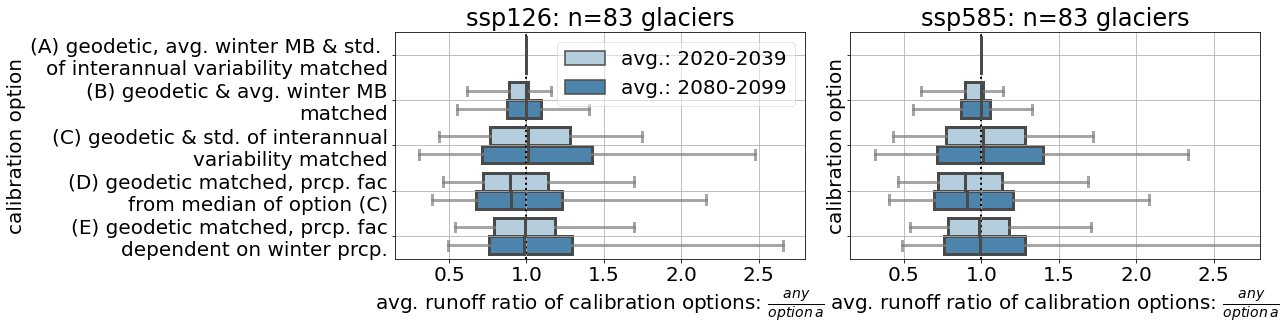

In [25]:
ds_merged_vs_ref_each_calib_option = ds_merged_vs_ref_each_calib_option.sel(rgi_id = rgi_working_calib)
calib_types_nice = ['(A) geodetic, avg. winter MB & std. \nof interannual variability matched',
                    '(B) geodetic & avg. winter MB\nmatched','(C) geodetic & std. of interannual\nvariability matched',
                     '(D) geodetic matched, prcp. fac\nfrom median of option (C)',
                    '(E) geodetic matched, prcp. fac\ndependent on winter prcp.']
fig, axs = plt.subplots(1,2, figsize=(18,5), sharey=True)
#ds_spread['volume'] = np.abs(ds_spread.volume-1) #ds_spread.volume.
for ax, ssp in zip(axs, ['ssp126', 'ssp585']):
    ds= ds_merged_vs_ref_each_calib_option.sel(time=slice(2020,2039)).mean(dim='time').sel(ssp=ssp).to_dataframe(name='runoff').reset_index()
    ds['time'] = 'avg.: 2020-2039'
    
    ds2= ds_merged_vs_ref_each_calib_option.sel(time=slice(2080,2099)).mean(dim='time').sel(ssp=ssp).to_dataframe(name='runoff').reset_index()
    ds2['time'] = 'avg.: 2080-2099'
    ds = pd.concat([ds,ds2])
    f = sns.boxplot(y='calib_type', x='runoff',
                    hue='time', data=ds, palette='Blues', #kind='box',
                fliersize=0, whis=[5,95],
                #col = 'time',
                linewidth=3, 
                #aspect=1.6, #order = calib_types,
                #legend_out=False,
                saturation=0.7, ax=ax,
               capprops={'color':'grey', 'alpha':0.7},
            whiskerprops={'color':'grey', 'alpha':0.7}) #, grid=True)
    ax.legend(loc='upper right', framealpha = 0.5)
    ax.grid()
    if ax != axs[0]:
        ax.set_ylabel('')
        ax.legend_.remove()
    ax.set_title(f'{ssp}: n={len(ds.rgi_id.unique())} glaciers')
    ax.set_xlabel(r'avg. runoff ratio of calibration options: $\frac{any}{option\,a}$')
    ax.axvline(1, linewidth=2, ls=':', color = 'black')
    xlim1 = 2.8
    ax.set_xlim([0.15, xlim1]) # 0.01
    ax.set_yticklabels(calib_types_nice)
    ax.set_ylabel('calibration option')
plt.tight_layout()

#### make the equivalent runoff timodel calib option comparison plot:

In [53]:
ds_a = ds_merged_runoff.sel(time=slice(2030,2049)).mean(dim='time')
ds_a.coords['time'] = '2030-2049'
ds_b = ds_merged_runoff.sel(time=slice(2080,2099)).mean(dim='time')
ds_b.coords['time'] = '2080-2099'


### also estimate just the melt_on_glacier part
ds_a_melt_on_glacier = ds_merged_runoff_melt_on_glacier.sel(time=slice(2030,2049)).mean(dim='time')
ds_a_melt_on_glacier.coords['time'] = '2030-2049'
ds_b_melt_on_glacier = ds_merged_runoff_melt_on_glacier.sel(time=slice(2080,2099)).mean(dim='time')
ds_b_melt_on_glacier.coords['time'] = '2080-2099'

ds_m = ds_merged.sel(time=slice(2030,2099,69)).copy() #.to_dataframe().reset_index() 
len_rgis_run = len(ds_m.rgi_id)
pd_len_rgis = pd.DataFrame(columns=['ssp', 'time', 'still_exist', 'all'])
j = 0
working_dict = {}
for time in [2030, 2099]:
    for ssp in ['ssp126', 'ssp585']:
        # any: it is sufficient that there is for one MB model type or calib type a 0 value -> then it is dropped
        working_dict[f'{time}_{ssp}'] = list(ds_m.sel(ssp=ssp).sel(time=time).where(ds_m.sel(ssp=ssp).sel(time=str(time)).volume>0.0001).dropna(dim='rgi_id', how='any').rgi_id.values)
        len_rgis_run_t = len(ds_m.sel(ssp=ssp).sel(time=time).where(ds_m.sel(ssp=ssp).sel(time=str(time)).volume>0.001).dropna(dim='rgi_id', how='any').rgi_id)
        pd_len_rgis.loc[j] = np.array([ssp, time, len_rgis_run_t, len_rgis_run])
        j += 1
pd_len_rgis['still_exist'] = pd_len_rgis['still_exist'].astype(int)

# these are those glacies for ssp126 and time=2100 for volume projections --> there are two other glaciers that gained mass just
# in the year 2100, let's add them aswell for better comparability 
testi = ['RGI60-08.01779', 'RGI60-13.08624', 'RGI60-18.01130',
       'RGI60-01.04591', 'RGI60-06.00236', 'RGI60-13.18096',
       'RGI60-08.00188', 'RGI60-01.01390', 'RGI60-17.02128',
       'RGI60-08.02650', 'RGI60-06.00234', 'RGI60-08.02017',
       'RGI60-11.00897', 'RGI60-08.02384', 'RGI60-08.00987',
       'RGI60-08.00449', 'RGI60-02.17369', 'RGI60-08.01126',
       'RGI60-08.03416', 'RGI60-01.09162', 'RGI60-08.01258',
       'RGI60-08.01657', 'RGI60-05.00446', 'RGI60-11.02773',
       'RGI60-10.01737', 'RGI60-08.01217', 'RGI60-08.01598',
       'RGI60-08.00312', 'RGI60-08.02666', 'RGI60-11.02679',
       'RGI60-13.05504', 'RGI60-06.00238', 'RGI60-11.02704',
       'RGI60-12.01132', 'RGI60-01.00570', 'RGI60-08.00287',
       'RGI60-08.01286', 'RGI60-05.20030', 'RGI60-02.02631',
       'RGI60-11.01450', 'RGI60-02.17612', 'RGI60-13.06361',
       'RGI60-10.01708', 'RGI60-10.01732', 'RGI60-12.00161']

for t in testi:
    if t not in working_dict[f'2099_ssp126']:
        print(t)
        working_dict[f'{time}_{ssp}'].append(t)
        
pd_len_rgis

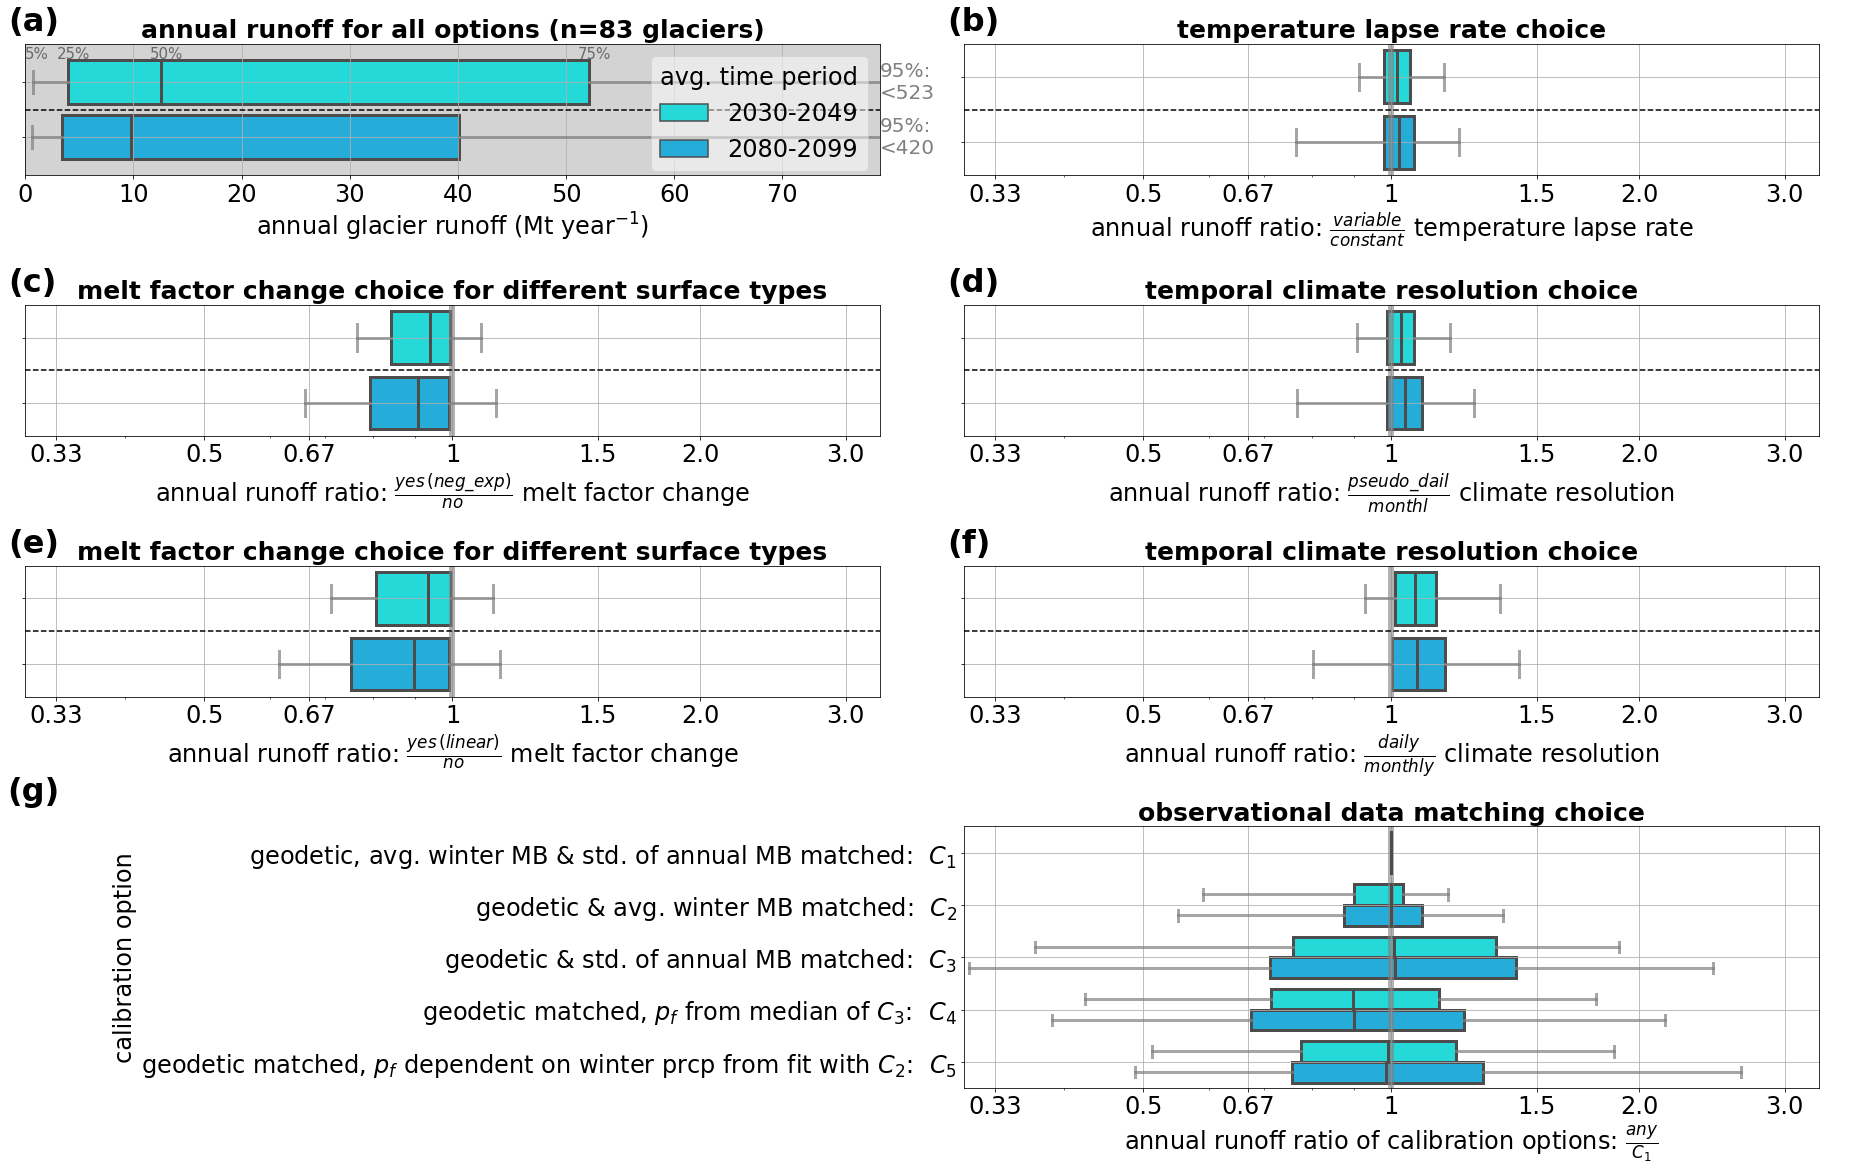

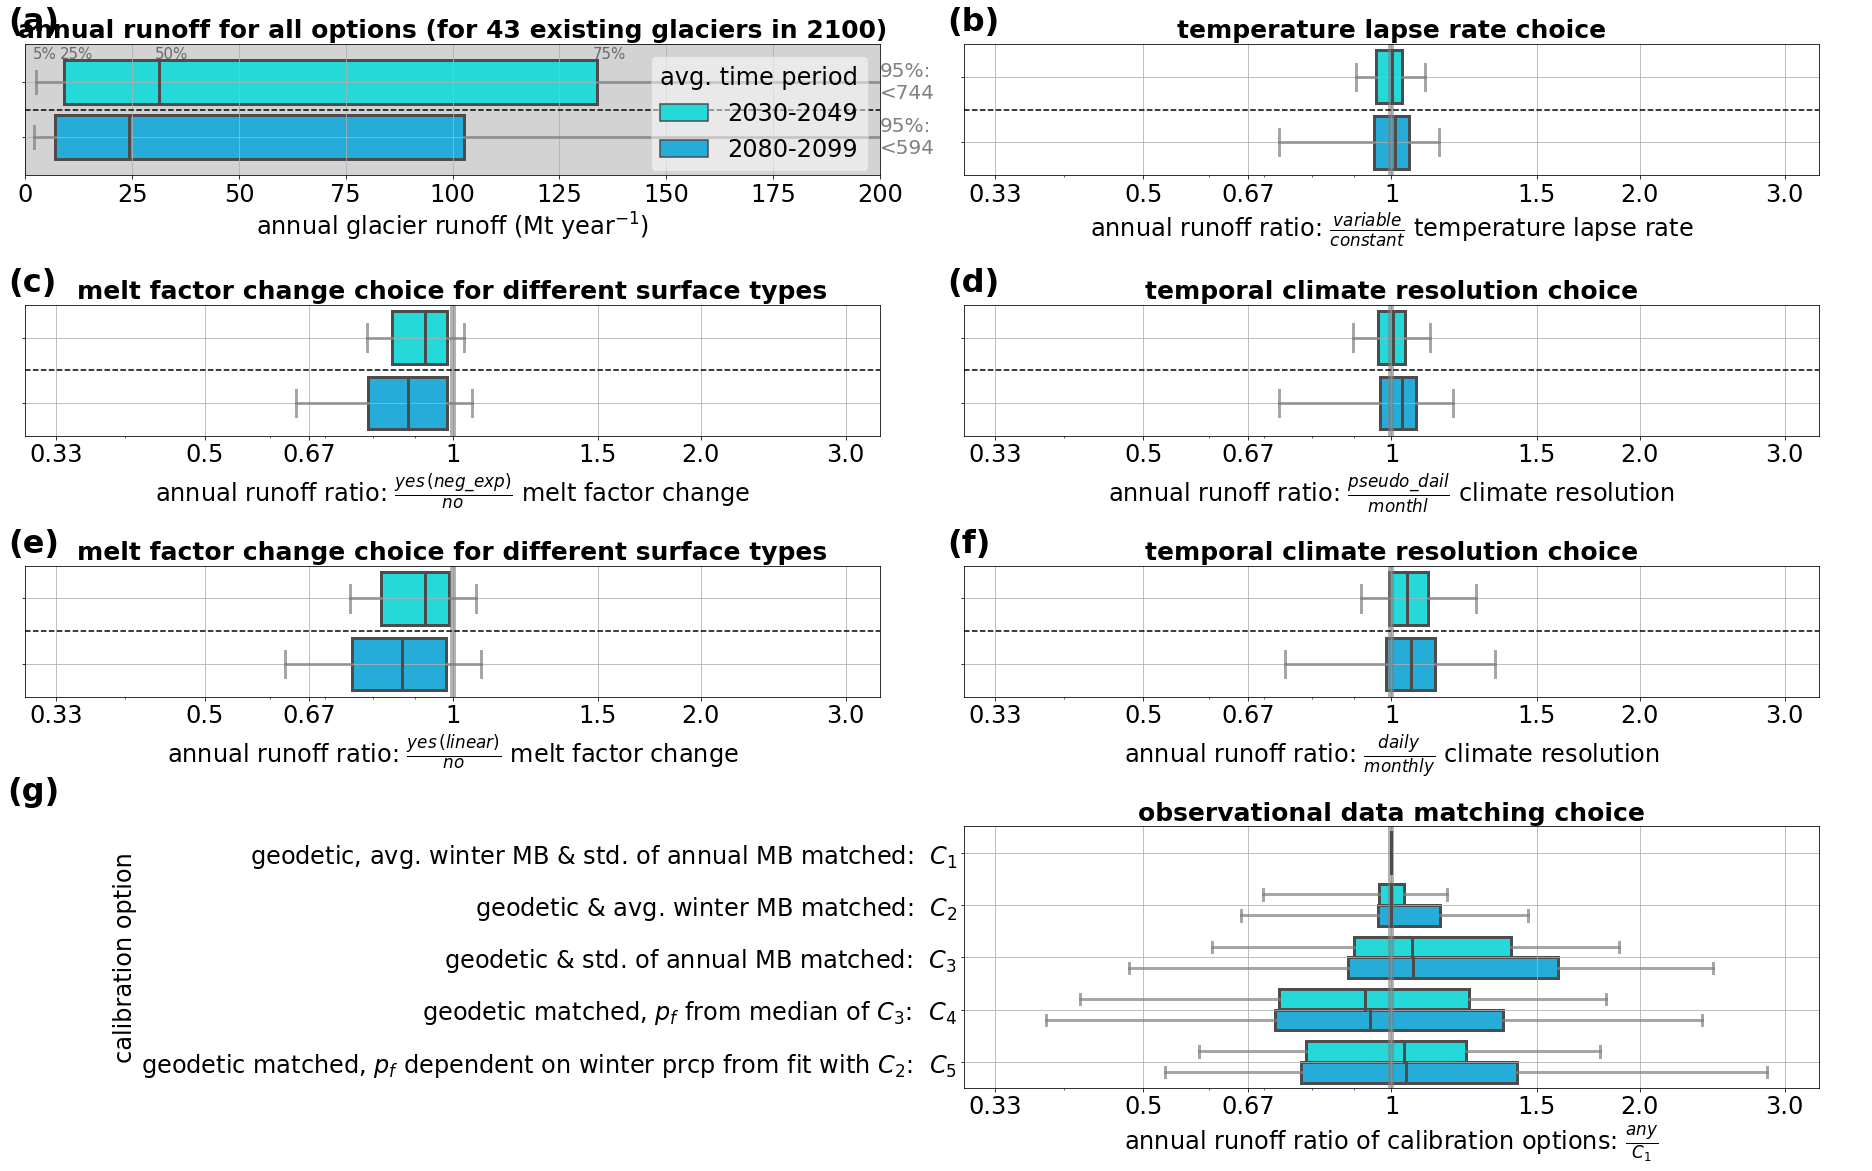

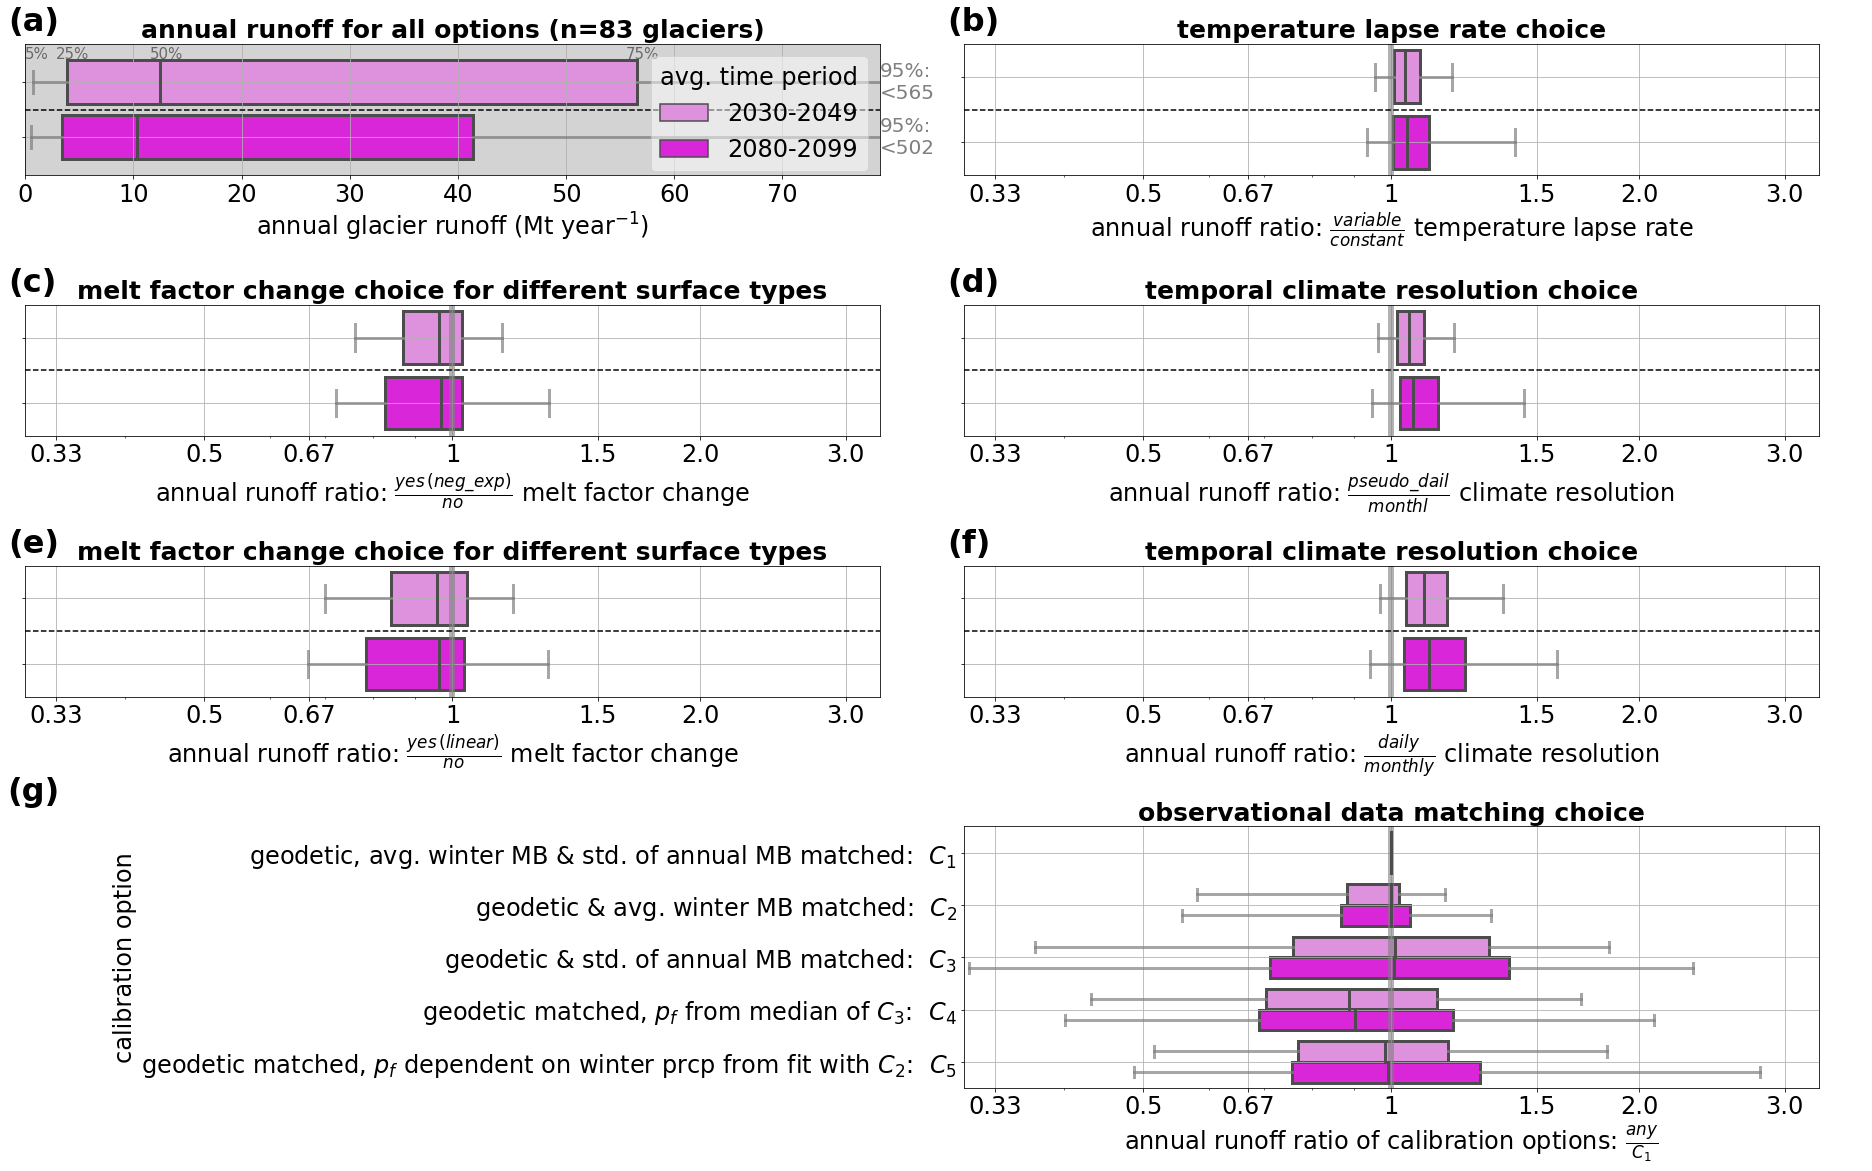

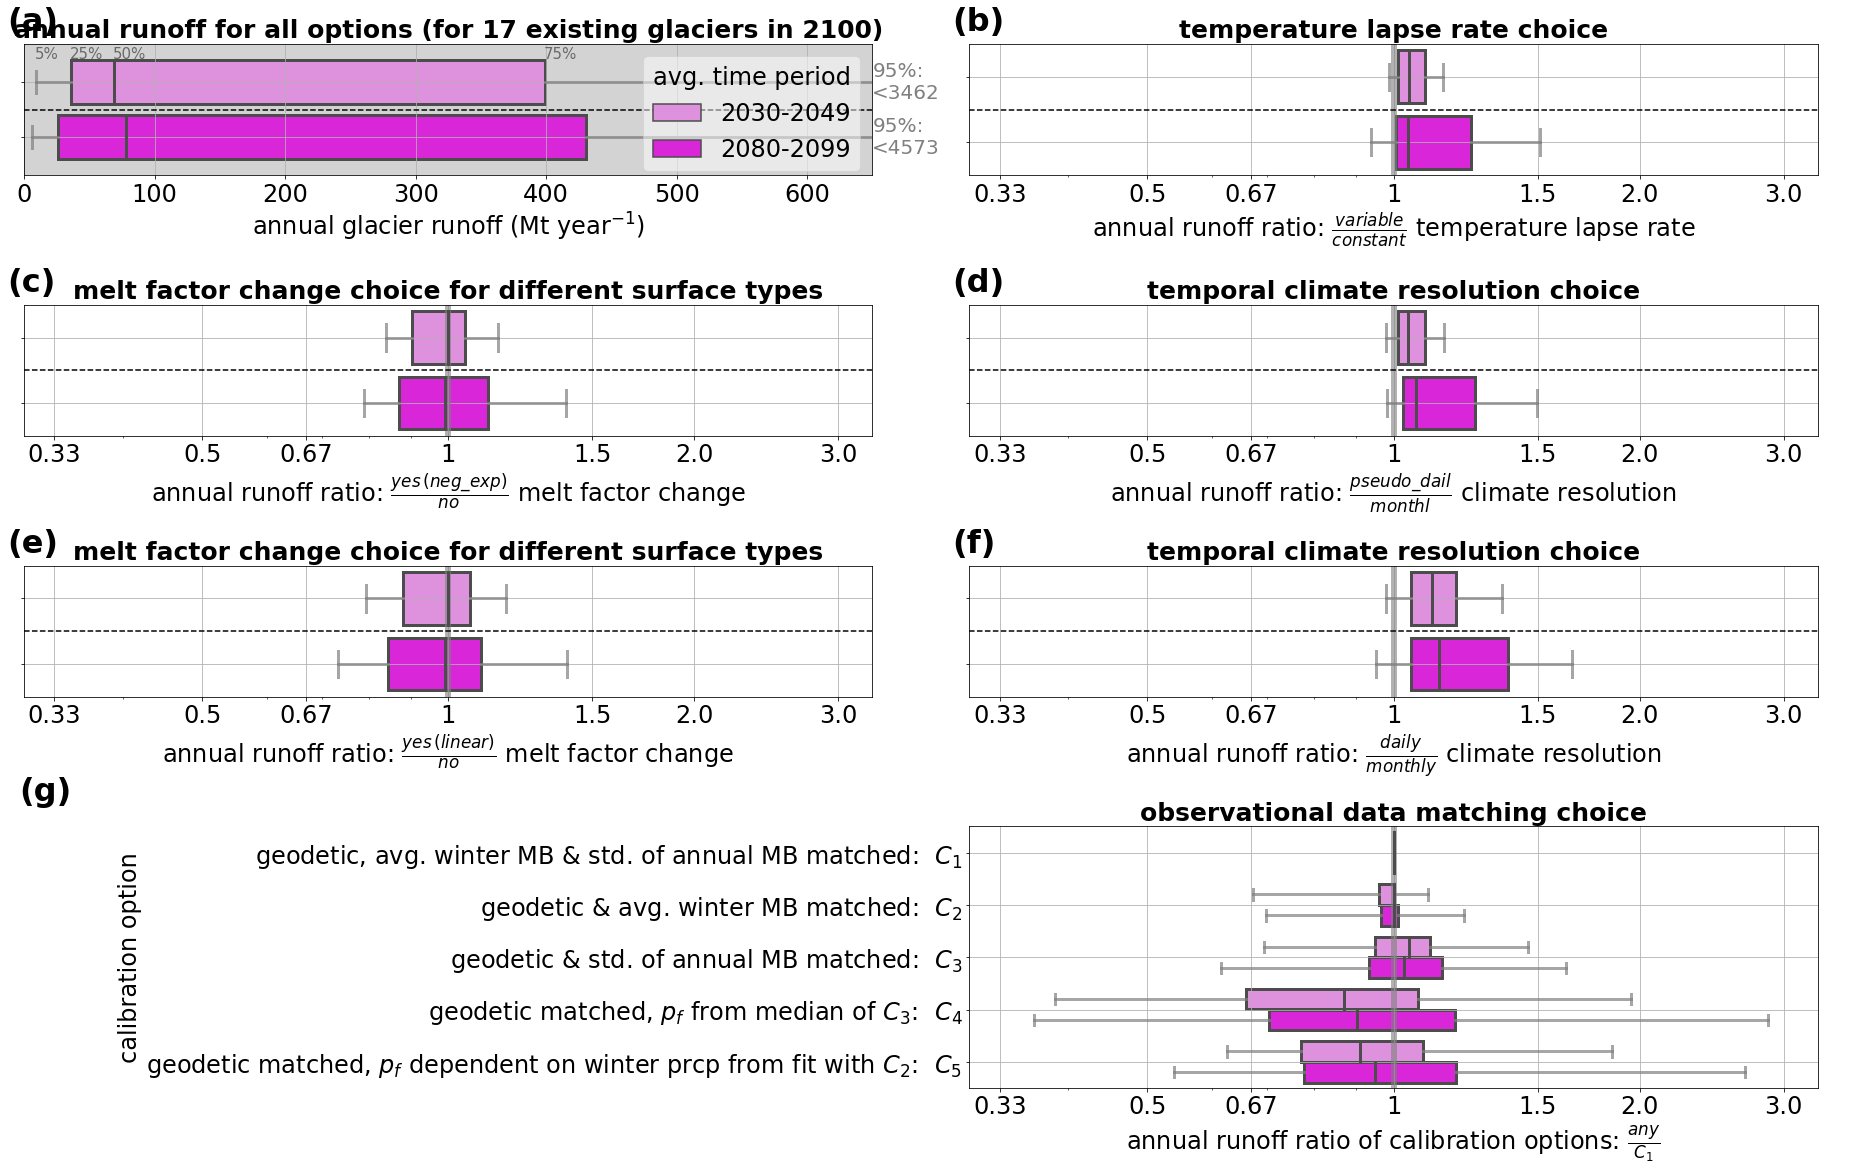

In [36]:
# overall MB and calib option influence
plt.rc('font', size=24)

num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)', 5: '(f)', 6: '(g)'}

# logarithmic scale because of ratios ...
xlim0 = 0.303
xlim1 = 3.3
fs_num_dict = 32
num_text_x = -0.02
num_text_y = 1.1

violin = False
all_same_glaciers = True ## True
#for all_same_glaciers in [True]: ## False
for ssp in ['ssp126', 'ssp585']:
    for only_still_existing_glaciers_in_2100 in [False, True]:
        ds_merged_runoff_avg = xr.concat([ds_a,ds_b], dim = 'time').copy()
        ds_merged_runoff_avg = ds_merged_runoff_avg.sel(rgi_id = rgi_working_calib)
        if only_still_existing_glaciers_in_2100:
            ds_merged_runoff_avg = ds_merged_runoff_avg.sel(rgi_id = working_dict[f'2099_{ssp}'])
        if not all_same_glaciers and ssp =='ssp126':
            ssp = np.NaN
        elif not all_same_glaciers and ssp == 'ssp126':
            break

        if all_same_glaciers:
            #pd_all = (100*(ds_merged.sel(time=slice(2040,2100,60))/ds_merged.sel(time=2020))).sel(rgi_id = working_dict[f'2100_{ssp}']).sel(ssp=ssp).to_dataframe().reset_index() #.groupby(['ssp', 'calib_type', 'time']).quantile([0.25,0.5,0.75]).round(2)).reset_index()
            #ds_m = ds_merged.sel(time=slice(2040,2100,60)).copy().sel(rgi_id = working_dict[f'2100_{ssp}']).sel(ssp=ssp)
            pd_all = ds_merged_runoff_avg.sel(ssp=ssp).to_dataframe(name='runoff').reset_index() #.groupby(['ssp', 'calib_type', 'time']).quantile([0.25,0.5,0.75]).round(2)).reset_index()
            ds_m = ds_merged_runoff_avg.sel(ssp=ssp).copy()
            if ssp == 'ssp126':
                col_pal_ssp = sns.color_palette(['cyan','deepskyblue'])
            else:
                #col_pal_ssp = sns.color_palette(['magenta'])
                col_pal_ssp = sns.color_palette(['violet','magenta'])


        #pd_all['time'] = pd_all.time.astype(int).astype(str)

        c = 2
        r = 9
        if ssp == 'ssp126':
            plt.subplots(figsize=(26,16), squeeze=False)
        else:
            plt.subplots(figsize=(26,16), squeeze=False)
        

        ax0 = plt.subplot2grid((r, c), (0, 0), rowspan=2)
        ax2 = plt.subplot2grid((r, c), (0, 1), rowspan=2)
        
        
        ax1 = plt.subplot2grid((r, c), (2, 0), rowspan=2)
        ax1b = plt.subplot2grid((r, c), (4, 0), rowspan=2)

        ax3 = plt.subplot2grid((r, c), (2, 1), rowspan=2)
        ax3b = plt.subplot2grid((r, c), (4, 1), rowspan=2)

        ax4 = plt.subplot2grid((r, c), (6, 1), rowspan=3)
            
        for option_v in ['grad_type', 'mb_type_pseudo_daily','mb_type_daily','melt_f_change_neg_exp', 'melt_f_change_linear']:
            if option_v == 'melt_f_change_linear':
                tips = ['linear']
                default = 'False'
                option = 'melt_f_change'
            elif option_v == 'grad_type':
                tips = ['var_an_cycle']
                default = 'cte'
                option = option_v
            elif option_v == 'mb_type_daily':
                tips = ['mb_real_daily']
                default = 'mb_monthly'
                option = 'mb_type'
            elif option_v == 'melt_f_change_neg_exp':
                tips = ['neg_exp']
                default = 'False'
                option = 'melt_f_change'
            elif option_v == 'mb_type_pseudo_daily':
                tips = ['mb_pseudo_daily']
                default = 'mb_monthly'
                option = 'mb_type'
            for j, tip in enumerate(tips):
                if 'melt_f_change' in option_v:
                    t = 'melt factor change choice for different surface types'
                    if option_v == 'melt_f_change_linear':
                        ax = ax1b
                    else:
                        ax = ax1
                    ref_v_opt = ds_merged_runoff_avg.sel(melt_f_change = default)
                elif option_v == 'grad_type':
                    t = 'temperature lapse rate choice'
                    #ax = axs[1][0]
                    ax = ax2
                    ref_v_opt = ds_merged_runoff_avg.sel(grad_type = default)
                elif 'mb_type' in option_v:
                    t =  'temporal climate resolution choice'
                    if option_v == 'mb_type_daily':
                        ax = ax3b
                    else:
                        ax = ax3
                    ref_v_opt = ds_merged_runoff_avg.sel(mb_type = default)

                #if all_same_glaciers:
                #    ref_v_opt = ref_v_opt.sel(rgi_id = working_dict[f'2100_{ssp}']).sel(ssp=ssp)
                    
                ds_m_vs_ref = ds_m/ref_v_opt 
                ds_m_vs_ref = ds_m_vs_ref.where(ds_m_vs_ref < np.inf, drop=True) 

                ds = ds_m_vs_ref.to_dataframe(name='runoff').reset_index()
                #ds = ds_m_vs_ref.to_dataframe().reset_index()
                # ds['time'] = ds.time.astype(str)
                ds = ds.loc[ds.runoff.dropna().index]
                ds = ds.loc[ds[option] == tip]
                if violin:
                    sns.violinplot(x='runoff', hue='ssp',data=ds,
                                    fliersize=0, whis=0, y = 'time', #hue_order = ['2040', '2100'],
                                    linewidth=3,
                                    palette=col_pal_ssp,
                                    saturation=0.7, cut = True, ax = ax)
                else:
                    f = sns.boxplot(x='runoff', hue='time', y='time', dodge = False, #hue='ssp',
                                    data=ds,
                                    fliersize=0, whis = [5,95], 
                                    #y = 'time', #hue_order = ['2040', '2100'],
                                    linewidth=3,
                                    palette=col_pal_ssp,
                                    saturation=0.7,# aspect=1.6, #order = ['var_an_cycle'],
                                    capprops={'color':'grey', 'alpha':0.7},
                                    whiskerprops={'color':'grey', 'alpha':0.7},
                                    #legend_out=False
                                    ax = ax) #, legend=False) #, grid=True)
                ax.axvline(1.0, color='grey', linewidth=6, alpha=0.6)

                handles, labels = ax.get_legend_handles_labels()
                # xlim1 = 2.1
                ax.legend_.remove()
                #ax.get_legend()
                p = 0.2
                if 'melt_f_change' in option_v and tip == 'linear':
                    ax.set_xlabel(r'annual runoff ratio: $\frac{linear}{no}$ melt factor change', fontsize=24)
                    q95 = ds.groupby(['ssp', 'time']).runoff.quantile(0.95).loc[(ssp, '2080-2099')].round(1)
                    if q95 >= xlim1:
                        ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.1f}', color = 'grey', fontsize=15)
                    # any value to get the same format as ssp585 (were there are outliers ...)
                    ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<5.1', color = 'grey', fontsize=15, alpha = 0)

                        
                    q05 = ds.groupby(['ssp', 'time']).runoff.quantile(0.05).loc[(ssp, '2080-2099')]
                    if q05 <= xlim0:
                        ax.text(xlim0+0.01,1.05+p,r'5%:'+f'\n<{q05:.2f}', color = 'grey', fontsize=15)
                if 'melt_f_change' in option_v and tip == 'neg_exp':
                    ax.set_xlabel(r'annual runoff ratio: $\frac{yes\,(neg\_exp)}{no}$ melt factor change', fontsize=24)
                    q95 = ds.groupby(['ssp', 'time']).runoff.quantile(0.95).loc[(ssp, '2080-2099')].round(1)
                    if q95 >= xlim1:
                        ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.1f}', color = 'grey', fontsize=15)
                elif option_v == 'grad_type':
                    ax.set_xlabel(r'annual runoff ratio: $\frac{variable}{constant}$ temperature lapse rate', fontsize=24)
                    q95 = ds.groupby(['ssp', 'time']).runoff.quantile(0.95).loc[(ssp, '2080-2099')].round(1)
                    if q95 >= xlim1:
                        ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.1f}', color = 'grey', fontsize=15)
                        
                    q05 = ds.groupby(['ssp', 'time']).runoff.quantile(0.05).loc[(ssp, '2080-2099')]
                    if q05 <= xlim0:
                        ax.text(xlim0+0.01,1.05+p,r'5%:'+f'\n<{q05:.2f}', color = 'grey', fontsize=15)
                elif 'mb_type' in option_v and tip == 'mb_pseudo_daily':
                    ### strangely I can't add the "y" in the label, other wise the tight_layout will fail
                    # I will just add the manually later ...
                    ax.set_xlabel(r'annual runoff ratio: $\frac{pseudo\_dail}{monthl}$ climate resolution', fontsize=24)
                    #ax.set_xlabel(r'runoff ratio: $\frac{pseudo-daily}{monthly}$ climate resolution', fontsize=24)
                    q95 = ds.groupby(['ssp', 'time']).runoff.quantile(0.95).loc[(ssp, '2080-2099')].round(1)
                    if q95 >= xlim1:
                        ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.2f}', color = 'grey', fontsize=15)
                elif 'mb_type' in option_v and tip == 'mb_real_daily':
                    ax.set_xlabel(r'annual runoff ratio: $\frac{daily}{monthly}$ climate resolution', fontsize=24)
                    q95 = ds.groupby(['ssp', 'time']).runoff.quantile(0.95).loc[(ssp, '2080-2099')].round(1)
                    if q95 >= xlim1:
                        ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.1f}', color = 'grey', fontsize=15)
                        
                    q05 = ds.groupby(['ssp', 'time']).runoff.quantile(0.05).loc[(ssp, '2080-2099')].round(1)
                    if q05 <= xlim0:
                        ax.text(xlim0+0.01,1.05+p,r'5%:'+f'\n<{q05:.2f}', color = 'grey', fontsize=15)
                if j == 0:
                    ax.set_title(t, fontsize=25, weight='bold') 
                    
                ax.set_xscale("log")
                from matplotlib.ticker import ScalarFormatter, NullFormatter
                ax.xaxis.set_major_formatter(ScalarFormatter())
                ax.xaxis.set_minor_formatter(NullFormatter())
                ax.set_xlim([xlim0,xlim1])
                ax.set_xticklabels([])
                ax.set_ylabel('')
                # ERROR
                #  ax.set_xticklabels([0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0], labels=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0])
                ax.set_xticks(ticks=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0],
                              labels=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0])
                ax.grid() #axis='y')
                ax.axhline(0.5,color='black', ls = '--')
                ax.set_yticklabels([])
                #plt.tight_layout()
        

        #ax = axs[0][0]
        ax = ax0
        ax.set_facecolor('lightgray')
        sns.boxplot(data=pd_all,
                    x='runoff', hue='time', y='time', dodge = False,
                    fliersize=0, whis = [5,95], #y = 'time', #hue_order = ['2040', '2100'],
                    linewidth=3,
                    palette=col_pal_ssp,
                    saturation=0.7,# aspect=1.6, #order = ['var_an_cycle'],
                    capprops={'color':'grey', 'alpha':0.7},
                    whiskerprops={'color':'grey', 'alpha':0.7},
                    #legend_out=False
                    ax = ax)
        qs = pd_all.groupby(['ssp', 'time']).runoff.quantile([0.05,0.25,0.5,0.75,0.95]).loc[(ssp, '2030-2049')].values
        #ax.text(qs[0]-14,-0.42,f'percentiles:', color = 'dimgrey', fontsize=15)

        # xlimit of ax0
        if only_still_existing_glaciers_in_2100 and ssp == 'ssp126':
            ax0_xlim1 = 200
        elif only_still_existing_glaciers_in_2100 and ssp != 'ssp126':
            ax0_xlim1 = 650
        else:
            ax0_xlim1 = 79

        for p,q in enumerate(qs):
            perci = [5,25,50,75,95][p]
            if perci == 5:
                ax.text(q-0.7,-0.43,f'{perci}%', color = 'dimgrey', fontsize=15)
            else:
                if q >= ax0_xlim1:
                    ax.text(ax0_xlim1+0.01,0.3,f'{perci}%:'+f'\n<{q:.0f}', color = 'grey', fontsize=20)
                else:
                    ax.text(q-1.0,-0.43,f'{perci}%', color = 'dimgrey', fontsize=15)
                    
        qs_80_99 = pd_all.groupby(['ssp', 'time']).runoff.quantile(0.95).loc[(ssp, '2080-2099')] #.values
        if qs_80_99 > ax0_xlim1:
            ax.text(ax0_xlim1+0.01,1.3,f'95%:'+f'\n<{qs_80_99:.0f}', color = 'grey', fontsize=20)



        #ax.set_xlabel('glacier runoff (Mt)', fontsize=24)
        ax.set_xlabel(f'annual glacier runoff '+r'(Mt a$^{-1}$)', fontsize=24)
        #ax.text(qs[0]-14,-0.42,f'percentiles:', color = 'dimgrey', fontsize=15)


        ax.set_ylabel('')

        #ax.grid(axis='y', lw=2)
        ax.axhline(0.5,color='black', ls = '--')
        #ax.set_xlim([-2,101])
        ax.set_ylim([1.7,-0.7])
        ax.set_xlim([0,ax0_xlim1])



        p = 0
        if only_still_existing_glaciers_in_2100:
            n = len(working_dict[f'2099_{ssp}'])
            ax.set_title(f'annual runoff for all options (for {n} existing glaciers in 2100)', fontsize=25,weight='bold')
        else:
            ax.set_title(f'annual runoff for all options (n={len(ds.rgi_id.unique())} glaciers)', fontsize=25,weight='bold')
        ax.legend(loc='upper right', title='average period', framealpha = 0.5) #     ax.legend(bbox_to_anchor=(0.4,0.2))
        ax.set_yticklabels([])



        
        calib_types_nice = [r'geodetic, avg. winter MB & std. of annual MB matched:$\,\,\,\,C_1$',
                            r'geodetic & avg. winter MB matched:$\,\,\,\,C_2$',
                            r'geodetic & std. of annual MB matched:$\,\,\,\,C_3$',
                            r'geodetic matched, $p_f$ from median of $C_3$:$\,\,\,\,C_4$',
                            r'geodetic matched, $p_f$ dependent on winter prcp from fit with $C_2$:$\,\,\,\,C_5$']
        
        
        ref_v_opt = ds_m.sel(calib_type=calib_types[0])
        ds_m_vs_ref = ds_m/ref_v_opt 
        ds_m_vs_ref = ds_m_vs_ref.where(ds_m_vs_ref < np.inf, drop=True) 
        
        ds= ds_m_vs_ref.to_dataframe(name='runoff').reset_index() # sel(rgi_id =w_rgis) #.sel(ssp=ssp)
        #ds['time'] = ds['time'].astype('int')
        ax.grid()
        plt.tight_layout()
        
        ax = ax4
        #ax = axs[2][1]
        f = sns.boxplot(y='calib_type', x='runoff', hue='time', data=ds, palette=col_pal_ssp, #kind='box',
                        fliersize=0, whis=[5,95],
                        #col = 'time',
                        linewidth=3, 
                        #aspect=1.6, #order = calib_types,
                        #legend_out=False,
                        saturation=0.7, ax=ax,
                       capprops={'color':'grey', 'alpha':0.7},
                    whiskerprops={'color':'grey', 'alpha':0.7}) #, grid=True)


        #if yr == 2040:
        #    a.set_xlim([0.0,0.1])
        #elif yr==2100:
        #ax.set_xlim([0.2,1.8])
        #ax.legend(loc='upper right', framealpha = 0.5)
        ax.grid()
        #if ax != axs[0]:
        #    ax.set_ylabel('')
        #    ax.legend_.remove()
        #ax.set_title(f'{ssp}: n={len(w_rgis)} glaciers')
        ax.set_xlabel(r'annual runoff ratio of calibration options: $\frac{any}{C_1}$')
        ax.axvline(1.0, color='grey', linewidth=6, alpha=0.6)

        #xlim1 = 2.8
        #ax.set_xlim([0.15, xlim1]) # 0.01
        ax.set_xscale("log")
        from matplotlib.ticker import ScalarFormatter, NullFormatter
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.xaxis.set_minor_formatter(NullFormatter())
        ax.set_xlim([xlim0,xlim1])
        ax.set_xticklabels([])
        ax.set_xticks([0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0], labels=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0])
        ax.legend_.remove()

        ax.set_yticklabels(calib_types_nice)
        ax.set_ylabel('calibration option')
        ax.set_title('observational data matching choice', fontsize=25,weight='bold') 
        
        for jj, cc in enumerate(calib_types):
            q05 = ds.loc[ds.calib_type==cc].groupby(['ssp', 'time']).runoff.quantile(0.05).loc[(ssp, '2080-2099')]
            if q05 <= xlim0:
                ax.text(xlim0+0.01,jj+0.5,r'5%:'+f'\n<{q05:.2f}', color = 'grey', fontsize=20)
            q95 = ds.loc[ds.calib_type==cc].groupby(['ssp', 'time']).runoff.quantile(0.95).loc[(ssp, '2080-2099')].round(1)
            if q95 >= xlim1:
                ax.text(xlim1+0.01,jj+0.5,r'95%:'+f'\n<{q95:.1f}', color = 'grey', fontsize=15)
                # make sure that ssp126 and ssp585 have the same format, need to plot it with alpha = 0
                # just any value
        ax.text(xlim1+0.01,jj+0.5,r'95%:'+f'\n<20.1', color = 'grey', fontsize=15, alpha = 0)
        
        # has to come after tight_layout ...
        ax0.text(num_text_x,num_text_y,'(a)',weight='bold',
                    fontsize=fs_num_dict, transform=ax0.transAxes)
        ax2.text(num_text_x,num_text_y,'(b)',weight='bold',
                    fontsize=fs_num_dict, transform=ax2.transAxes)
        
        ax1.text(num_text_x,num_text_y,'(c)',weight='bold',
                    fontsize=fs_num_dict, transform=ax1.transAxes)
        ax1b.text(num_text_x,num_text_y,'(e)',weight='bold',
                    fontsize=fs_num_dict, transform=ax1b.transAxes)

        ax3.text(num_text_x,num_text_y,'(d)',weight='bold',
                    fontsize=fs_num_dict, transform=ax3.transAxes)
        ax3b.text(num_text_x,num_text_y,'(f)',weight='bold',
                    fontsize=fs_num_dict, transform=ax3b.transAxes)

        ax4.text(num_text_x-1.1,num_text_y,'(g)',weight='bold',
                    fontsize=fs_num_dict, transform=ax4.transAxes)    
        
        #if only_still_existing_glaciers_in_2100:
        #    plt.savefig(f'{fig_path}/rel_runoff_to_ref_timodel_calib_option_{ensemble}_common_running_{ssp}_glaciers_still_existing_in_2100.pdf',
        #                bbox_inches='tight')
        #else:
        #    plt.savefig(f'{fig_path}/rel_runoff_to_ref_timodel_calib_option_{ensemble}_common_running_{ssp}.pdf',
        #                bbox_inches='tight')
  

- should I actually look for the runoff aswell only at a subset of glaciers that are not vanishing
- otherwise the influence of the TI-model is of course not so important . (except for different prcp. fac that are also used in the "off"-glacier area ...)
    - there are some differences, but they are not extremely large ...

**comparison ssp585 vs ssp126**

/home/lilianschuster/anaconda3/envs/pymc3_oggm/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'runoff ratio: ssp585 vs ssp126')

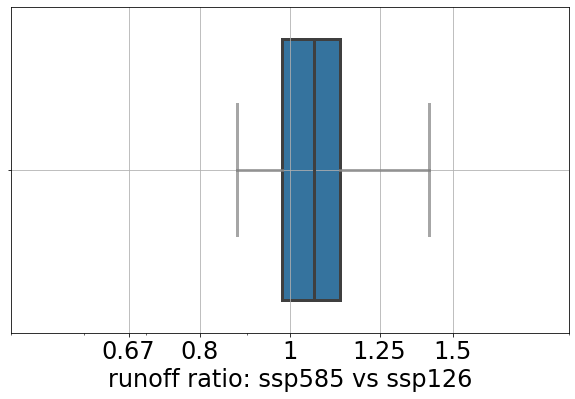

In [143]:
plt.figure(figsize=(10,6))
sns.boxplot((ds_merged_runoff.sel(ssp='ssp585') / ds_merged_runoff.sel(ssp='ssp126')).sel(time=slice(2080,2099)).mean(dim='time'),
           fliersize=0, whis=[5,95],
                        #col = 'time',
                        linewidth=3, 
                        #aspect=1.6, #order = calib_types,
                        #legend_out=False,
                        saturation=0.7, 
                       capprops={'color':'grey', 'alpha':0.7},
                    whiskerprops={'color':'grey', 'alpha':0.7}) #)
ax = plt.gca()
ax.set_xscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_minor_formatter(NullFormatter())
ax.set_xticklabels([])
ax.set_xticks([0.67, 0.8,1,1.25, 1.5], labels=[0.67, 0.8, 1,1.25,1.5])
plt.xlim([0.5,2])
ax.grid()

ax.set_xlabel('runoff ratio: ssp585 vs ssp126')

In [148]:
(ds_merged_runoff.sel(ssp='ssp585') / ds_merged_runoff.sel(ssp='ssp126')).sel(time=slice(2080,2099)).mean(dim='time').quantile([0.05,0.25,0.5,0.75,0.95])

<xarray.DataArray (quantile: 5)>
array([0.87699463, 0.98006888, 1.06198499, 1.13307616, 1.415061  ])
Coordinates:
  * quantile  (quantile) float64 0.05 0.25 0.5 0.75 0.95

runoff is slightly larger for ssp585, on median, the ratio is 1.06, so around 6% larger ...

#### Let's only look at the "melt_on_glacier" variable for all glaciers:

In [54]:
runoff_var = 'melt_on_glacier'

In [57]:
ds.melt_on_glacier

0        1.000000
1        0.932307
2        1.000000
3        0.993787
4        1.000000
           ...   
29515         NaN
29516    0.542374
29517    2.635364
29518    0.044233
29519         NaN
Name: melt_on_glacier, Length: 29520, dtype: float64

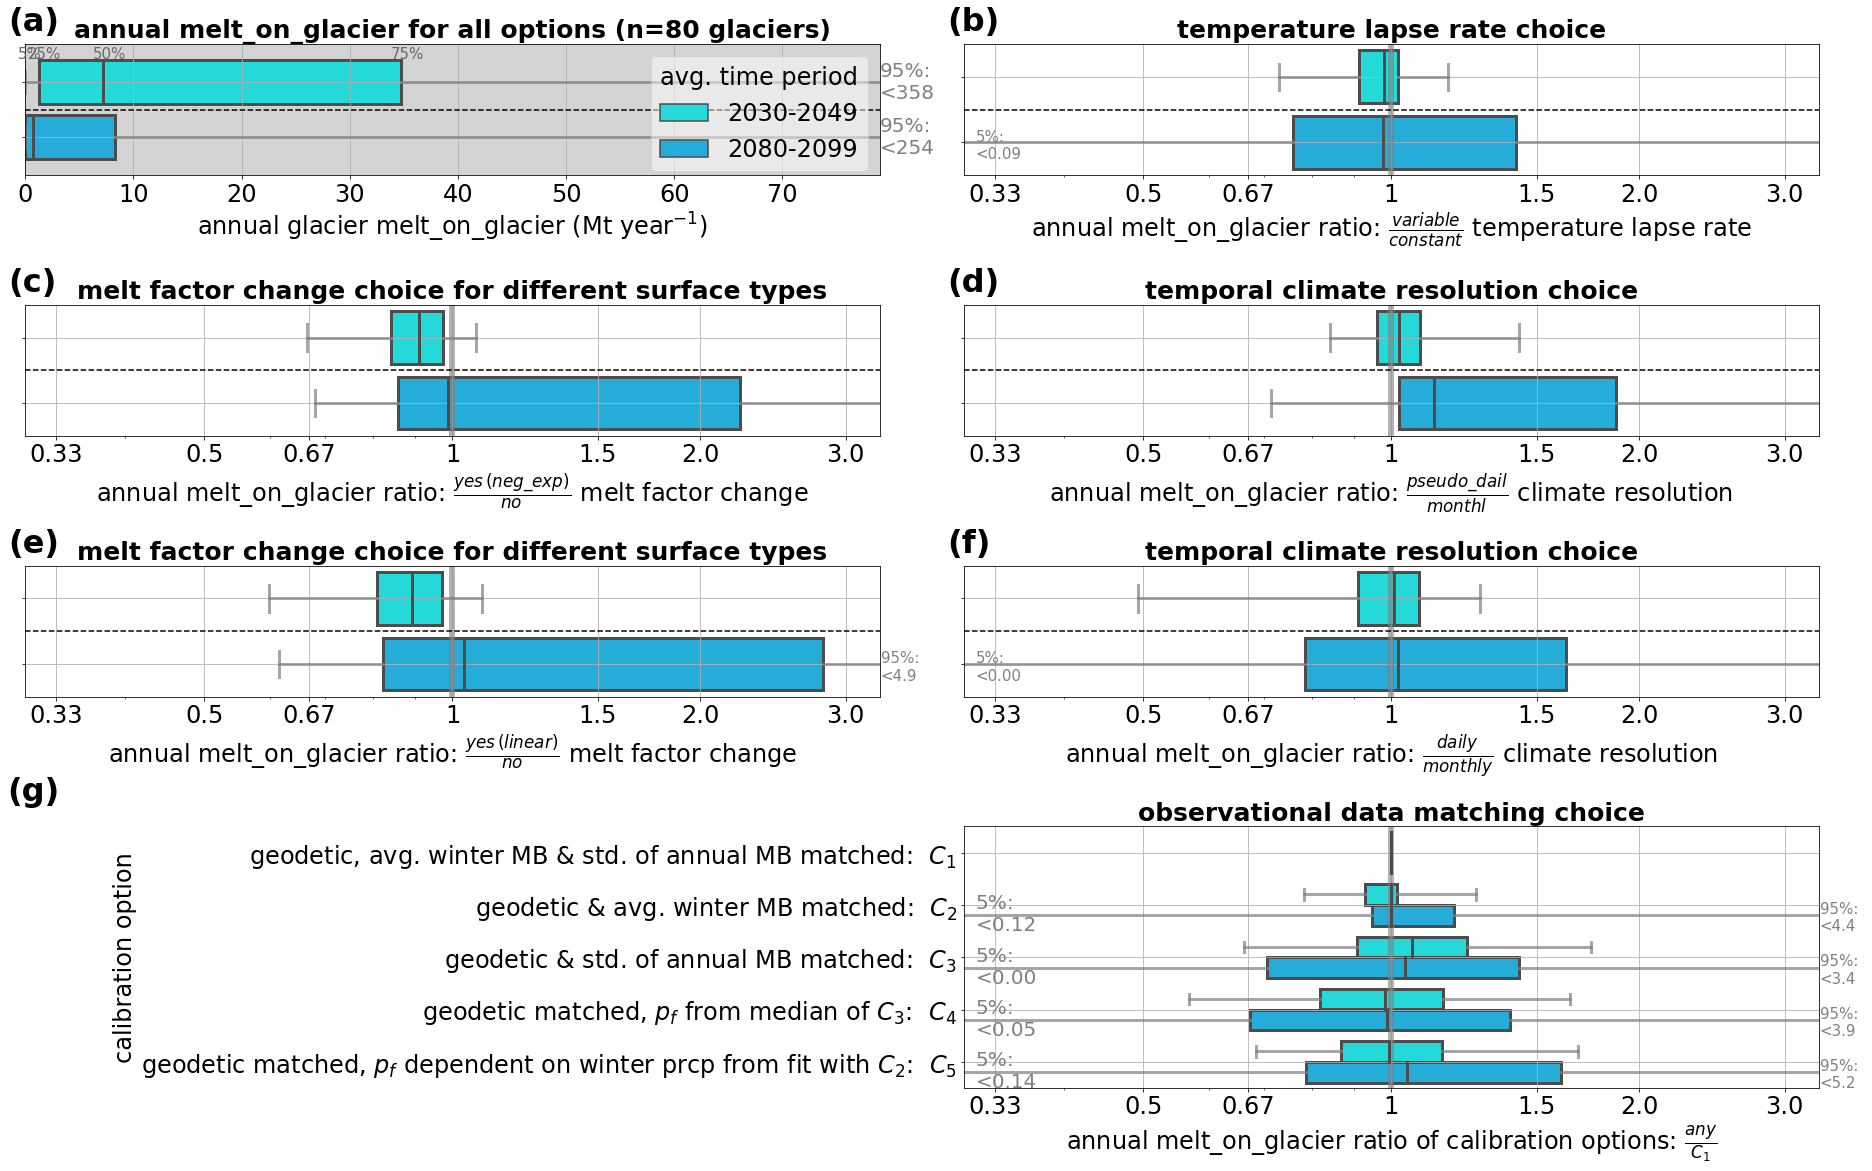

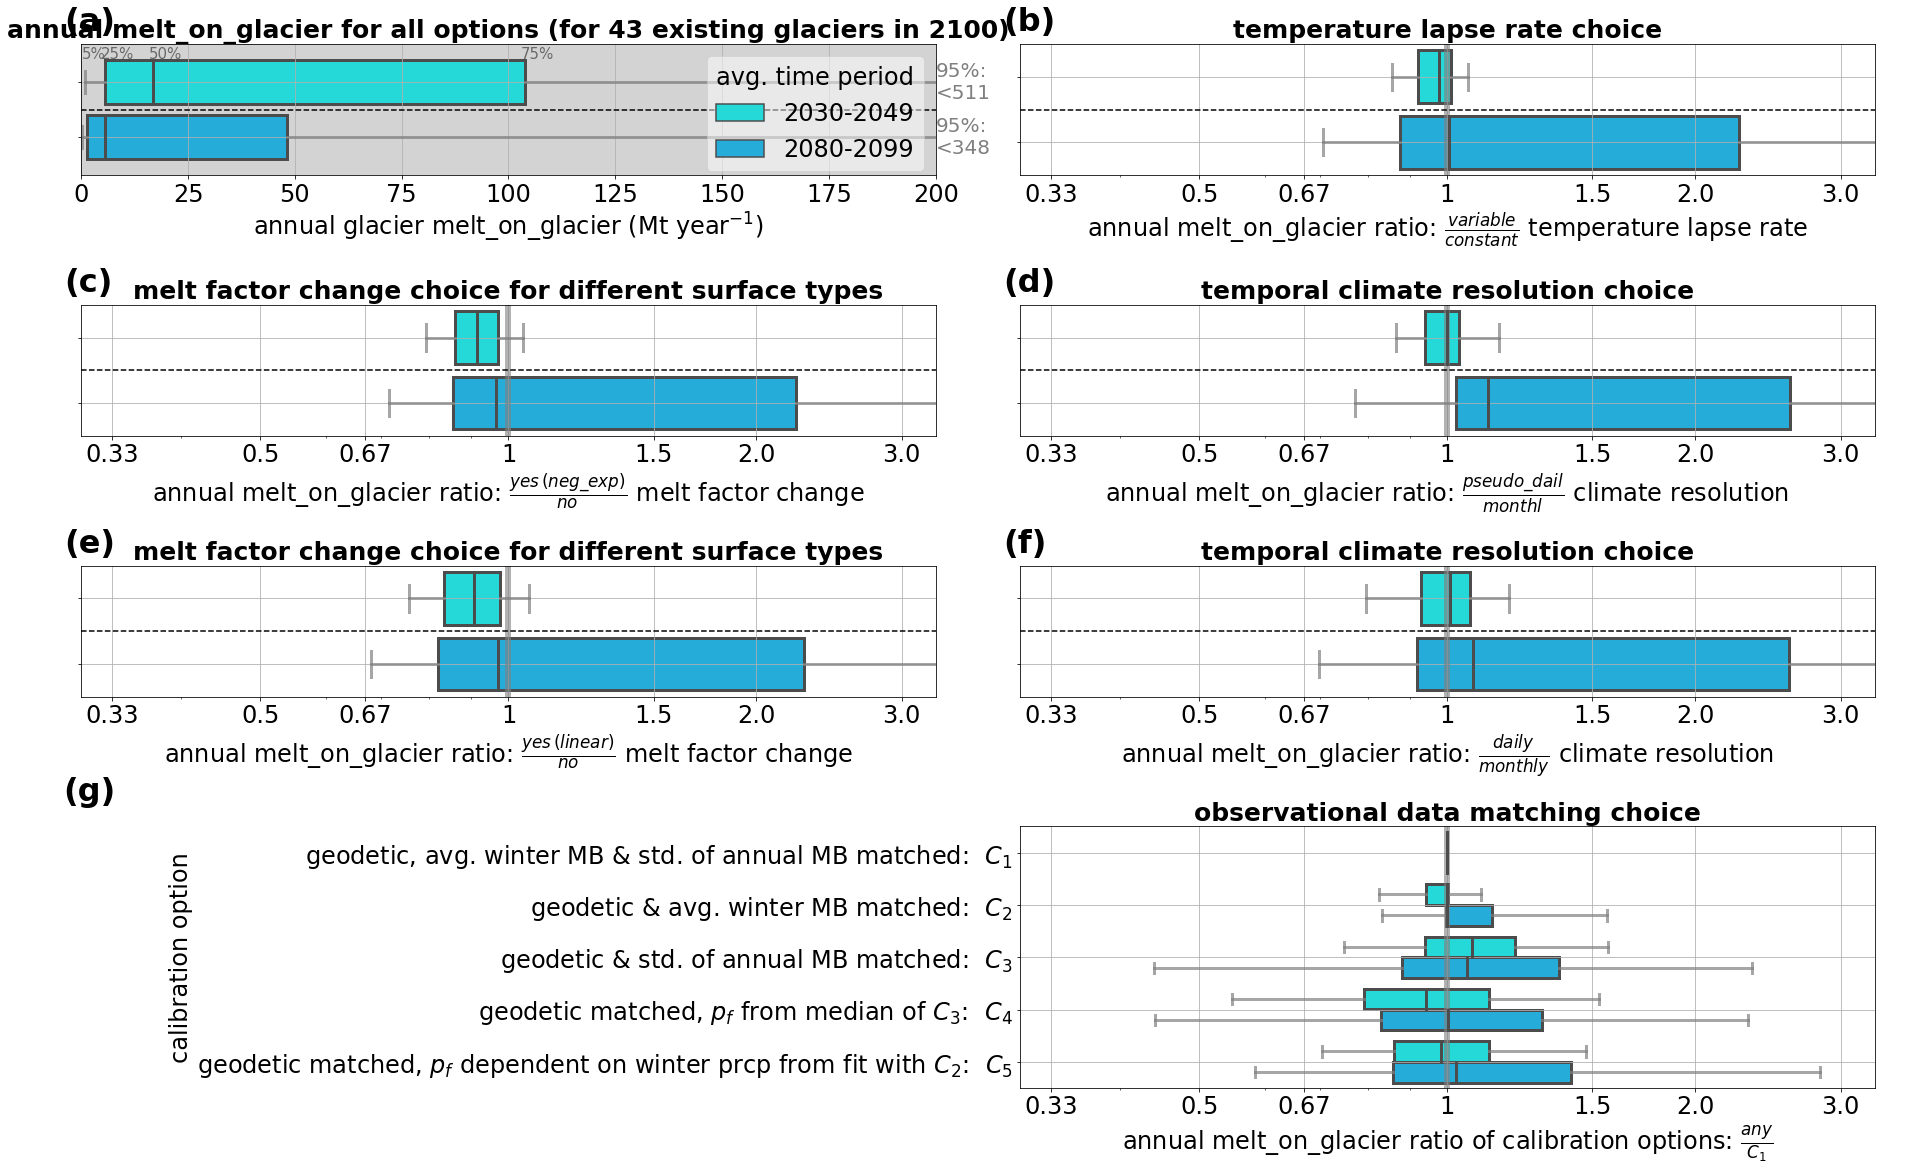

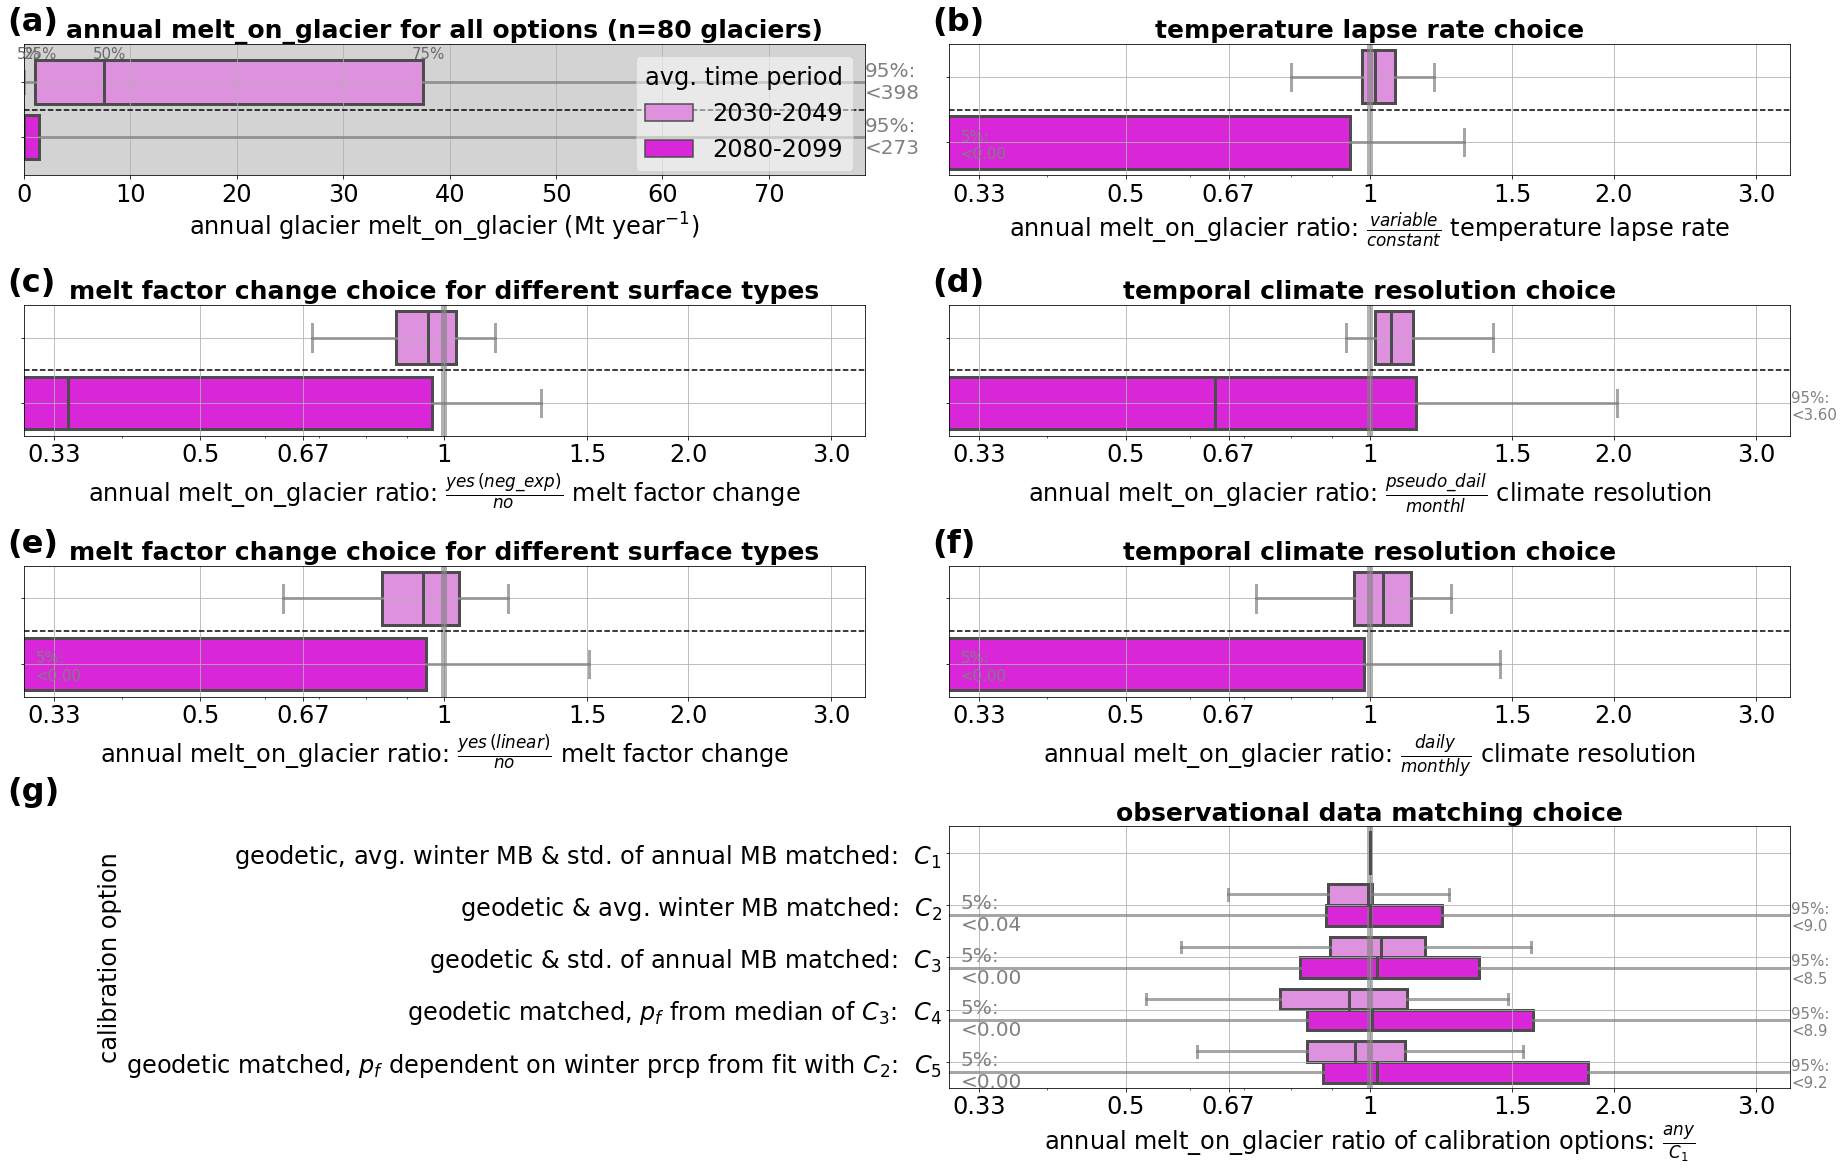

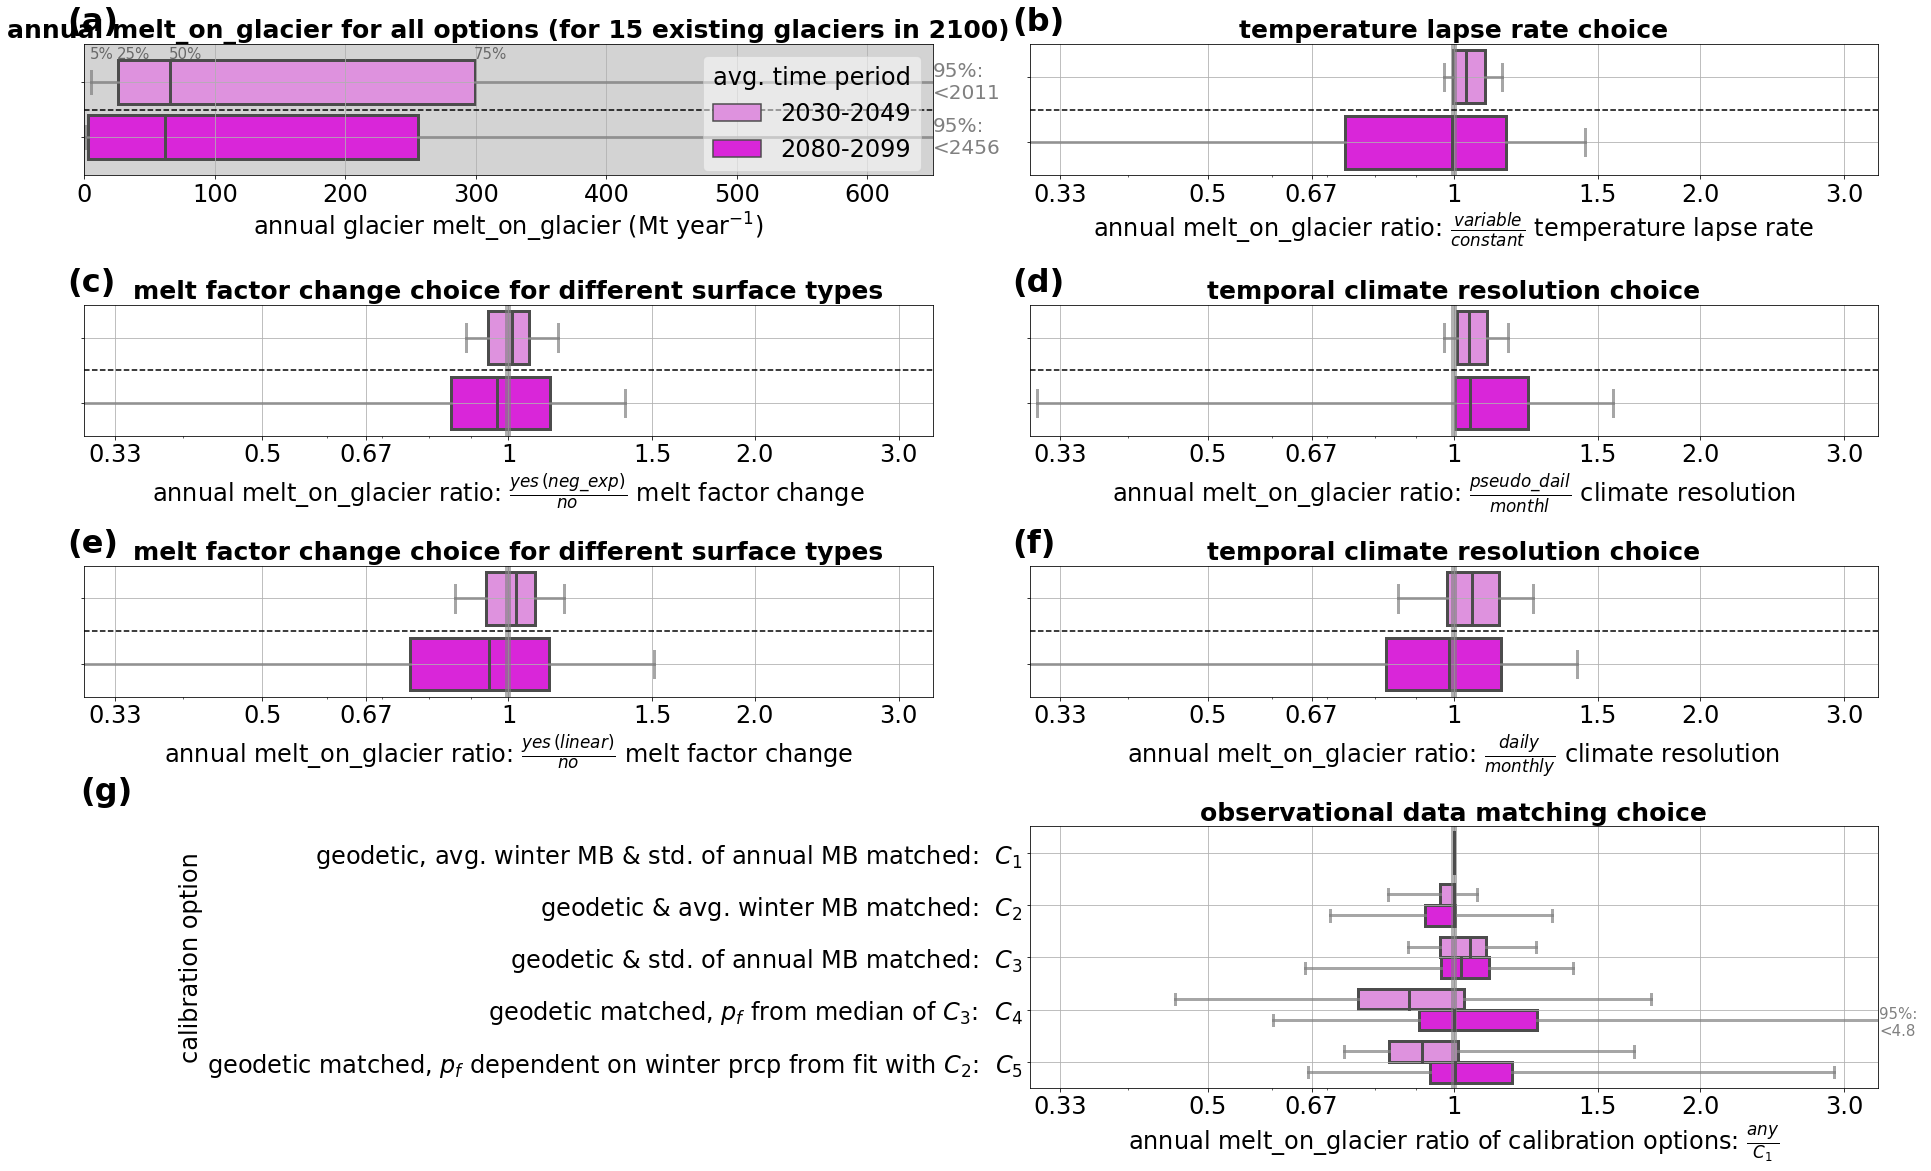

In [61]:
# overall MB and calib option influence
plt.rc('font', size=24)

num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)', 5: '(f)', 6: '(g)'}

# logarithmic scale because of ratios ...
xlim0 = 0.303
xlim1 = 3.3
fs_num_dict = 32
num_text_x = -0.02
num_text_y = 1.1

violin = False
all_same_glaciers = True ## True
#for all_same_glaciers in [True]: ## False
for ssp in ['ssp126', 'ssp585']:
    for only_still_existing_glaciers_in_2100 in [False, True]:
        ds_merged_runoff_avg = xr.concat([ds_a_melt_on_glacier,ds_b_melt_on_glacier], dim = 'time').copy()
        ds_merged_runoff_avg = ds_merged_runoff_avg.sel(rgi_id = rgi_working_calib)
        if only_still_existing_glaciers_in_2100:
            ds_merged_runoff_avg = ds_merged_runoff_avg.sel(rgi_id = working_dict[f'2099_{ssp}'])
        if not all_same_glaciers and ssp =='ssp126':
            ssp = np.NaN
        elif not all_same_glaciers and ssp == 'ssp126':
            break

        if all_same_glaciers:
            #pd_all = (100*(ds_merged.sel(time=slice(2040,2100,60))/ds_merged.sel(time=2020))).sel(rgi_id = working_dict[f'2100_{ssp}']).sel(ssp=ssp).to_dataframe().reset_index() #.groupby(['ssp', 'calib_type', 'time']).quantile([0.25,0.5,0.75]).round(2)).reset_index()
            #ds_m = ds_merged.sel(time=slice(2040,2100,60)).copy().sel(rgi_id = working_dict[f'2100_{ssp}']).sel(ssp=ssp)
            pd_all = ds_merged_runoff_avg.sel(ssp=ssp).to_dataframe(name=runoff_var).reset_index() #.groupby(['ssp', 'calib_type', 'time']).quantile([0.25,0.5,0.75]).round(2)).reset_index()
            ds_m = ds_merged_runoff_avg.sel(ssp=ssp).copy()
            if ssp == 'ssp126':
                col_pal_ssp = sns.color_palette(['cyan','deepskyblue'])
            else:
                #col_pal_ssp = sns.color_palette(['magenta'])
                col_pal_ssp = sns.color_palette(['violet','magenta'])


        #pd_all['time'] = pd_all.time.astype(int).astype(str)

        c = 2
        r = 9
        if ssp == 'ssp126':
            plt.subplots(figsize=(26,16), squeeze=False)
        else:
            plt.subplots(figsize=(26,16), squeeze=False)
        

        ax0 = plt.subplot2grid((r, c), (0, 0), rowspan=2)
        ax2 = plt.subplot2grid((r, c), (0, 1), rowspan=2)
        
        
        ax1 = plt.subplot2grid((r, c), (2, 0), rowspan=2)
        ax1b = plt.subplot2grid((r, c), (4, 0), rowspan=2)

        ax3 = plt.subplot2grid((r, c), (2, 1), rowspan=2)
        ax3b = plt.subplot2grid((r, c), (4, 1), rowspan=2)

        ax4 = plt.subplot2grid((r, c), (6, 1), rowspan=3)
            
        for option_v in ['grad_type', 'mb_type_pseudo_daily','mb_type_daily','melt_f_change_neg_exp', 'melt_f_change_linear']:
            if option_v == 'melt_f_change_linear':
                tips = ['linear']
                default = 'False'
                option = 'melt_f_change'
            elif option_v == 'grad_type':
                tips = ['var_an_cycle']
                default = 'cte'
                option = option_v
            elif option_v == 'mb_type_daily':
                tips = ['mb_real_daily']
                default = 'mb_monthly'
                option = 'mb_type'
            elif option_v == 'melt_f_change_neg_exp':
                tips = ['neg_exp']
                default = 'False'
                option = 'melt_f_change'
            elif option_v == 'mb_type_pseudo_daily':
                tips = ['mb_pseudo_daily']
                default = 'mb_monthly'
                option = 'mb_type'
            for j, tip in enumerate(tips):
                if 'melt_f_change' in option_v:
                    t = 'melt factor change choice for different surface types'
                    if option_v == 'melt_f_change_linear':
                        ax = ax1b
                    else:
                        ax = ax1
                    ref_v_opt = ds_merged_runoff_avg.sel(melt_f_change = default)
                elif option_v == 'grad_type':
                    t = 'temperature lapse rate choice'
                    #ax = axs[1][0]
                    ax = ax2
                    ref_v_opt = ds_merged_runoff_avg.sel(grad_type = default)
                elif 'mb_type' in option_v:
                    t =  'temporal climate resolution choice'
                    if option_v == 'mb_type_daily':
                        ax = ax3b
                    else:
                        ax = ax3
                    ref_v_opt = ds_merged_runoff_avg.sel(mb_type = default)

                #if all_same_glaciers:
                #    ref_v_opt = ref_v_opt.sel(rgi_id = working_dict[f'2100_{ssp}']).sel(ssp=ssp)
                    
                ds_m_vs_ref = ds_m/ref_v_opt 
                ds_m_vs_ref = ds_m_vs_ref.where(ds_m_vs_ref < np.inf, drop=True) 

                ds = ds_m_vs_ref.to_dataframe(name=runoff_var).reset_index()
                #ds = ds_m_vs_ref.to_dataframe().reset_index()
                # ds['time'] = ds.time.astype(str)
                ds = ds.loc[ds[runoff_var].dropna().index]
                ds = ds.loc[ds[option] == tip]
                if violin:
                    sns.violinplot(x=runoff_var, hue='ssp',data=ds,
                                    fliersize=0, whis=0, y = 'time', #hue_order = ['2040', '2100'],
                                    linewidth=3,
                                    palette=col_pal_ssp,
                                    saturation=0.7, cut = True, ax = ax)
                else:
                    f = sns.boxplot(x=runoff_var, hue='time', y='time', dodge = False, #hue='ssp',
                                    data=ds,
                                    fliersize=0, whis = [5,95], 
                                    #y = 'time', #hue_order = ['2040', '2100'],
                                    linewidth=3,
                                    palette=col_pal_ssp,
                                    saturation=0.7,# aspect=1.6, #order = ['var_an_cycle'],
                                    capprops={'color':'grey', 'alpha':0.7},
                                    whiskerprops={'color':'grey', 'alpha':0.7},
                                    #legend_out=False
                                    ax = ax) #, legend=False) #, grid=True)
                ax.axvline(1.0, color='grey', linewidth=6, alpha=0.6)

                handles, labels = ax.get_legend_handles_labels()
                # xlim1 = 2.1
                ax.legend_.remove()
                #ax.get_legend()
                p = 0.2
                if 'melt_f_change' in option_v and tip == 'linear':
                    ax.set_xlabel(r'annual melt_on_glacier ratio: $\frac{yes\,(linear)}{no}$ melt factor change', fontsize=24)
                    q95 = ds.groupby(['ssp', 'time'])[runoff_var].quantile(0.95).loc[(ssp, '2080-2099')].round(1)
                    if q95 >= xlim1:
                        ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.1f}', color = 'grey', fontsize=15)
                    # any value to get the same format as ssp585 (were there are outliers ...)
                    ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<5.1', color = 'grey', fontsize=15, alpha = 0)

                        
                    q05 = ds.groupby(['ssp', 'time'])[runoff_var].quantile(0.05).loc[(ssp, '2080-2099')]
                    if q05 <= xlim0:
                        ax.text(xlim0+0.01,1.05+p,r'5%:'+f'\n<{q05:.2f}', color = 'grey', fontsize=15)
                if 'melt_f_change' in option_v and tip == 'neg_exp':
                    ax.set_xlabel(r'annual melt_on_glacier ratio: $\frac{yes\,(neg\_exp)}{no}$ melt factor change', fontsize=24)
                    q95 = ds.groupby(['ssp', 'time'])[runoff_var].quantile(0.95).loc[(ssp, '2080-2099')].round(1)
                    if q95 >= xlim1:
                        ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.1f}', color = 'grey', fontsize=15)
                elif option_v == 'grad_type':
                    ax.set_xlabel(r'annual melt_on_glacier ratio: $\frac{variable}{constant}$ temperature lapse rate', fontsize=24)
                    q95 = ds.groupby(['ssp', 'time'])[runoff_var].quantile(0.95).loc[(ssp, '2080-2099')].round(1)
                    if q95 >= xlim1:
                        ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.1f}', color = 'grey', fontsize=15)
                        
                    q05 = ds.groupby(['ssp', 'time'])[runoff_var].quantile(0.05).loc[(ssp, '2080-2099')]
                    if q05 <= xlim0:
                        ax.text(xlim0+0.01,1.05+p,r'5%:'+f'\n<{q05:.2f}', color = 'grey', fontsize=15)
                elif 'mb_type' in option_v and tip == 'mb_pseudo_daily':
                    ### strangely I can't add the "y" in the label, other wise the tight_layout will fail
                    # I will just add the manually later ...
                    ax.set_xlabel(r'annual melt_on_glacier ratio: $\frac{pseudo\_dail}{monthl}$ climate resolution', fontsize=24)
                    #ax.set_xlabel(r'runoff ratio: $\frac{pseudo-daily}{monthly}$ climate resolution', fontsize=24)
                    q95 = ds.groupby(['ssp', 'time'])[runoff_var].quantile(0.95).loc[(ssp, '2080-2099')].round(1)
                    if q95 >= xlim1:
                        ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.2f}', color = 'grey', fontsize=15)
                elif 'mb_type' in option_v and tip == 'mb_real_daily':
                    ax.set_xlabel(r'annual melt_on_glacier ratio: $\frac{daily}{monthly}$ climate resolution', fontsize=24)
                    q95 = ds.groupby(['ssp', 'time'])[runoff_var].quantile(0.95).loc[(ssp, '2080-2099')].round(1)
                    if q95 >= xlim1:
                        ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.1f}', color = 'grey', fontsize=15)
                        
                    q05 = ds.groupby(['ssp', 'time'])[runoff_var].quantile(0.05).loc[(ssp, '2080-2099')].round(1)
                    if q05 <= xlim0:
                        ax.text(xlim0+0.01,1.05+p,r'5%:'+f'\n<{q05:.2f}', color = 'grey', fontsize=15)
                if j == 0:
                    ax.set_title(t, fontsize=25, weight='bold') 
                    
                ax.set_xscale("log")
                from matplotlib.ticker import ScalarFormatter, NullFormatter
                ax.xaxis.set_major_formatter(ScalarFormatter())
                ax.xaxis.set_minor_formatter(NullFormatter())
                ax.set_xlim([xlim0,xlim1])
                ax.set_xticklabels([])
                ax.set_ylabel('')
                # ERROR
                #  ax.set_xticklabels([0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0], labels=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0])
                ax.set_xticks(ticks=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0],
                              labels=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0])
                ax.grid() #axis='y')
                ax.axhline(0.5,color='black', ls = '--')
                ax.set_yticklabels([])
                #plt.tight_layout()
        

        #ax = axs[0][0]
        ax = ax0
        ax.set_facecolor('lightgray')
        sns.boxplot(data=pd_all,
                    x=runoff_var, hue='time', y='time', dodge = False,
                    fliersize=0, whis = [5,95], #y = 'time', #hue_order = ['2040', '2100'],
                    linewidth=3,
                    palette=col_pal_ssp,
                    saturation=0.7,# aspect=1.6, #order = ['var_an_cycle'],
                    capprops={'color':'grey', 'alpha':0.7},
                    whiskerprops={'color':'grey', 'alpha':0.7},
                    #legend_out=False
                    ax = ax)
        qs = pd_all.groupby(['ssp', 'time'])[runoff_var].quantile([0.05,0.25,0.5,0.75,0.95]).loc[(ssp, '2030-2049')].values
        #ax.text(qs[0]-14,-0.42,f'percentiles:', color = 'dimgrey', fontsize=15)

        # xlimit of ax0
        if only_still_existing_glaciers_in_2100 and ssp == 'ssp126':
            ax0_xlim1 = 200
        elif only_still_existing_glaciers_in_2100 and ssp != 'ssp126':
            ax0_xlim1 = 650
        else:
            ax0_xlim1 = 79

        for p,q in enumerate(qs):
            perci = [5,25,50,75,95][p]
            if perci == 5:
                ax.text(q-0.7,-0.43,f'{perci}%', color = 'dimgrey', fontsize=15)
            else:
                if q >= ax0_xlim1:
                    ax.text(ax0_xlim1+0.01,0.3,f'{perci}%:'+f'\n<{q:.0f}', color = 'grey', fontsize=20)
                else:
                    ax.text(q-1.0,-0.43,f'{perci}%', color = 'dimgrey', fontsize=15)
                    
        qs_80_99 = pd_all.groupby(['ssp', 'time'])[runoff_var].quantile(0.95).loc[(ssp, '2080-2099')] #.values
        if qs_80_99 > ax0_xlim1:
            ax.text(ax0_xlim1+0.01,1.3,f'95%:'+f'\n<{qs_80_99:.0f}', color = 'grey', fontsize=20)



        #ax.set_xlabel('glacier runoff (Mt)', fontsize=24)
        ax.set_xlabel(f'annual glacier {runoff_var} '+r'(Mt year$^{-1}$)', fontsize=24)
        #ax.text(qs[0]-14,-0.42,f'percentiles:', color = 'dimgrey', fontsize=15)


        ax.set_ylabel('')

        #ax.grid(axis='y', lw=2)
        ax.axhline(0.5,color='black', ls = '--')
        #ax.set_xlim([-2,101])
        ax.set_ylim([1.7,-0.7])
        ax.set_xlim([0,ax0_xlim1])



        p = 0
        if only_still_existing_glaciers_in_2100:
            n = len(working_dict[f'2099_{ssp}'])
            ax.set_title(f'annual melt_on_glacier for all options (for {n} existing glaciers in 2100)', fontsize=25,weight='bold')
        else:
            ax.set_title(f'annual melt_on_glacier for all options (n={len(ds.rgi_id.unique())} glaciers)', fontsize=25,weight='bold')
        ax.legend(loc='upper right', title='avg. time period', framealpha = 0.5) #     ax.legend(bbox_to_anchor=(0.4,0.2))
        ax.set_yticklabels([])



        
        calib_types_nice = [r'geodetic, avg. winter MB & std. of annual MB matched:$\,\,\,\,C_1$',
                            r'geodetic & avg. winter MB matched:$\,\,\,\,C_2$',
                            r'geodetic & std. of annual MB matched:$\,\,\,\,C_3$',
                            r'geodetic matched, $p_f$ from median of $C_3$:$\,\,\,\,C_4$',
                            r'geodetic matched, $p_f$ dependent on winter prcp from fit with $C_2$:$\,\,\,\,C_5$']
        
        
        ref_v_opt = ds_m.sel(calib_type=calib_types[0])
        ds_m_vs_ref = ds_m/ref_v_opt 
        ds_m_vs_ref = ds_m_vs_ref.where(ds_m_vs_ref < np.inf, drop=True) 
        
        ds= ds_m_vs_ref.to_dataframe(name=runoff_var).reset_index() # sel(rgi_id =w_rgis) #.sel(ssp=ssp)
        #ds['time'] = ds['time'].astype('int')
        ax.grid()
        plt.tight_layout()
        
        ax = ax4
        #ax = axs[2][1]
        f = sns.boxplot(y='calib_type', x=runoff_var, hue='time', data=ds, palette=col_pal_ssp, #kind='box',
                        fliersize=0, whis=[5,95],
                        #col = 'time',
                        linewidth=3, 
                        #aspect=1.6, #order = calib_types,
                        #legend_out=False,
                        saturation=0.7, ax=ax,
                       capprops={'color':'grey', 'alpha':0.7},
                    whiskerprops={'color':'grey', 'alpha':0.7}) #, grid=True)


        #if yr == 2040:
        #    a.set_xlim([0.0,0.1])
        #elif yr==2100:
        #ax.set_xlim([0.2,1.8])
        #ax.legend(loc='upper right', framealpha = 0.5)
        ax.grid()
        #if ax != axs[0]:
        #    ax.set_ylabel('')
        #    ax.legend_.remove()
        #ax.set_title(f'{ssp}: n={len(w_rgis)} glaciers')
        ax.set_xlabel(r'annual melt_on_glacier ratio of calibration options: $\frac{any}{C_1}$')
        ax.axvline(1.0, color='grey', linewidth=6, alpha=0.6)

        #xlim1 = 2.8
        #ax.set_xlim([0.15, xlim1]) # 0.01
        ax.set_xscale("log")
        from matplotlib.ticker import ScalarFormatter, NullFormatter
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.xaxis.set_minor_formatter(NullFormatter())
        ax.set_xlim([xlim0,xlim1])
        ax.set_xticklabels([])
        ax.set_xticks([0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0], labels=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0])
        ax.legend_.remove()

        ax.set_yticklabels(calib_types_nice)
        ax.set_ylabel('calibration option')
        ax.set_title('observational data matching choice', fontsize=25,weight='bold') 
        
        for jj, cc in enumerate(calib_types):
            q05 = ds.loc[ds.calib_type==cc].groupby(['ssp', 'time'])[runoff_var].quantile(0.05).loc[(ssp, '2080-2099')]
            if q05 <= xlim0:
                ax.text(xlim0+0.01,jj+0.5,r'5%:'+f'\n<{q05:.2f}', color = 'grey', fontsize=20)
            q95 = ds.loc[ds.calib_type==cc].groupby(['ssp', 'time'])[runoff_var].quantile(0.95).loc[(ssp, '2080-2099')].round(1)
            if q95 >= xlim1:
                ax.text(xlim1+0.01,jj+0.5,r'95%:'+f'\n<{q95:.1f}', color = 'grey', fontsize=15)
                # make sure that ssp126 and ssp585 have the same format, need to plot it with alpha = 0
                # just any value
        ax.text(xlim1+0.01,jj+0.5,r'95%:'+f'\n<20.1', color = 'grey', fontsize=15, alpha = 0)
        
        # has to come after tight_layout ...
        ax0.text(num_text_x,num_text_y,'(a)',weight='bold',
                    fontsize=fs_num_dict, transform=ax0.transAxes)
        ax2.text(num_text_x,num_text_y,'(b)',weight='bold',
                    fontsize=fs_num_dict, transform=ax2.transAxes)
        
        ax1.text(num_text_x,num_text_y,'(c)',weight='bold',
                    fontsize=fs_num_dict, transform=ax1.transAxes)
        ax1b.text(num_text_x,num_text_y,'(e)',weight='bold',
                    fontsize=fs_num_dict, transform=ax1b.transAxes)

        ax3.text(num_text_x,num_text_y,'(d)',weight='bold',
                    fontsize=fs_num_dict, transform=ax3.transAxes)
        ax3b.text(num_text_x,num_text_y,'(f)',weight='bold',
                    fontsize=fs_num_dict, transform=ax3b.transAxes)

        ax4.text(num_text_x-1.1,num_text_y,'(g)',weight='bold',
                    fontsize=fs_num_dict, transform=ax4.transAxes)    
        
    
        #plt.savefig(f'../figures/additional/rel_vol_to_def_options_for_glaciers_working_all_options_simple_boxplot_{ensemble}_only_{ssp}.pdf', pad_inches=0.05, bbox_inches='tight')
        #plt.savefig(f'../figures/additional/rel_vol_to_def_options_for_glaciers_working_all_options_simple_boxplot_{ensemble}_only_{ssp}.png', pad_inches=0.05, bbox_inches='tight')
        if only_still_existing_glaciers_in_2100:
            plt.savefig(f'{fig_path}/rel_runoff_only_{runoff_var}_to_ref_timodel_calib_option_{ensemble}_common_running_{ssp}_glaciers_still_existing_in_2100.pdf',
                        bbox_inches='tight')
        else:
            plt.savefig(f'{fig_path}/rel_runoff_only_{runoff_var}_to_ref_timodel_calib_option_{ensemble}_common_running_{ssp}.pdf',
                        bbox_inches='tight')
    #num_dict[5] = '(f)'
    #jj= 0
    #for axi in axs:
    #    for ax in axi:
    #        if not all_same_glaciers:
    #            ax.text(0.015,0.95, num_dict[jj], fontsize=22, transform=ax.transAxes) 
    #        else:
    #            ax.text(0.008,0.92, num_dict[jj], fontsize=24, transform=ax.transAxes)    
    #        jj +=1


        #plt.tight_layout()
    #if all_same_glaciers:
    #plt.savefig(f'../figures/poster_rel_vol_to_def_MB_options_simple_boxplot_{ensemble}_all_same_glaciers_only_{ssp}.pdf', pad_inches=0.05, bbox_inches='tight')
    #else:
    #    plt.savefig(f'../figures/poster/rel_vol_to_def_MB_options_simple_boxplot_{ensemble}.pdf', pad_inches=0.05, bbox_inches='tight')
